Name: Tsoi Kwan Ma, Student ID: 476914

Name: Zahra Eshtiaghi, Student ID: 476679

# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from scipy.stats import skew

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, accuracy_score,precision_score,recall_score, classification_report
from sklearn import tree

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# **Data Preparation and Exploratory Data Analysis**

## Preliminary Data Checks

In [2]:
drinking = pd.read_csv("smoking_driking_dataset_Ver01.csv")

In [3]:
drinking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

Description of the Dataset:

| Column | Description (US) | KR |
|-------|------------------|----|
| Sex | male, female | 성별 |
| age | round up to 5 years | 나이 |
| height | round up to 5 cm [cm] | 키 |
| weight | round up to 5 kg [kg] | 몸무게 |
| sight_left | eyesight (left) | 시력(좌) |
| sight_right | eyesight (right) | 시력(우) |
| hear_left | hearing left, 1 (normal), 2 (abnormal) | 청력 |
| hear_right | hearing right, 1 (normal), 2 (abnormal) | 청력 |
| SBP | Systolic blood pressure [mmHg] | 수축기 혈압 |
| DBP | Diastolic blood pressure [mmHg] | 이완기 혈압 |
| BLDS | BLDS or FSG (fasting blood glucose) [mg/dL] | 공복혈당 |
| tot_chole | total cholesterol [mg/dL] | 총 콜레스테롤 |
| HDL_chole | HDL cholesterol [mg/dL] | HDL 콜레스테롤 |
| LDL_chole | LDL cholesterol [mg/dL] | LDL 콜레스테롤 |
| triglyceride | triglyceride [mg/dL] | 중성지방 |
| hemoglobin | hemoglobin [g/dL] | 헤모글로빈 |
| urine_protein | protein in urine, 1 (-), 2 (+/-), 3 (+1), 4 (+2), 5 (+3), 6 (+4) | 요단백 또는 단백뇨 |
| serum_creatinine | serum (blood) creatinine [mg/dL] | 혈청 크레아티닌 |
| SGOT_AST | SGOT (Glutamate-oxaloacetate transaminase) AST (Aspartate transaminase) [IU/L] | 혈청지오티 AST |
| SGOT_ALT | ALT (Alanine transaminase) [IU/L] | 혈청지오티 ALT |
| gamma_GTP | γ-glutamyl transpeptidase [IU/L] | 감마지티피 |
| SMK_stat_type_cd | Smoking state, 1 (never), 2 (used to smoke but quit), 3 (still smoke) | 흡연상태 |
| DRK_YN | Drinker or Not | 음주여부 |


In [4]:
print(drinking.duplicated().sum())

26


In [5]:
print(drinking.isnull().sum()) # no missing values

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64


In [6]:
drinking['DRK_YN'] = drinking['DRK_YN'].map({'Y': 1, 'N': 0})
drinking['sex'] = drinking['sex'].map({'Male': 1, 'Female': 0})

## Data Spliting

In [7]:
# to avoid data leakage, must do the spliting first

# train (60%) and temporary (40%)
drinking_train, temporary = train_test_split(drinking, test_size = 0.4, random_state = 123, stratify = drinking['DRK_YN'])

# validation (20%) and Test (20%) from temporary (40%)
drinking_validation, drinking_test = train_test_split(temporary, test_size = 0.5, random_state = 123, stratify = temporary['DRK_YN'])
# target variable claim_status is imbalanced, stratify = ... ensures all splits maintain the same proportion of Yes and No
# this gives better generalization

# for reproducibility
print("Train shape:", drinking_train.shape)
print("Validation shape:", drinking_validation.shape)
print("Test shape:", drinking_test.shape)

Train shape: (594807, 24)
Validation shape: (198269, 24)
Test shape: (198270, 24)


In [8]:
with open("drinking_split.pkl", "wb") as f:
    pickle.dump(drinking_train, f)
    pickle.dump(drinking_test, f)
    pickle.dump(drinking_validation, f)

## Exploratory Data Analysis

In [9]:
with open('drinking_split.pkl', 'rb') as f:
    drinking_train = pickle.load(f)
    drinking_validation = pickle.load(f)
    drinking_test = pickle.load(f)

In [10]:
variables = drinking_train.columns.tolist()

summary = pd.DataFrame({
    'Variable': variables,
    'Min': [drinking[var].min() for var in variables],
    'Max': [drinking[var].max() for var in variables],
    'Mean': [drinking[var].mean() for var in variables],
    'Median': [drinking[var].median() for var in variables]
})

print(summary)

            Variable    Min     Max        Mean  Median
0                sex    0.0     1.0    0.531010     1.0
1                age   20.0    85.0   47.614491    45.0
2             height  130.0   190.0  162.240625   160.0
3             weight   25.0   140.0   63.284050    60.0
4          waistline    8.0   999.0   81.233358    81.0
5         sight_left    0.1     9.9    0.980834     1.0
6        sight_right    0.1     9.9    0.978429     1.0
7          hear_left    1.0     2.0    1.031495     1.0
8         hear_right    1.0     2.0    1.030476     1.0
9                SBP   67.0   273.0  122.432498   120.0
10               DBP   32.0   185.0   76.052627    76.0
11              BLDS   25.0   852.0  100.424447    96.0
12         tot_chole   30.0  2344.0  195.557020   193.0
13         HDL_chole    1.0  8110.0   56.936800    55.0
14         LDL_chole    1.0  5119.0  113.037692   111.0
15      triglyceride    1.0  9490.0  132.141751   106.0
16        hemoglobin    1.0    25.0   14.229824 

In [11]:
# check the extreme values to decide if remove the observations or not
drinking_train.loc[drinking_train['triglyceride'] == 9490, ['age', 'sex', 'tot_chole', 'HDL_chole', 'LDL_chole', 'SGOT_ALT', 'triglyceride', 'gamma_GTP']]

age  sex  tot_chole  HDL_chole  LDL_chole  SGOT_ALT  triglyceride  \
7075   20    0     1619.0     8110.0     5119.0      15.0        9490.0   

      gamma_GTP  
7075       18.0

In [12]:
drinking_train.loc[drinking_train['SGOT_ALT'] == 7210, ['age', 'sex', 'tot_chole', 'HDL_chole', 'LDL_chole', 'SGOT_ALT', 'triglyceride', 'gamma_GTP']]

Empty DataFrame
Columns: [age, sex, tot_chole, HDL_chole, LDL_chole, SGOT_ALT, triglyceride, gamma_GTP]
Index: []

In [13]:
drinking_train.loc[drinking_train['tot_chole'] == 2344, ['age', 'sex', 'triglyceride', 'HDL_chole', 'LDL_chole', 'SGOT_ALT', 'triglyceride', 'gamma_GTP']]

Empty DataFrame
Columns: [age, sex, triglyceride, HDL_chole, LDL_chole, SGOT_ALT, triglyceride, gamma_GTP]
Index: []

In [14]:
drinking_train.loc[drinking_train['HDL_chole'] == 8110, ['age', 'sex', 'tot_chole', 'LDL_chole', 'triglyceride', 'SGOT_ALT', 'gamma_GTP']]

age  sex  tot_chole  LDL_chole  triglyceride  SGOT_ALT  gamma_GTP
7075   20    0     1619.0     5119.0        9490.0      15.0       18.0

In [15]:
drinking_train = drinking_train[drinking_train['HDL_chole'] != 8110]

### Univariate Analysis of Target Variable

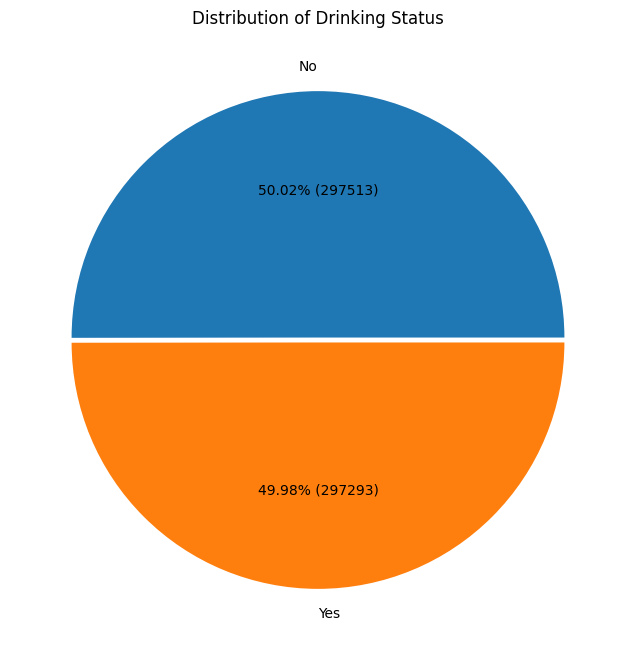

In [16]:
# univariate Analysis (Individual Feature)
drinking_status = drinking_train['DRK_YN'].value_counts()
status_labels = ['No', 'Yes']

def autopcts(values):
    def autopct(percentage):
        count = int(round(percentage / 100 * sum(values)))
        return f'{percentage:.2f}% ({count})'
    return autopct

plt.figure(figsize = (10, 8))
plt.pie(drinking_status, labels = status_labels, colors = sns.color_palette('viridis').reverse(), explode = [0.01, 0.01], autopct = autopcts(drinking_status.values))
plt.title('Distribution of Drinking Status')
plt.show()

In [17]:
drinking_train['DRK_YN'].value_counts(normalize=True)

DRK_YN
0    0.500185
1    0.499815
Name: proportion, dtype: float64

### Univariate Analysis of Categorical Varaibles

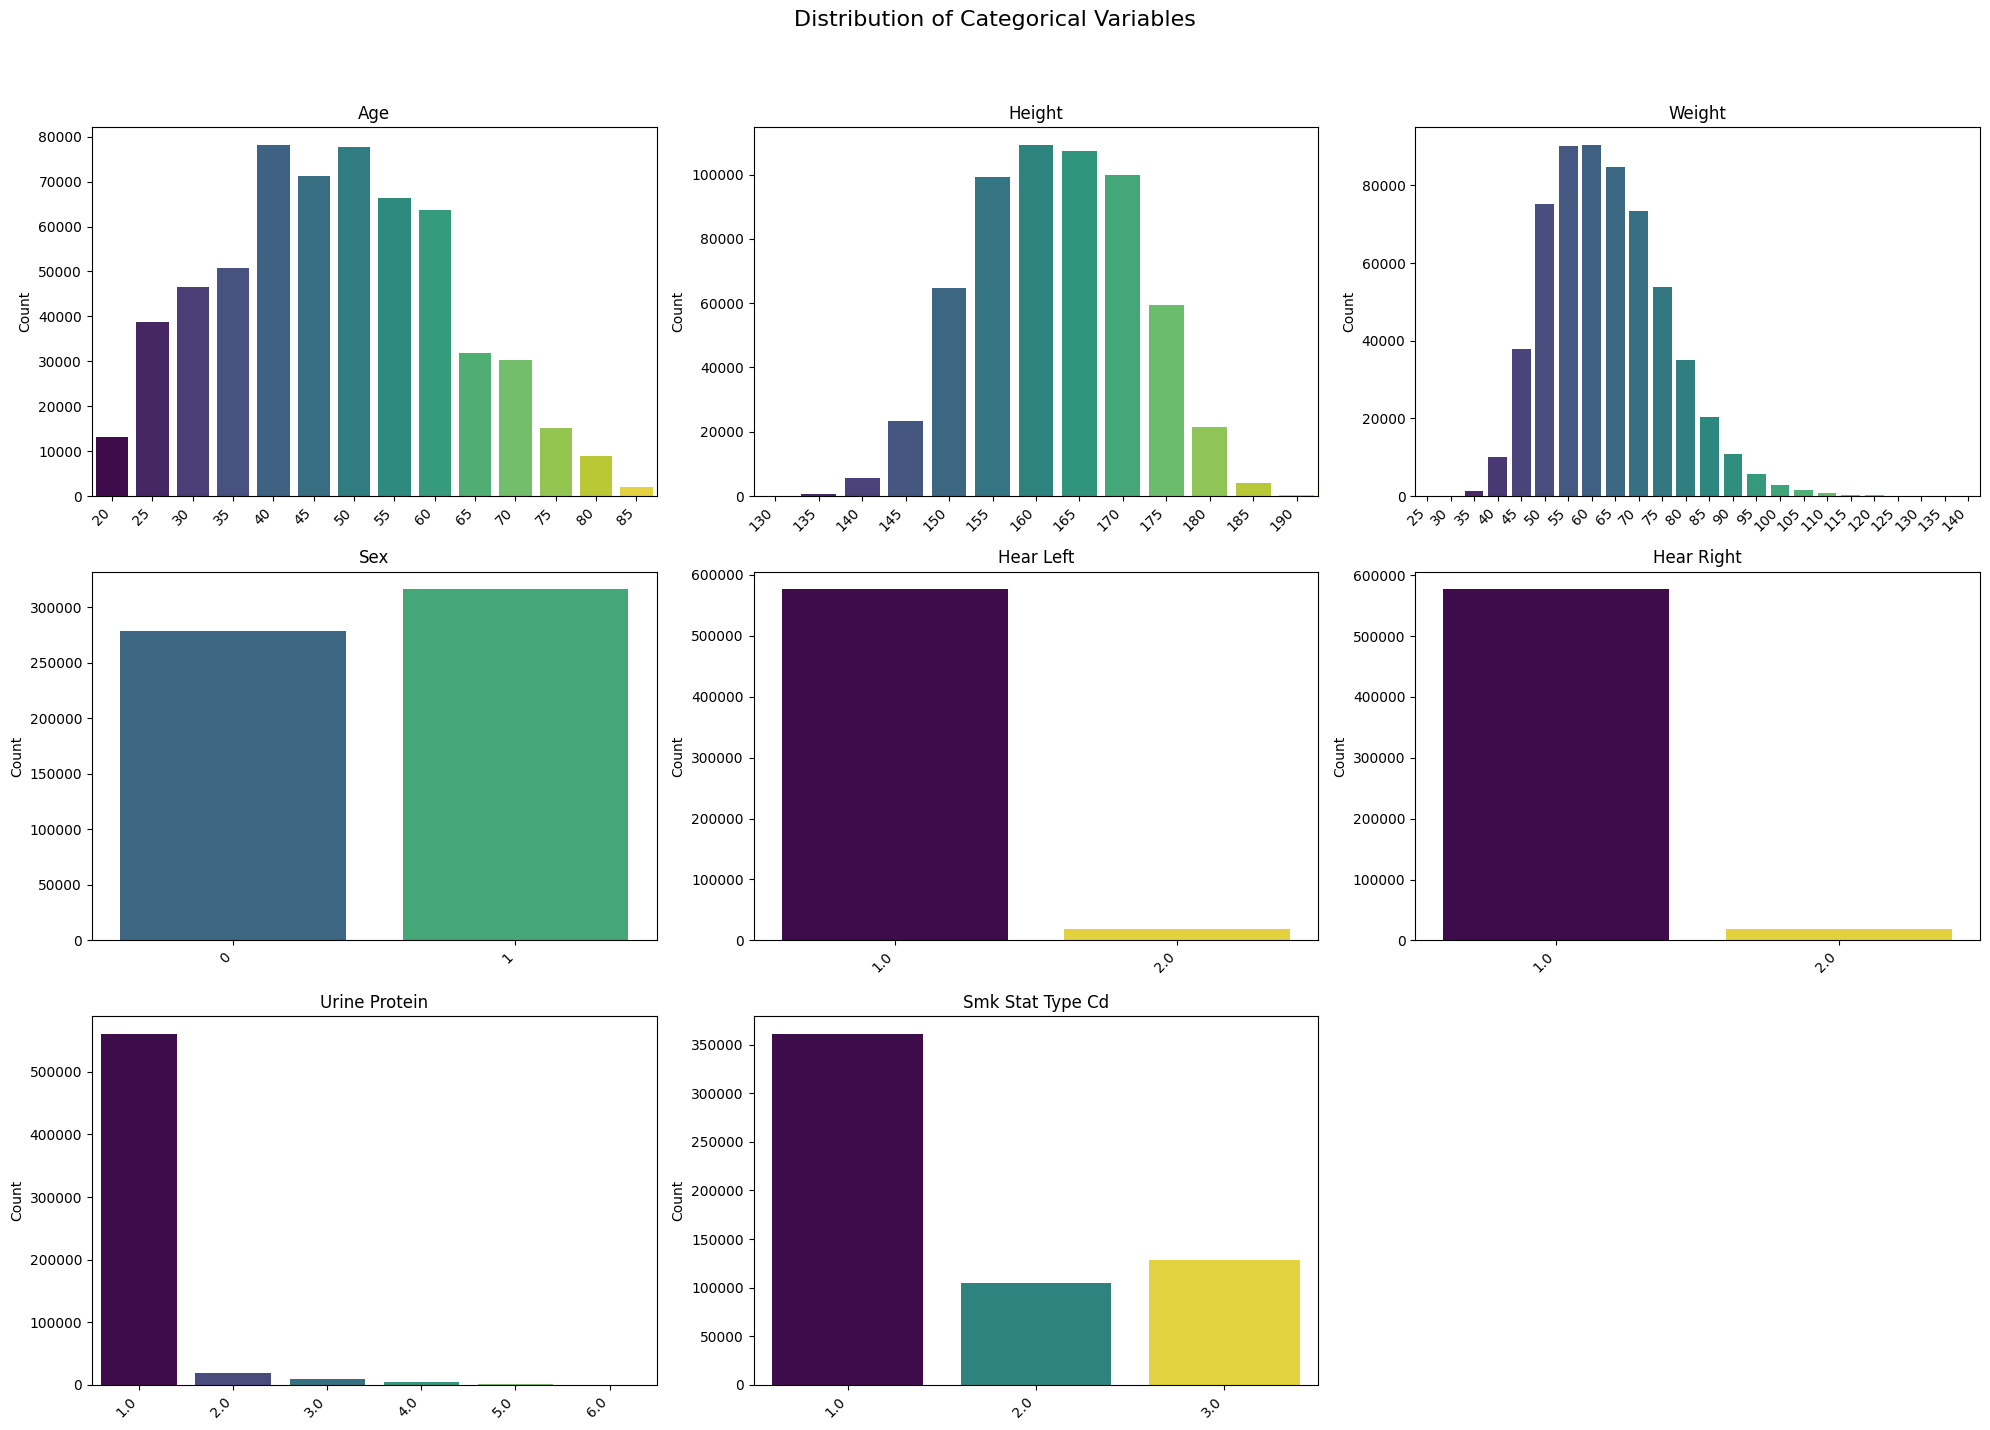

In [18]:
categorical_columns = ['age', 'height', 'weight', 'sex', 'hear_left', 'hear_right', 'urine_protein', 'SMK_stat_type_cd']

n_columns = 3
n_rows = (len(categorical_columns) + n_columns - 1) // n_columns

plt.figure(figsize = (20, n_rows * 5))
plt.suptitle('Distribution of Categorical Variables', fontsize = 16)

for i, column in enumerate(categorical_columns):
    plt.subplot(n_rows, n_columns, i + 1)
    sns.countplot(data = drinking_train, x = column, palette = 'viridis', hue = column, legend = False)
    plt.title(f'{column.replace("_", " ").title()}')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation = 45, ha = 'right')

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

### Univariate Analysis of Numerical Variables

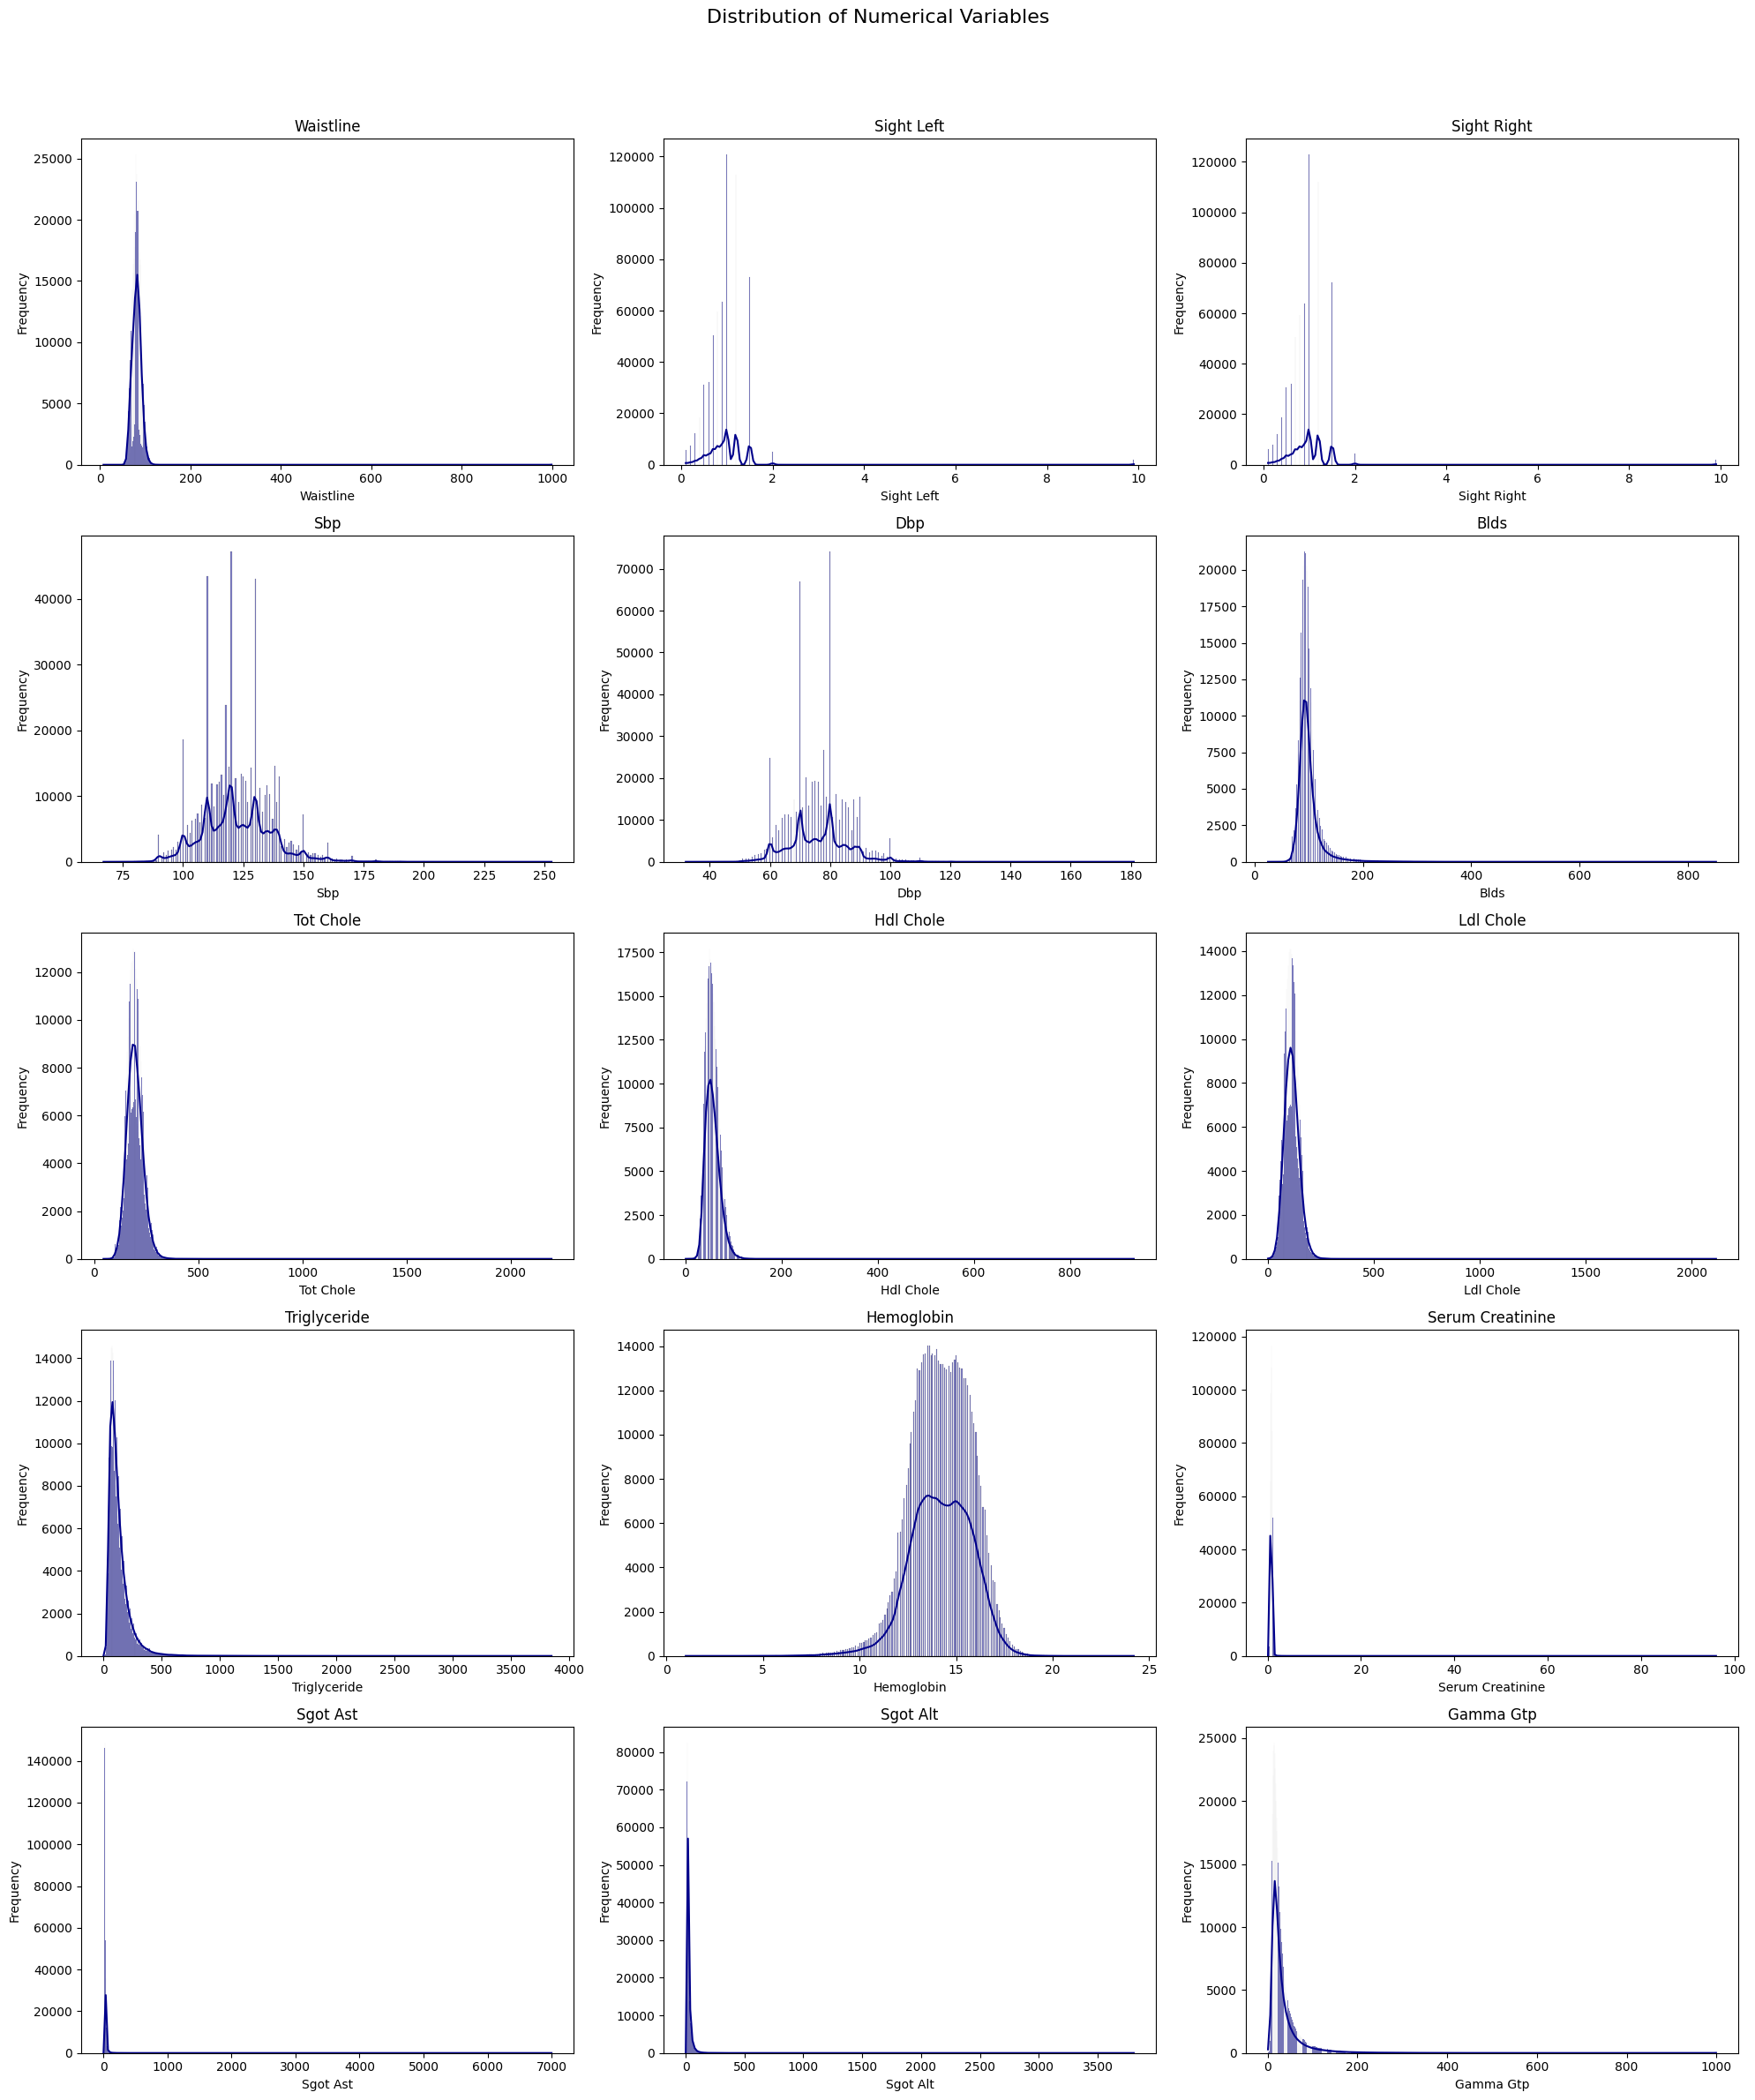

In [19]:
numerical_columns = ['waistline', 'sight_left', 'sight_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']

n_columns = 3
n_rows = (len(numerical_columns) + n_columns - 1) // n_columns

plt.figure(figsize = (20, n_rows * 5))
plt.suptitle('Distribution of Numerical Variables', fontsize = 16)

for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_columns, i + 1)
    sns.histplot(data = drinking_train, x = column, kde = True, color = 'darkblue')
    plt.title(f'{column.replace("_", " ").title()}')
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel('Frequency')

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

### Bivariate Analysis with Target (Numeric Variables)

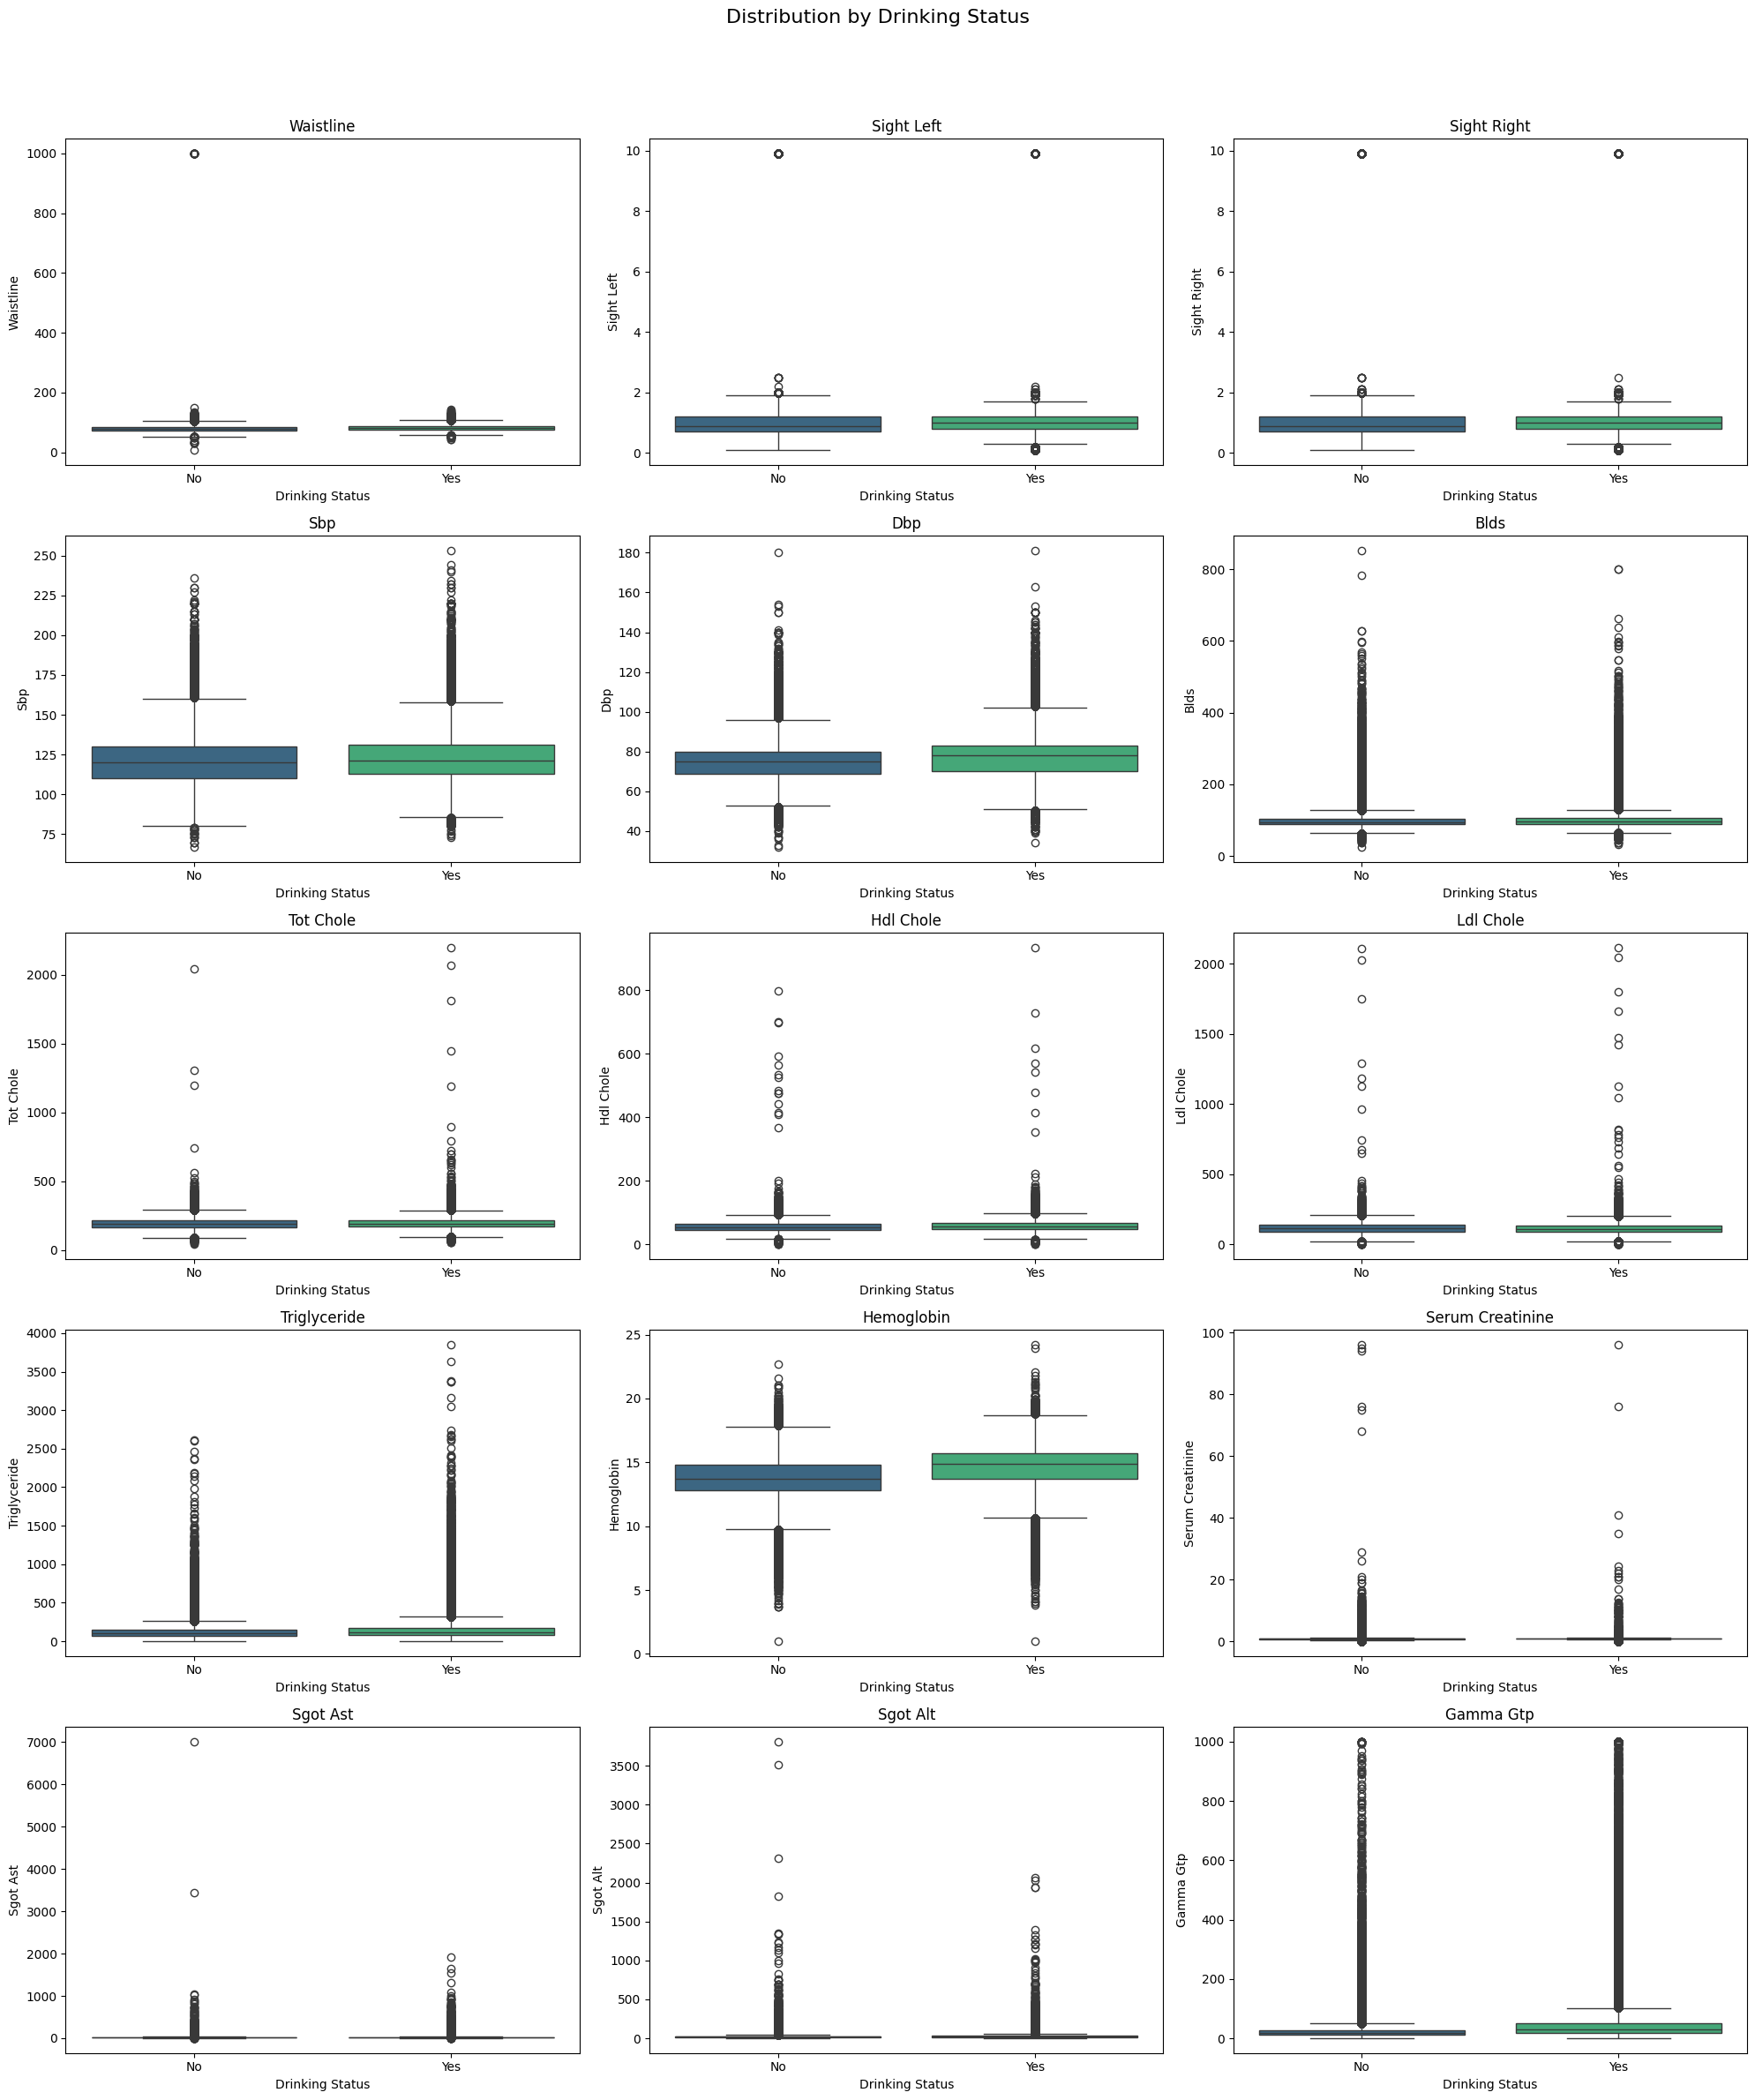

In [20]:
numerical_columns = ['waistline', 'sight_left', 'sight_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']

n_columns = 3
n_rows = (len(numerical_columns) + n_columns - 1) // n_columns

plt.figure(figsize = (20, n_rows * 5))
plt.suptitle('Distribution by Drinking Status', fontsize = 16)

for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_columns, i + 1)
    sns.boxplot(data = drinking_train, x = 'DRK_YN', y = column, palette = 'viridis', hue = 'DRK_YN', legend = False)
    plt.title(f'{column.replace("_", " ").title()}')
    plt.xlabel('Drinking Status')
    plt.ylabel(column.replace("_", " ").title())
    plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

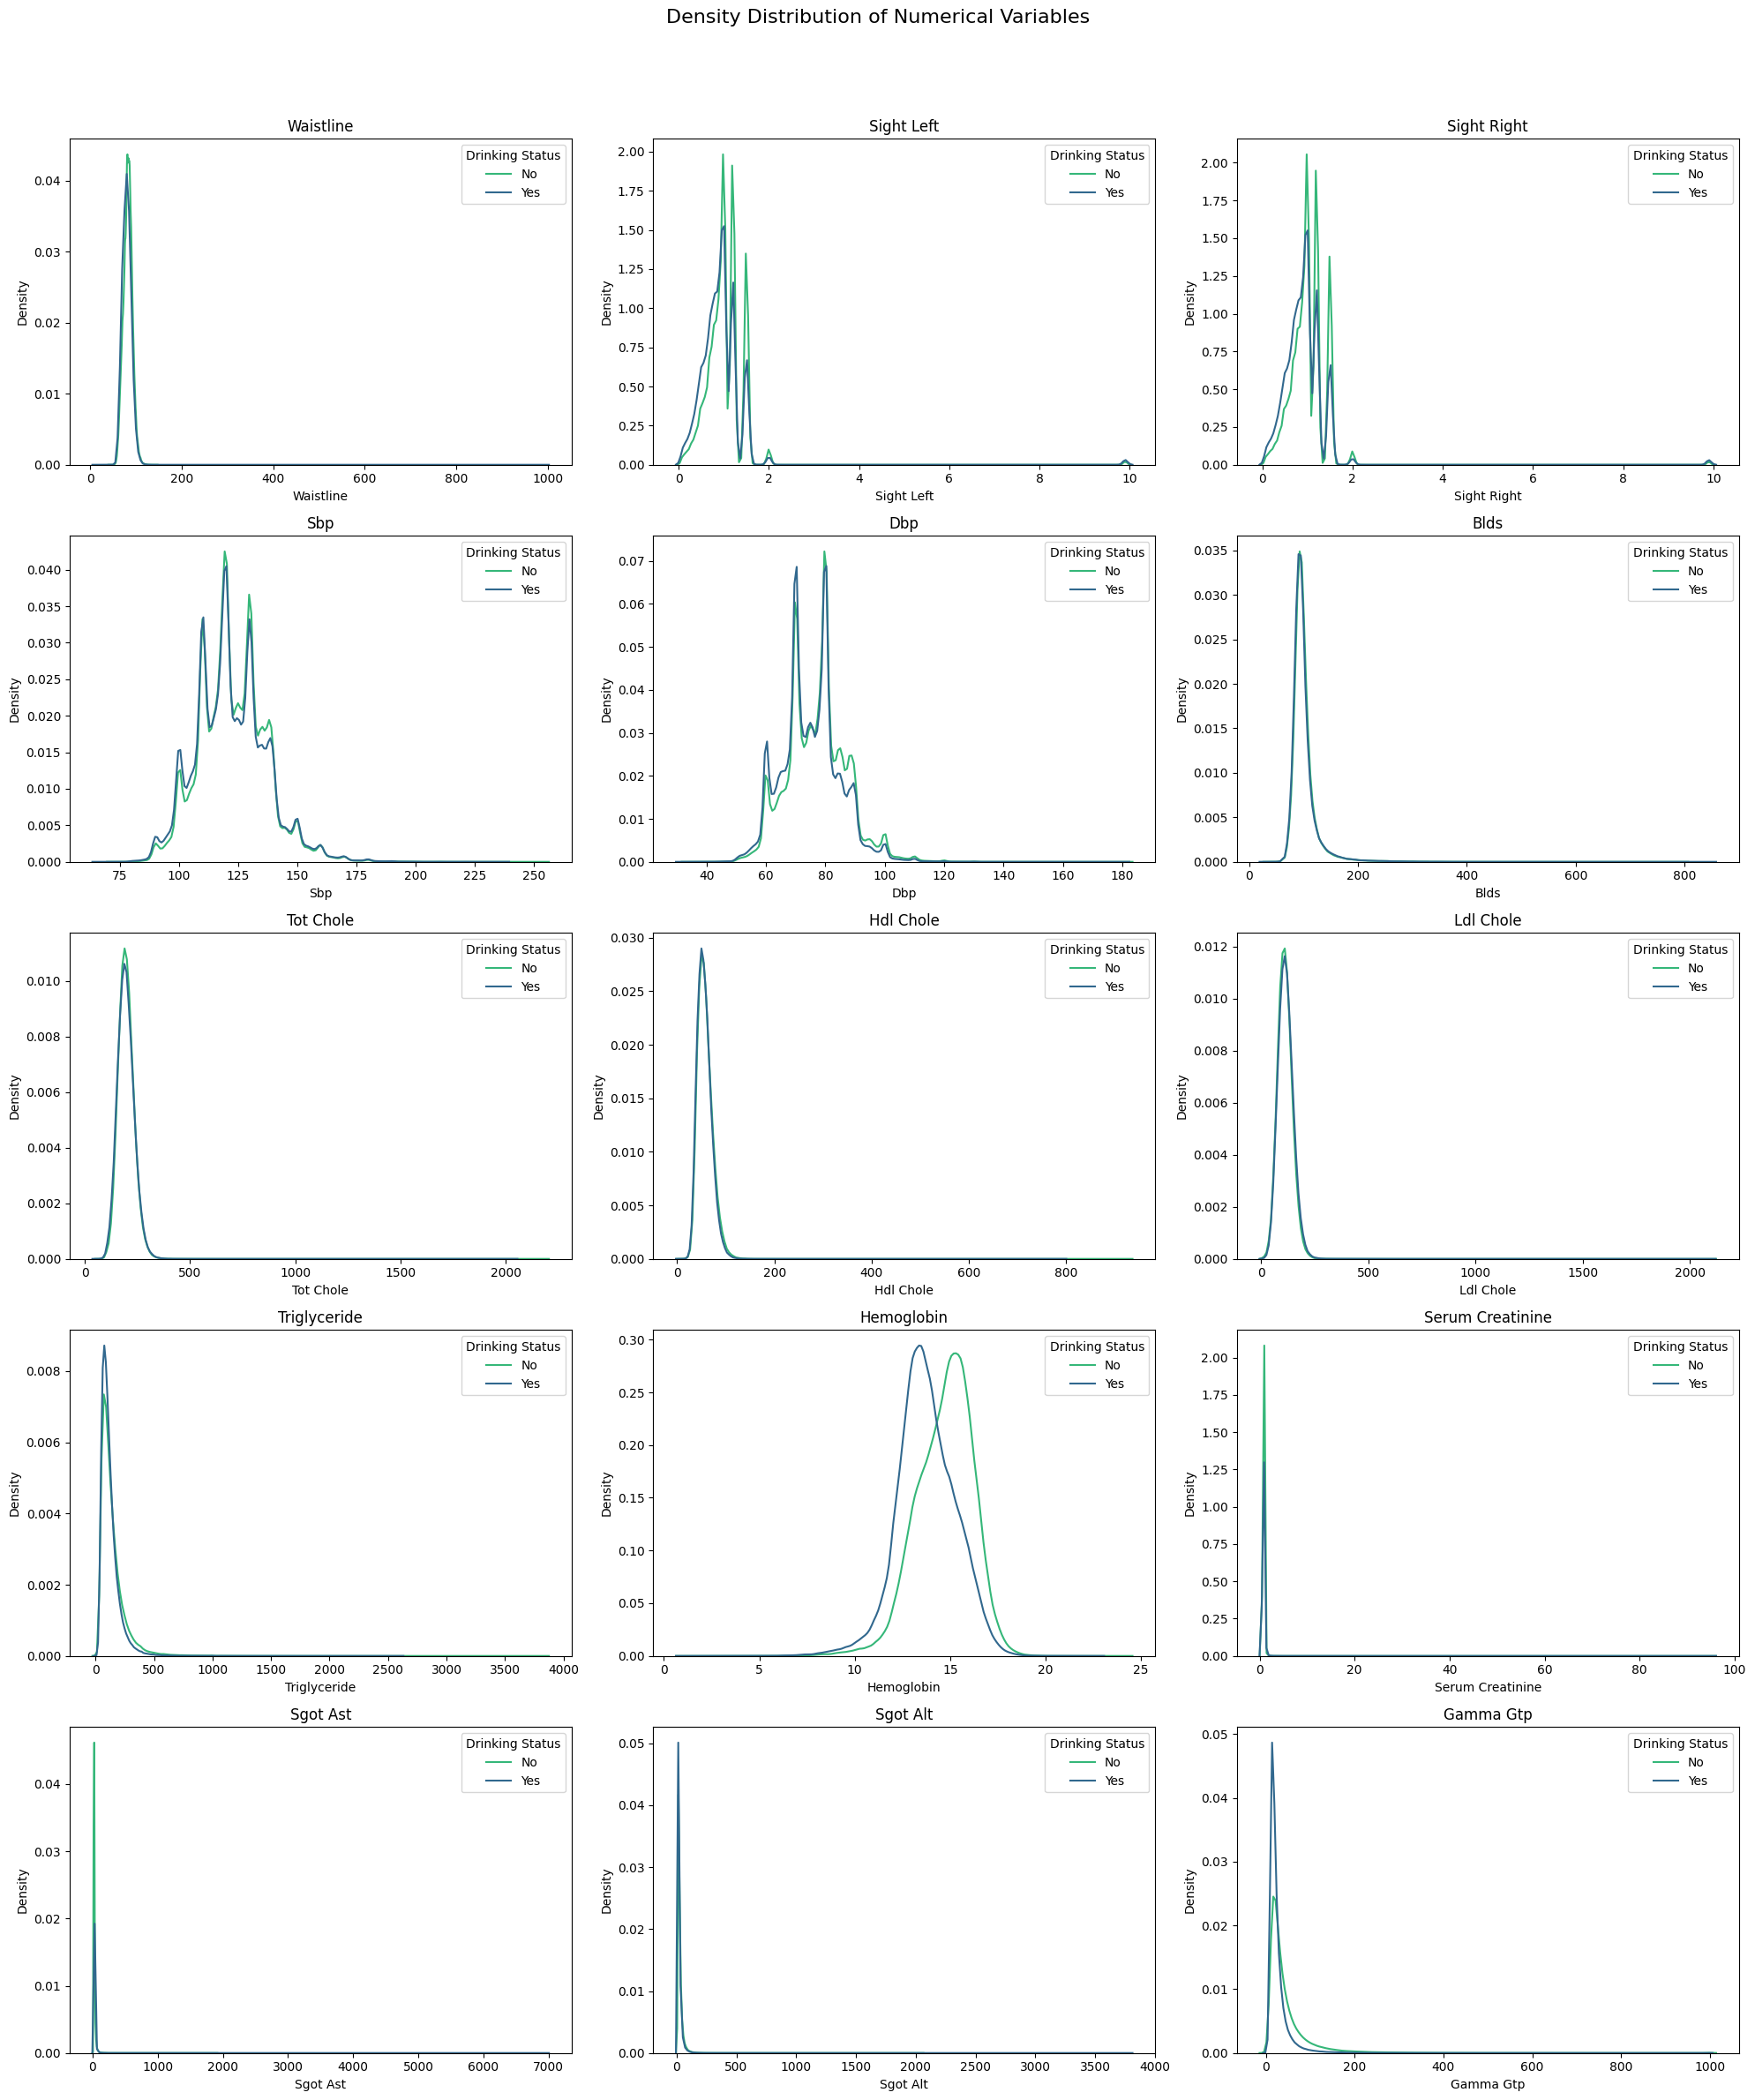

In [21]:
numerical_columns = ['waistline', 'sight_left', 'sight_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']

n_columns = 3
n_rows = (len(numerical_columns) + n_columns - 1) // n_columns

plt.figure(figsize = (20, n_rows * 5))
plt.suptitle('Density Distribution of Numerical Variables', fontsize = 16)

for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_columns, i + 1)
    sns.kdeplot(data = drinking_train, hue = 'DRK_YN', x = column, common_norm = False, palette = 'viridis')
    plt.title(f'{column.replace("_", " ").title()}')
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel('Density')
    plt.legend(title = 'Drinking Status', labels = ['No', 'Yes'])

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

### Bivariate Analysis with Target (Categorical Variables)

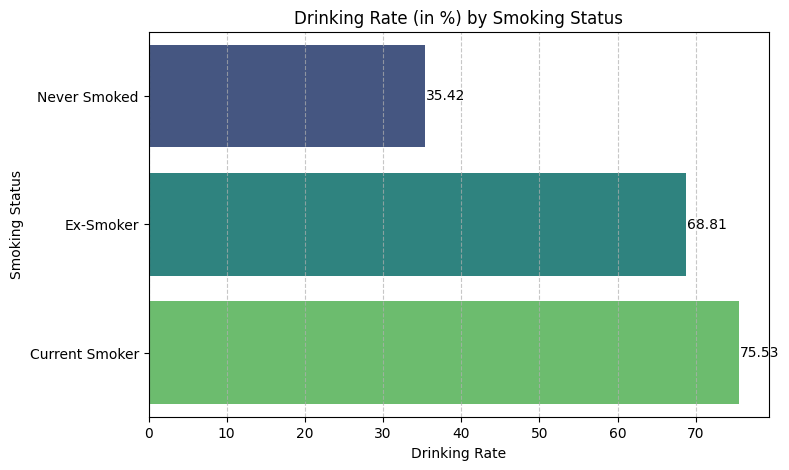

In [22]:
smoking_drinking = drinking_train.groupby('SMK_stat_type_cd')['DRK_YN'].agg(total = 'count', smoking_drinking = 'sum').reset_index()

smoking_drinking['drinking_rate'] = smoking_drinking['smoking_drinking'] / smoking_drinking['total'] * 100

smoking_map = {1: 'Never Smoked', 2: 'Ex-Smoker', 3: 'Current Smoker'}
smoking_drinking['smoking_status'] = (smoking_drinking['SMK_stat_type_cd'].map(smoking_map))

plt.figure(figsize = (8, 5))
sns.barplot(data = smoking_drinking, x = 'drinking_rate', y = 'smoking_status', palette = 'viridis', hue = 'smoking_status', legend = False)
plt.title('Drinking Rate (in %) by Smoking Status')
plt.xlabel('Drinking Rate')
plt.ylabel('Smoking Status')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(smoking_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

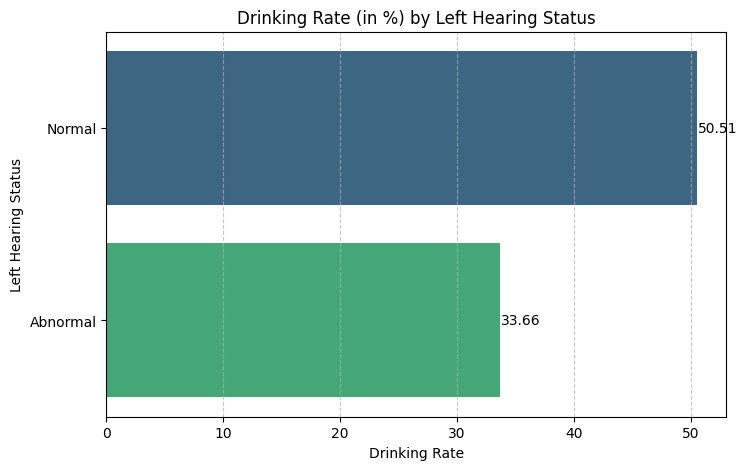

In [23]:
hearing_left_drinking = drinking_train.groupby('hear_left')['DRK_YN'].agg(
    total = 'count',
    hearing_drinking = 'sum'
).reset_index()

hearing_left_drinking['drinking_rate'] = hearing_left_drinking['hearing_drinking'] / hearing_left_drinking['total'] * 100

hearing_map = {1: 'Normal', 2: 'Abnormal'}
hearing_left_drinking['hearing_status'] = (hearing_left_drinking['hear_left'].map(hearing_map))

plt.figure(figsize = (8, 5))
sns.barplot(data = hearing_left_drinking, x = 'drinking_rate', y = 'hearing_status', palette = 'viridis', hue = 'hearing_status', legend = False)
plt.title('Drinking Rate (in %) by Left Hearing Status')
plt.xlabel('Drinking Rate')
plt.ylabel('Left Hearing Status')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(hearing_left_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

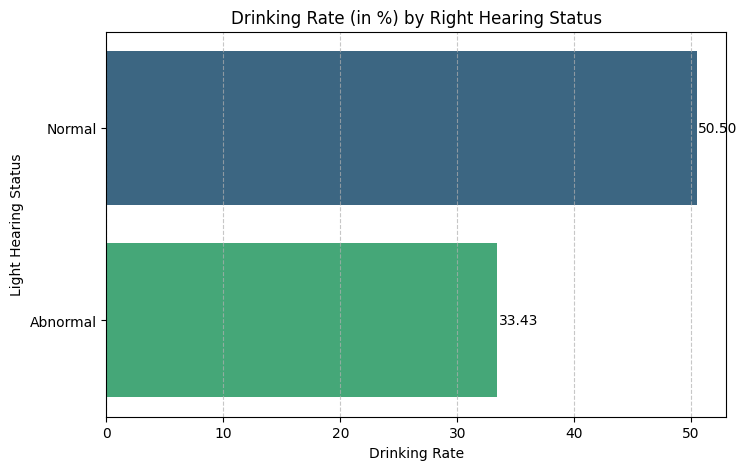

In [24]:
hearing_right_drinking = drinking_train.groupby('hear_right')['DRK_YN'].agg(
    total = 'count',
    hearing_drinking = 'sum'
).reset_index()

hearing_right_drinking['drinking_rate'] = hearing_right_drinking['hearing_drinking'] / hearing_right_drinking['total'] * 100

hearing_map = {1: 'Normal', 2: 'Abnormal'}
hearing_right_drinking['hearing_status'] = (hearing_right_drinking['hear_right'].map(hearing_map))

plt.figure(figsize = (8, 5))
sns.barplot(data = hearing_right_drinking, x = 'drinking_rate', y = 'hearing_status', palette = 'viridis', hue = 'hearing_status', legend = False)
plt.title('Drinking Rate (in %) by Right Hearing Status')
plt.xlabel('Drinking Rate')
plt.ylabel('Light Hearing Status')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(hearing_right_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

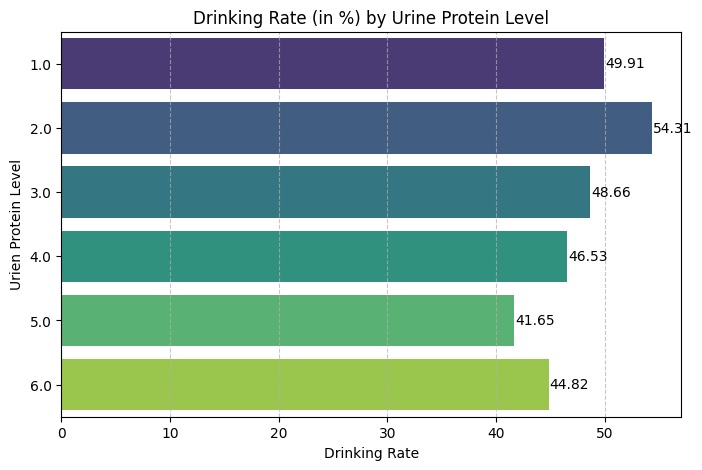

In [25]:
urine_drinking = drinking_train.groupby('urine_protein')['DRK_YN'].agg(
    total = 'count',
    protein_drinking = 'sum'
).reset_index()

urine_drinking['urine_protein'] = urine_drinking['urine_protein'].astype('category')
urine_drinking['drinking_rate'] = urine_drinking['protein_drinking'] / urine_drinking['total'] * 100

plt.figure(figsize = (8, 5))
sns.barplot(data = urine_drinking, x = 'drinking_rate', y = 'urine_protein', palette = 'viridis', hue = 'urine_protein', legend = False)
plt.title('Drinking Rate (in %) by Urine Protein Level')
plt.xlabel('Drinking Rate')
plt.ylabel('Urien Protein Level')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(urine_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

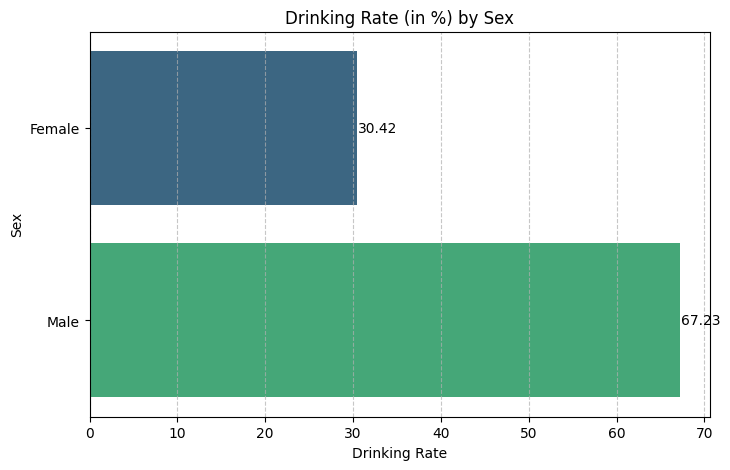

In [26]:
sex_drinking = drinking_train.groupby('sex')['DRK_YN'].agg(
    total = 'count',
    sex_drinking = 'sum'
).reset_index()

sex_drinking['drinking_rate'] = sex_drinking['sex_drinking'] / sex_drinking['total'] * 100

sex_map = {1: 'Male', 0: 'Female'}
sex_drinking['sex_status'] = (sex_drinking['sex'].map(sex_map))

plt.figure(figsize = (8, 5))
sns.barplot(data = sex_drinking, x = 'drinking_rate', y = 'sex_status', palette = 'viridis', hue = 'sex_status', legend = False)
plt.title('Drinking Rate (in %) by Sex')
plt.xlabel('Drinking Rate')
plt.ylabel('Sex')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(sex_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

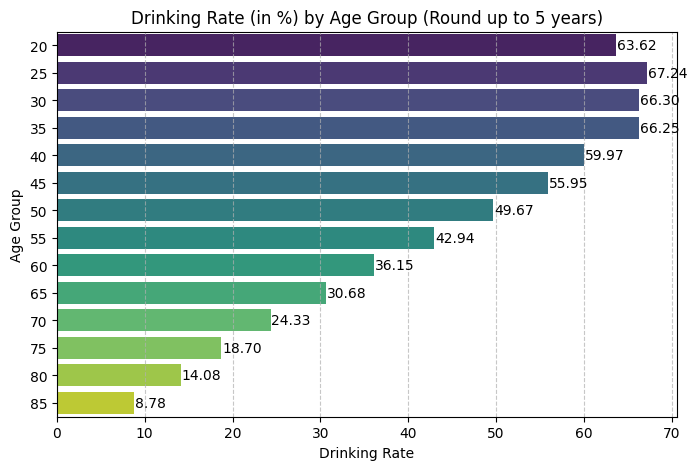

In [27]:
age_drinking = drinking_train.groupby('age')['DRK_YN'].agg(
    total = 'count',
    age_drinking = 'sum'
).reset_index()

age_drinking['age'] = age_drinking['age'].astype('category')
age_drinking['drinking_rate'] = age_drinking['age_drinking'] / age_drinking['total'] * 100

plt.figure(figsize = (8, 5))
sns.barplot(data = age_drinking, x = 'drinking_rate', y = 'age', palette = 'viridis', hue = 'age', legend = False)
plt.title('Drinking Rate (in %) by Age Group (Round up to 5 years)')
plt.xlabel('Drinking Rate')
plt.ylabel('Age Group')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(age_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

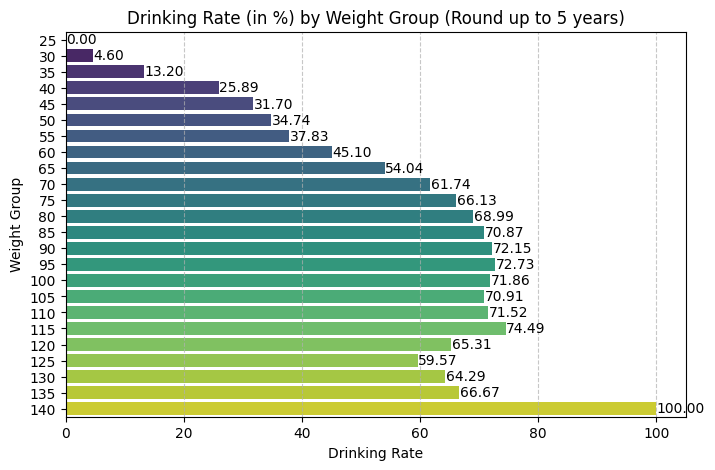

In [28]:
weight_drinking = drinking_train.groupby('weight')['DRK_YN'].agg(
    total = 'count',
    weight_drinking = 'sum'
).reset_index()

weight_drinking['weight'] = weight_drinking['weight'].astype('category')
weight_drinking['drinking_rate'] = weight_drinking['weight_drinking'] / weight_drinking['total'] * 100

plt.figure(figsize = (8, 5))
sns.barplot(data = weight_drinking, x = 'drinking_rate', y = 'weight', palette = 'viridis', hue = 'weight', legend = False)
plt.title('Drinking Rate (in %) by Weight Group (Round up to 5 years)')
plt.xlabel('Drinking Rate')
plt.ylabel('Weight Group')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(weight_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

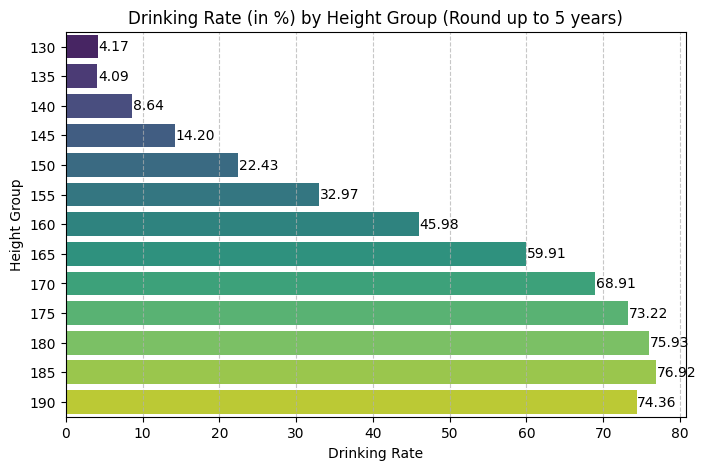

In [29]:
height_drinking = drinking_train.groupby('height')['DRK_YN'].agg(
    total = 'count',
    height_drinking = 'sum'
).reset_index()

height_drinking['height'] = height_drinking['height'].astype('category')
height_drinking['drinking_rate'] = height_drinking['height_drinking'] / height_drinking['total'] * 100

plt.figure(figsize = (8, 5))
sns.barplot(data = height_drinking, x = 'drinking_rate', y = 'height', palette = 'viridis', hue = 'height', legend = False)
plt.title('Drinking Rate (in %) by Height Group (Round up to 5 years)')
plt.xlabel('Drinking Rate')
plt.ylabel('Height Group')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(height_drinking['drinking_rate']):
    plt.text(value + 0.1, index, f'{value:.2f}', va = 'center')

plt.show()

# **Feature Selection**

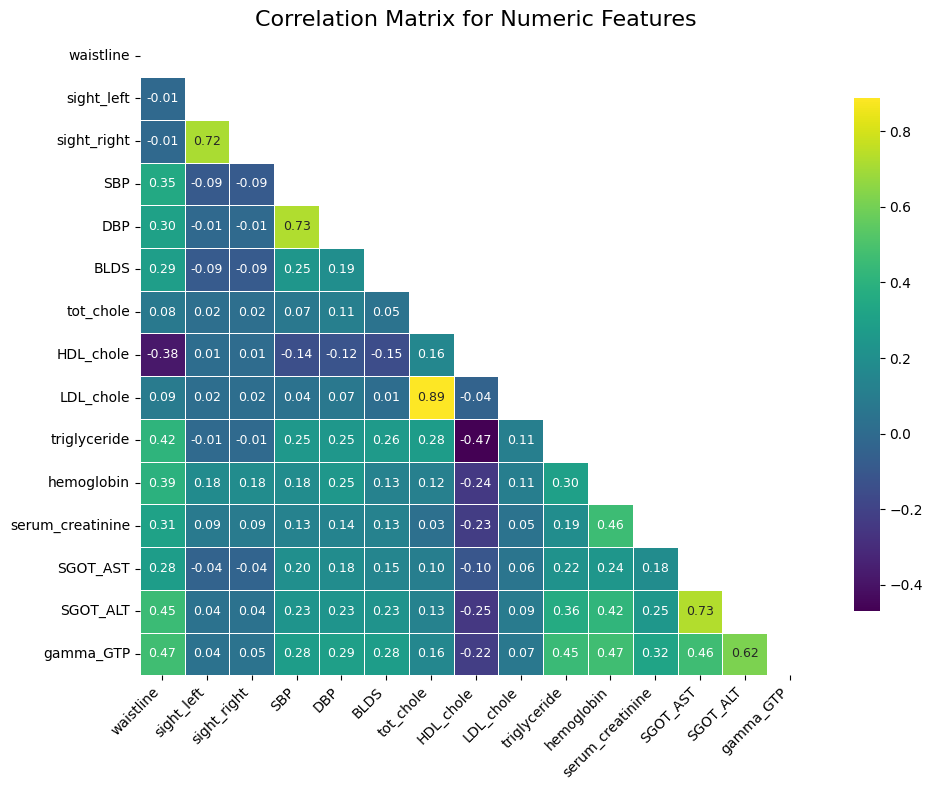

In [ ]:
# correlation for numeric features only
numerical_columns = ['waistline', 'sight_left', 'sight_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']
numerical_columns = [c for c in numerical_columns if c in drinking_train.columns]

correlation_method = "spearman" # spearman is used instead of pearson because of the high amount of outliers
correlation_matrix = drinking_train[numerical_columns].corr(method = correlation_method)

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (10, 8))
sns.heatmap(
    correlation_matrix,
    mask = mask,
    annot = True,
    fmt = ".2f",
    linewidths = .5,
    cmap = "viridis",
    cbar_kws = {"shrink": .8},
    annot_kws = {"size": 9}
)
plt.title(f"Correlation Matrix for Numeric Features", fontsize = 16)
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [31]:
# ANOVA for categorical target and continuous predictors
def anova(dataset, dep_var, con_vars):
    results = []

    for var in con_vars:
        model = smf.ols(f'{dep_var} ~ {var}', data = dataset).fit()

        anova_table = anova_lm(model)
        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]

        results.append([var, f_statistic, p_value])

    anova_results_df = pd.DataFrame(results, columns = ['Variable', 'F-statistic', 'p-value'])

    anova_results_df = anova_results_df.sort_values(by = 'F-statistic', ascending = False)

    return anova_results_df

In [ ]:
drinking_anova = anova(drinking_train, 'DRK_YN', numerical_columns)
print(drinking_anova)

# correlation between sight_left and sight_right is around 0.72, which likely measuring the same thing, and also high f-statistics for them, so maybe average them and drop them later
# SBP and DBP have high and low f-statistics, and high correlation around 0.73, and they are both clinically meaningful too, so keep both in such case
# tot_chole and LDL_chole have very high correlation (0.89) and one high and one low f-statistics which means one of them is the strongest redundancy, so in such case drop tot_chole
# SGOT_AST, SGOT_ALT, and gamma_GTP have Strong internal correlations but SGOT_AST has lowest f-statistics, so drop this variable and keep the rest

            Variable   F-statistic        p-value
10        hemoglobin  58249.772392   0.000000e+00
14         gamma_GTP  26240.085802   0.000000e+00
9       triglyceride   6700.933182   0.000000e+00
4                DBP   6136.600599   0.000000e+00
0          waistline   4999.097842   0.000000e+00
1         sight_left   3451.636421   0.000000e+00
2        sight_right   3345.419443   0.000000e+00
13          SGOT_ALT   2631.601806   0.000000e+00
11  serum_creatinine   2584.358365   0.000000e+00
7          HDL_chole   1419.402278  2.978408e-310
12          SGOT_AST   1206.338064  4.716090e-264
8          LDL_chole   1172.736101  9.155970e-257
3                SBP    643.495711  6.909442e-142
6          tot_chole    218.631054   1.835660e-49
5               BLDS    133.700796   6.400819e-31


In [33]:
# cramer's V matrix for categorical target and nominal variables
def cramers_v(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def calculate_cramers_v_matrix(dataset, cat_vars):
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_vars), len(cat_vars))),
                                    columns = cat_vars,
                                    index = cat_vars)

    for i in range(len(cat_vars)):
        for j in range(i, len(cat_vars)): 
            var_1 = cat_vars[i]
            var_2 = cat_vars[j]

            contingency_table = pd.crosstab(dataset[var_1], dataset[var_2])

            cramers_v_value = cramers_v(contingency_table)

            cramers_v_matrix.loc[var_1, var_2] = cramers_v_value
            cramers_v_matrix.loc[var_2, var_1] = cramers_v_value  

    return cramers_v_matrix

In [ ]:
nominal_columns_with_target = ['sex', 'hear_left', 'hear_right', 'DRK_YN']
drinking_cramersv = calculate_cramers_v_matrix(drinking_train, nominal_columns_with_target)
print(drinking_cramersv)

# < 0.1 usually means very weak association
# > 0.5 usually means strong association
# the rest in between is moderate or weak-moderate association
# in such case sex is meaningfully associated with drinking but hearing variables are almost unrelated to drinking

                 sex  hear_left  hear_right    DRK_YN
sex         0.999997   0.003292    0.000793  0.367374
hear_left   0.003292   0.999972    0.537750  0.058717
hear_right  0.000793   0.537750    0.999971  0.058452
DRK_YN      0.367374   0.058717    0.058452  0.999997


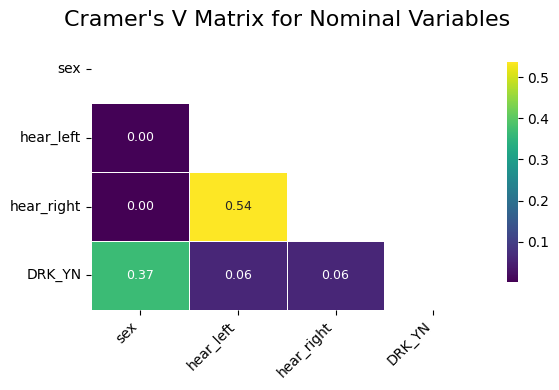

In [35]:
mask = np.triu(np.ones_like(drinking_cramersv, dtype = bool))

plt.figure(figsize = (6, 4))
sns.heatmap(
    drinking_cramersv,
    mask = mask,
    annot = True,
    fmt = ".2f",
    linewidths = .5,
    cmap = "viridis",
    cbar_kws = {"shrink": .8},
    annot_kws = {"size": 9})
plt.title(f"Cramer's V Matrix for Nominal Variables", fontsize = 16)
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

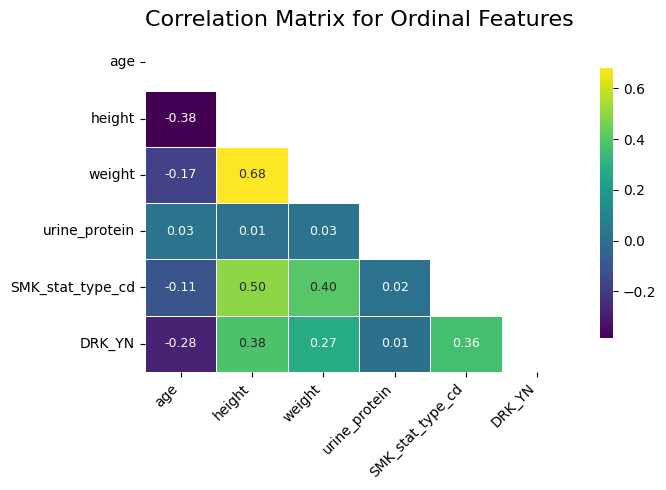

In [ ]:
# correlation for categorical target and ordinal variables
ordinal_columns_with_target = ['age', 'height', 'weight', 'urine_protein', 'SMK_stat_type_cd', 'DRK_YN']
ordinal_columns_with_target = [c for c in ordinal_columns_with_target if c in drinking_train.columns]

correlation_method = "spearman"
correlation_matrix = drinking_train[ordinal_columns_with_target].corr(method = correlation_method)

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (7, 5))
sns.heatmap(
    correlation_matrix,
    mask = mask,
    annot = True,
    fmt = ".2f",
    linewidths = .5,
    cmap = "viridis",
    cbar_kws = {"shrink": .8},
    annot_kws = {"size": 9})
plt.title(f"Correlation Matrix for Ordinal Features", fontsize = 16)
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

# < 0.1 usually means very weak association
# > 0.5 usually means strong association
# smoking status is a strong ordinal predictor, and age, height, weight show meaningful trends, and urine protein shows no relationship to drinking

In [ ]:
# variables to drop
drinking_train = drinking_train.drop(['hear_left'], axis = 1)
drinking_validation = drinking_validation.drop(['hear_left'], axis = 1)
drinking_test = drinking_test.drop(['hear_left'], axis = 1)

drinking_train = drinking_train.drop(['hear_right'], axis = 1)
drinking_validation = drinking_validation.drop(['hear_right'], axis = 1)
drinking_test = drinking_test.drop(['hear_right'], axis = 1)

drinking_train = drinking_train.drop(['urine_protein'], axis = 1)
drinking_validation = drinking_validation.drop(['urine_protein'], axis = 1)
drinking_test = drinking_test.drop(['urine_protein'], axis = 1)

drinking_train = drinking_train.drop(['tot_chole'], axis = 1)
drinking_validation = drinking_validation.drop(['tot_chole'], axis = 1)
drinking_test = drinking_test.drop(['tot_chole'], axis = 1)

drinking_train = drinking_train.drop(['SGOT_AST'], axis = 1)
drinking_validation = drinking_validation.drop(['SGOT_AST'], axis = 1)
drinking_test = drinking_test.drop(['SGOT_AST'], axis = 1)

# **Feature Engineering**

In [38]:
numerical_columns = ['waistline', 'sight_left', 'sight_right', 'SBP', 'DBP', 'BLDS', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_ALT', 'gamma_GTP']
numerical_columns = [c for c in numerical_columns if c in drinking_train.columns]

skewness = drinking_train[numerical_columns].skew().sort_values(ascending = False)
print(skewness)
print('')
# skewness > 1 or < -1 means highly skewed, thus consider log transform
# highly skewed features can benefit from normalization or transformations

variance = drinking_train[numerical_columns].var().sort_values(ascending = False)
print(variance)
# low variance potentially noise or redundant, no predictive power

serum_creatinine    107.561259
waistline            26.986897
SGOT_ALT             25.945303
sight_right          10.035996
sight_left            9.992069
gamma_GTP             7.713109
triglyceride          5.029217
BLDS                  4.682663
LDL_chole             2.519068
HDL_chole             2.338764
SBP                   0.484987
DBP                   0.400067
hemoglobin           -0.383752
dtype: float64

triglyceride        10155.525981
gamma_GTP            2552.883778
LDL_chole            1257.820299
SGOT_ALT              592.133177
BLDS                  588.409575
HDL_chole             231.900363
SBP                   211.706266
waistline             141.907806
DBP                    98.062709
hemoglobin              2.507156
sight_left              0.370359
sight_right             0.365759
serum_creatinine        0.191379
dtype: float64


### For serum_creatinine

In [39]:
drinking_train['serum_creatinine_log'] = np.log(drinking_train['serum_creatinine'])
log_skew = skew(drinking_train['serum_creatinine_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 0.2125


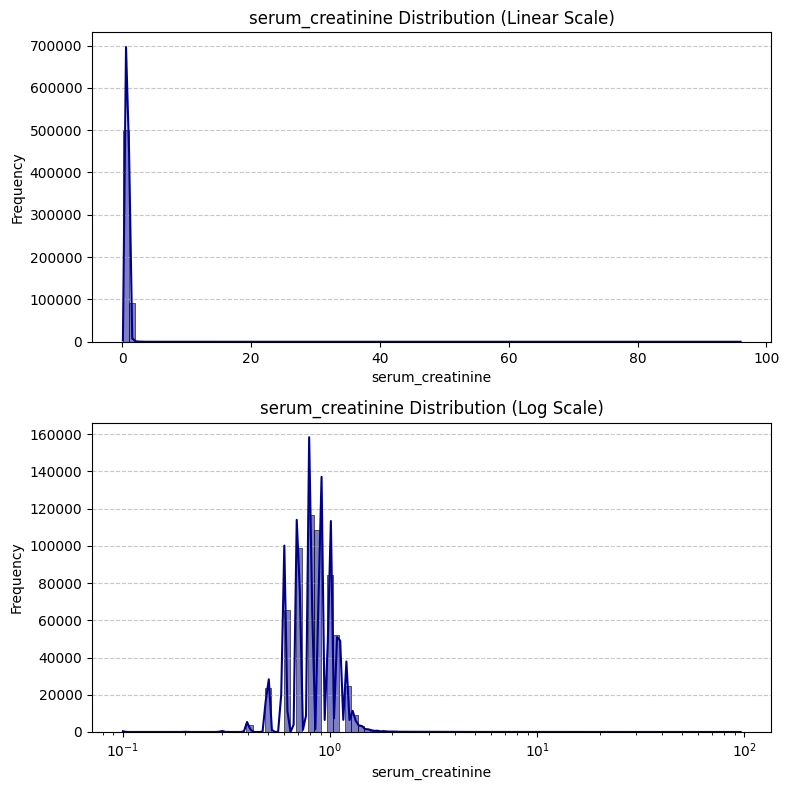

In [40]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'serum_creatinine',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("serum_creatinine Distribution (Linear Scale)")
axes[0].set_xlabel('serum_creatinine')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'serum_creatinine',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("serum_creatinine Distribution (Log Scale)")
axes[1].set_xlabel('serum_creatinine')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [41]:
drinking_validation['serum_creatinine_log'] = np.log(drinking_validation['serum_creatinine'])
drinking_test['serum_creatinine_log'] = np.log(drinking_test['serum_creatinine'])

### For waistline

In [42]:
drinking_train['waistline_log'] = np.log(drinking_train['waistline'])
log_skew = skew(drinking_train['waistline_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 0.3532


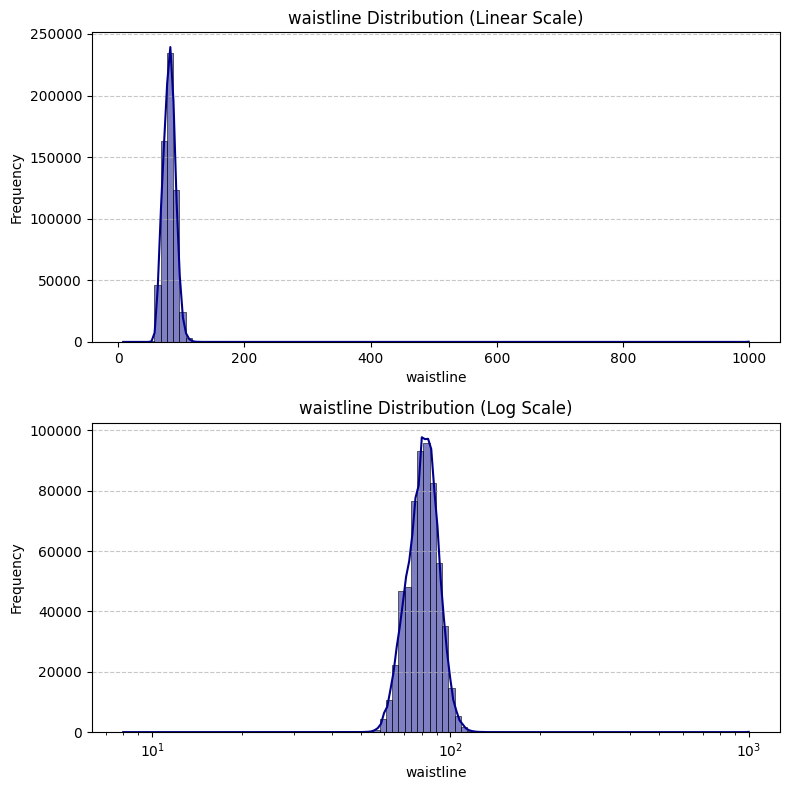

In [43]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'waistline',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("waistline Distribution (Linear Scale)")
axes[0].set_xlabel('waistline')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'waistline',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("waistline Distribution (Log Scale)")
axes[1].set_xlabel('waistline')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [44]:
drinking_validation['waistline_log'] = np.log(drinking_validation['waistline'])
drinking_test['waistline_log'] = np.log(drinking_test['waistline'])

### For SGOT_ALT

In [45]:
drinking_train['SGOT_ALT_log'] = np.log(drinking_train['SGOT_ALT'])
log_skew = skew(drinking_train['SGOT_ALT_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 0.6860


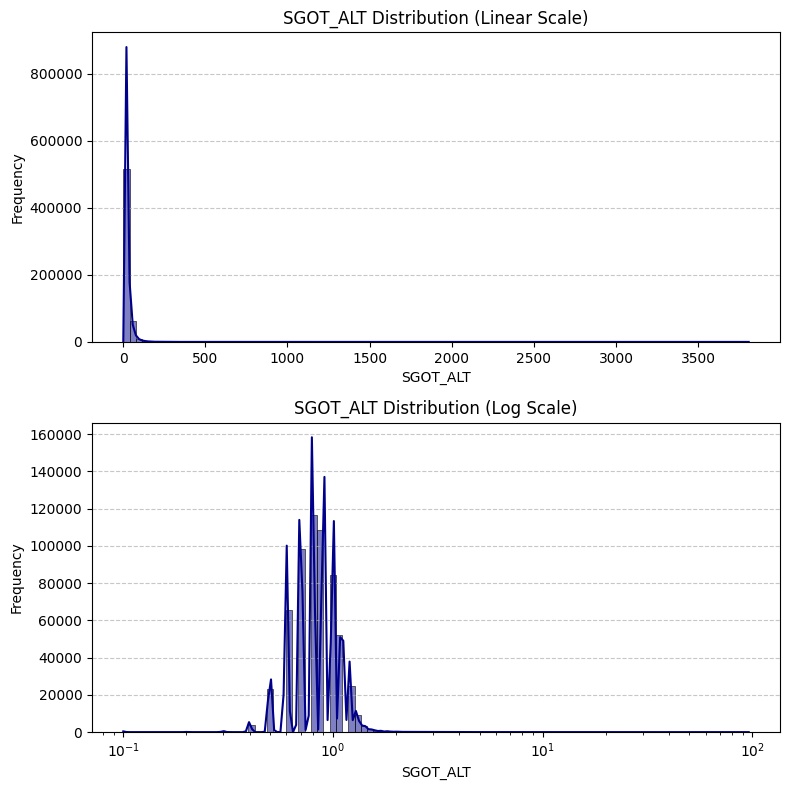

In [46]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'SGOT_ALT',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("SGOT_ALT Distribution (Linear Scale)")
axes[0].set_xlabel('SGOT_ALT')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'serum_creatinine',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("SGOT_ALT Distribution (Log Scale)")
axes[1].set_xlabel('SGOT_ALT')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [47]:
drinking_validation['SGOT_ALT_log'] = np.log(drinking_validation['SGOT_ALT'])
drinking_test['SGOT_ALT_log'] = np.log(drinking_test['SGOT_ALT'])

### For gamma_GTP

In [48]:
drinking_train['gamma_GTP_log'] = np.log(drinking_train['gamma_GTP'])
log_skew = skew(drinking_train['gamma_GTP_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 0.9530


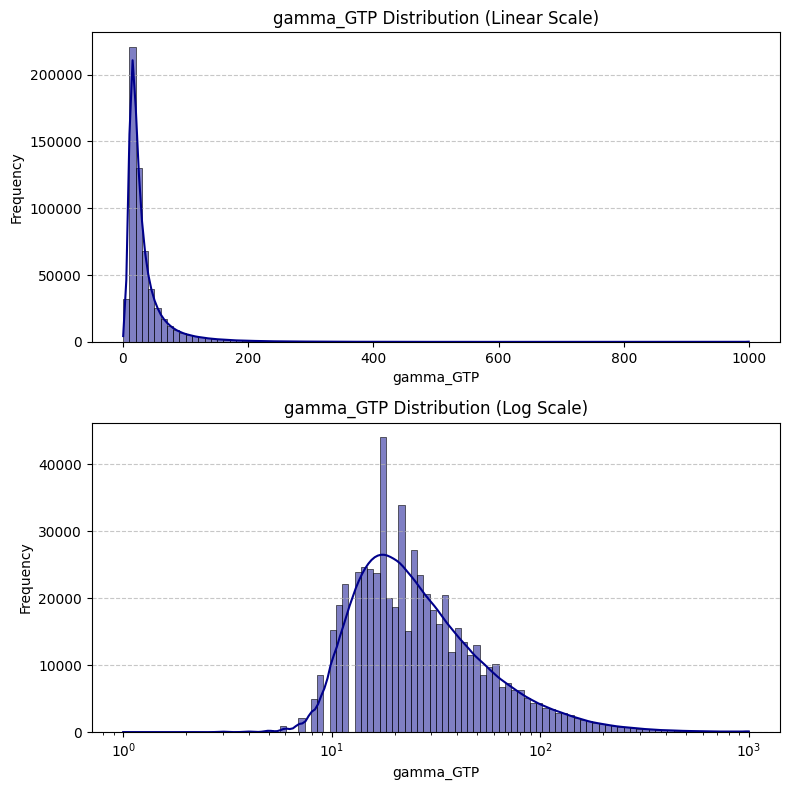

In [49]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'gamma_GTP',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("gamma_GTP Distribution (Linear Scale)")
axes[0].set_xlabel('gamma_GTP')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'gamma_GTP',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("gamma_GTP Distribution (Log Scale)")
axes[1].set_xlabel('gamma_GTP')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [50]:
drinking_validation['gamma_GTP_log'] = np.log(drinking_validation['gamma_GTP'])
drinking_test['gamma_GTP_log'] = np.log(drinking_test['gamma_GTP'])

### For triglyceride

In [51]:
drinking_train['triglyceride_log'] = np.log(drinking_train['triglyceride'])
log_skew = skew(drinking_train['triglyceride_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 0.3972


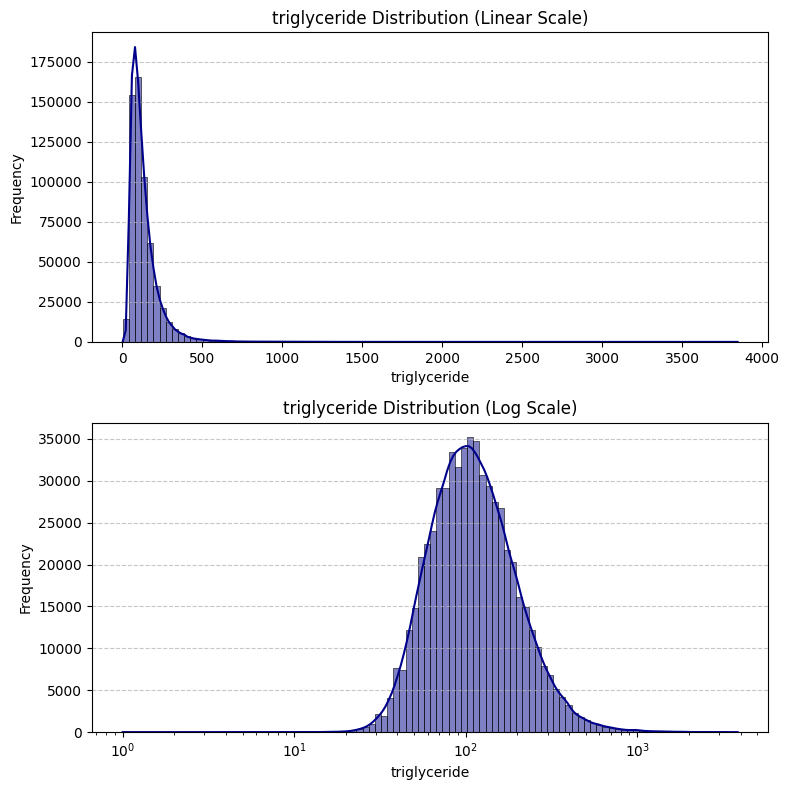

In [52]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'triglyceride',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("triglyceride Distribution (Linear Scale)")
axes[0].set_xlabel('triglyceride')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'triglyceride',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("triglyceride Distribution (Log Scale)")
axes[1].set_xlabel('triglyceride')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [53]:
drinking_validation['triglyceride_log'] = np.log(drinking_validation['triglyceride'])
drinking_test['triglyceride_log'] = np.log(drinking_test['triglyceride'])

### For BLDS

In [54]:
drinking_train['BLDS_log'] = np.log(drinking_train['BLDS'])
log_skew = skew(drinking_train['BLDS_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 2.0315


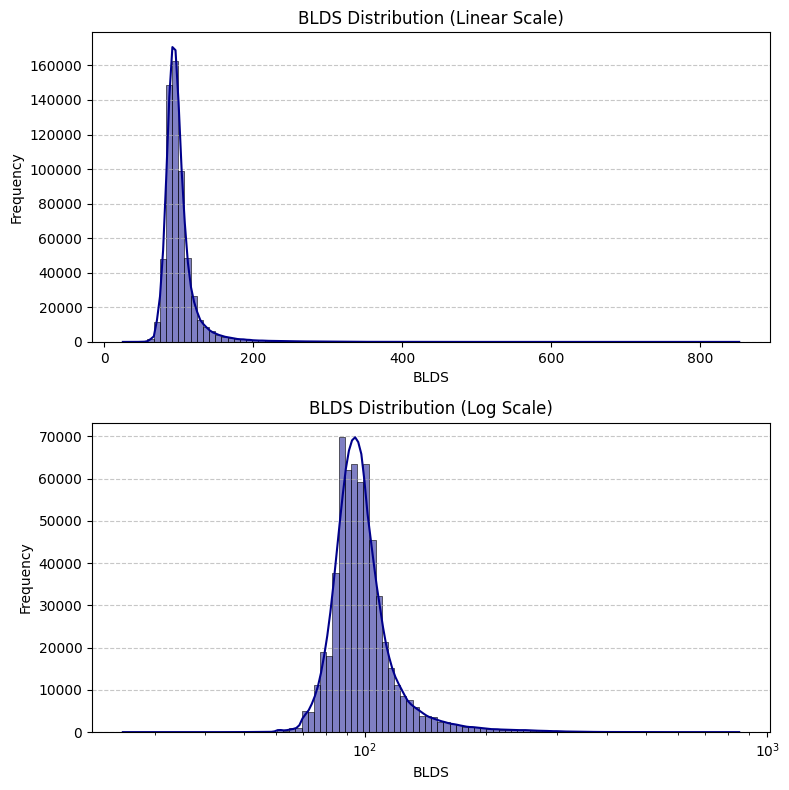

In [55]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'BLDS',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("BLDS Distribution (Linear Scale)")
axes[0].set_xlabel('BLDS')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'BLDS',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("BLDS Distribution (Log Scale)")
axes[1].set_xlabel('BLDS')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [56]:
drinking_validation['BLDS_log'] = np.log(drinking_validation['BLDS'])
drinking_test['BLDS_log'] = np.log(drinking_test['BLDS'])

### For LDL_chole

In [57]:
drinking_train['LDL_chole_log'] = np.log(drinking_train['LDL_chole'])
log_skew = skew(drinking_train['LDL_chole_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: -1.0847


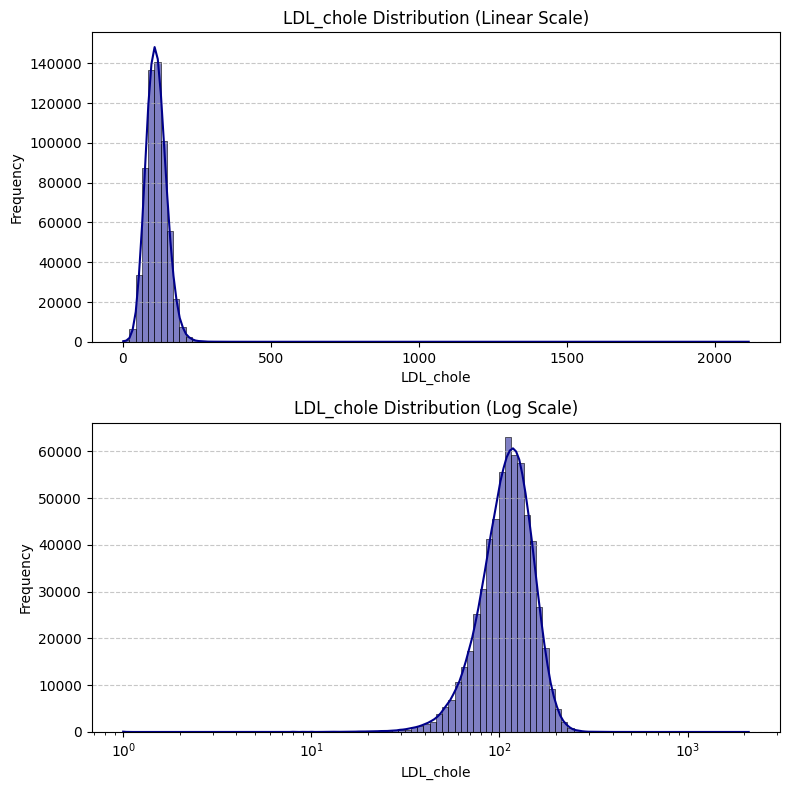

In [58]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'LDL_chole',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("LDL_chole Distribution (Linear Scale)")
axes[0].set_xlabel('LDL_chole')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'LDL_chole',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("LDL_chole Distribution (Log Scale)")
axes[1].set_xlabel('LDL_chole')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [59]:
drinking_validation['LDL_chole_log'] = np.log(drinking_validation['LDL_chole'])
drinking_test['LDL_chole_log'] = np.log(drinking_test['LDL_chole'])

### For HDL_chole

In [60]:
drinking_train['HDL_chole_log'] = np.log(drinking_train['HDL_chole'])
log_skew = skew(drinking_train['HDL_chole_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: -0.0610


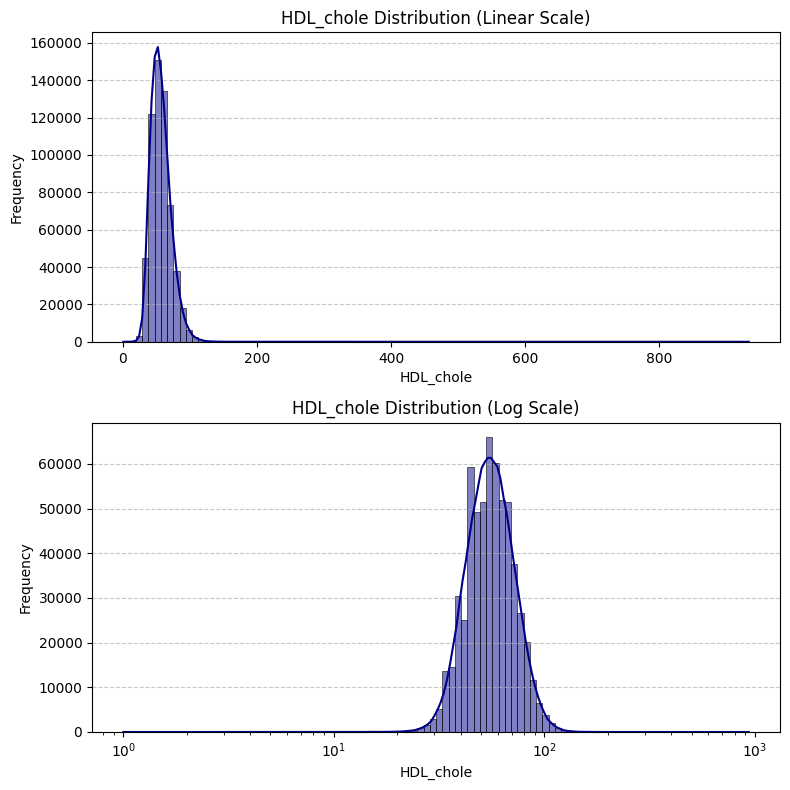

In [61]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'HDL_chole',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("HDL_chole Distribution (Linear Scale)")
axes[0].set_xlabel('HDL_chole')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'HDL_chole',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("HDL_chole Distribution (Log Scale)")
axes[1].set_xlabel('HDL_chole')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [62]:
drinking_validation['HDL_chole_log'] = np.log(drinking_validation['HDL_chole'])
drinking_test['HDL_chole_log'] = np.log(drinking_test['HDL_chole'])

### For SBP

In [63]:
drinking_train['SBP_log'] = np.log(drinking_train['SBP'])
log_skew = skew(drinking_train['SBP_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: 0.0544


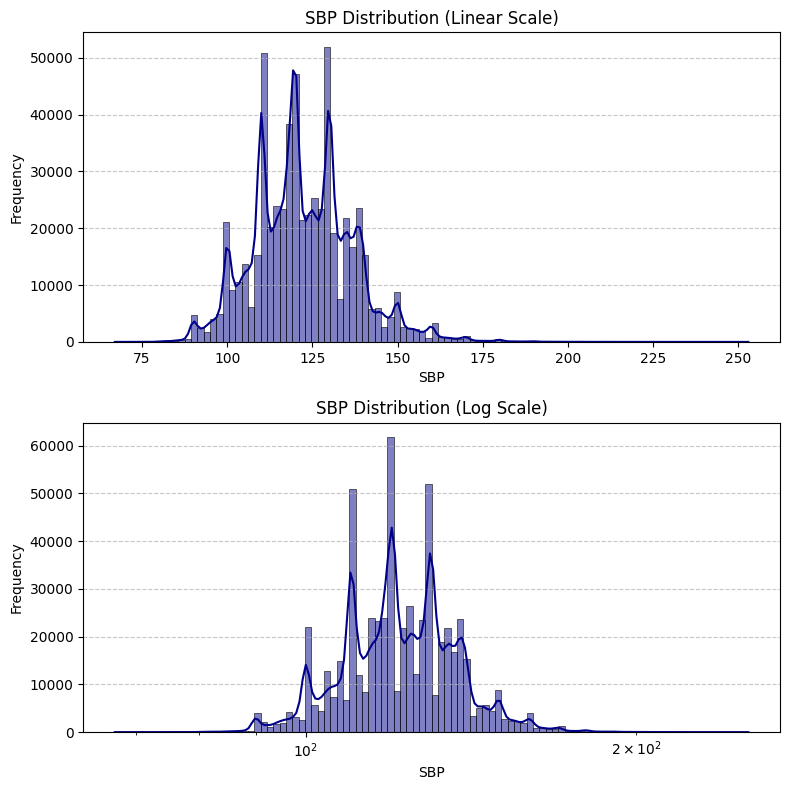

In [64]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'SBP',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("SBP Distribution (Linear Scale)")
axes[0].set_xlabel('SBP')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'SBP',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("SBP Distribution (Log Scale)")
axes[1].set_xlabel('SBP')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [65]:
drinking_validation['SBP_log'] = np.log(drinking_validation['SBP'])
drinking_test['SBP_log'] = np.log(drinking_test['SBP'])

### For DBP

In [66]:
drinking_train['DBP_log'] = np.log(drinking_train['DBP'])
log_skew = skew(drinking_train['DBP_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: -0.0617


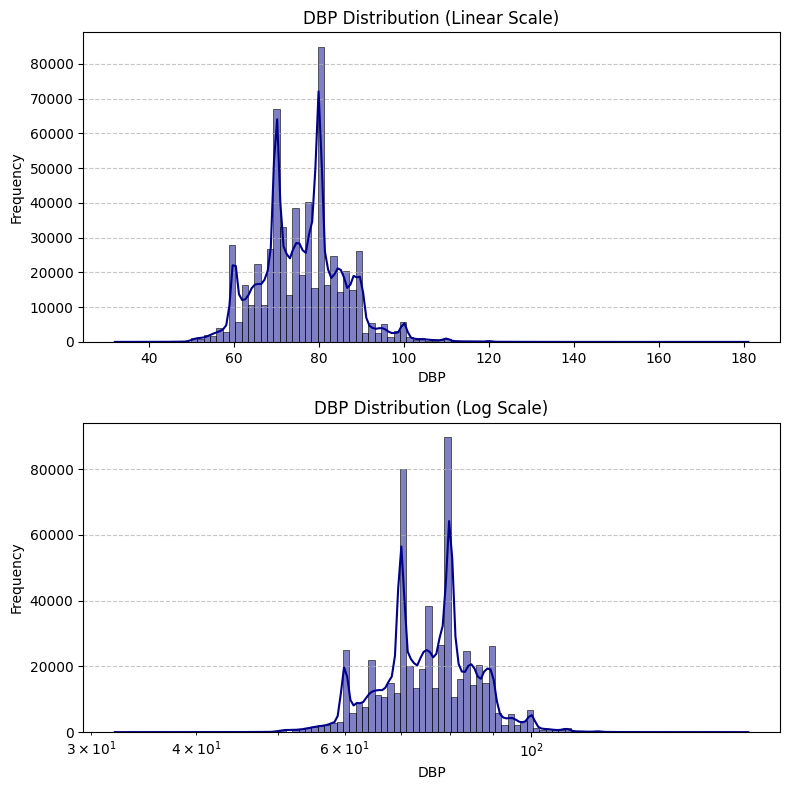

In [67]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'DBP',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("DBP Distribution (Linear Scale)")
axes[0].set_xlabel('DBP')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'DBP',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("DBP Distribution (Log Scale)")
axes[1].set_xlabel('DBP')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [68]:
drinking_validation['DBP_log'] = np.log(drinking_validation['DBP'])
drinking_test['DBP_log'] = np.log(drinking_test['DBP'])

### For hemoglobin

In [69]:
drinking_train['hemoglobin_log'] = np.log(drinking_train['hemoglobin'])
log_skew = skew(drinking_train['hemoglobin_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: -1.0043


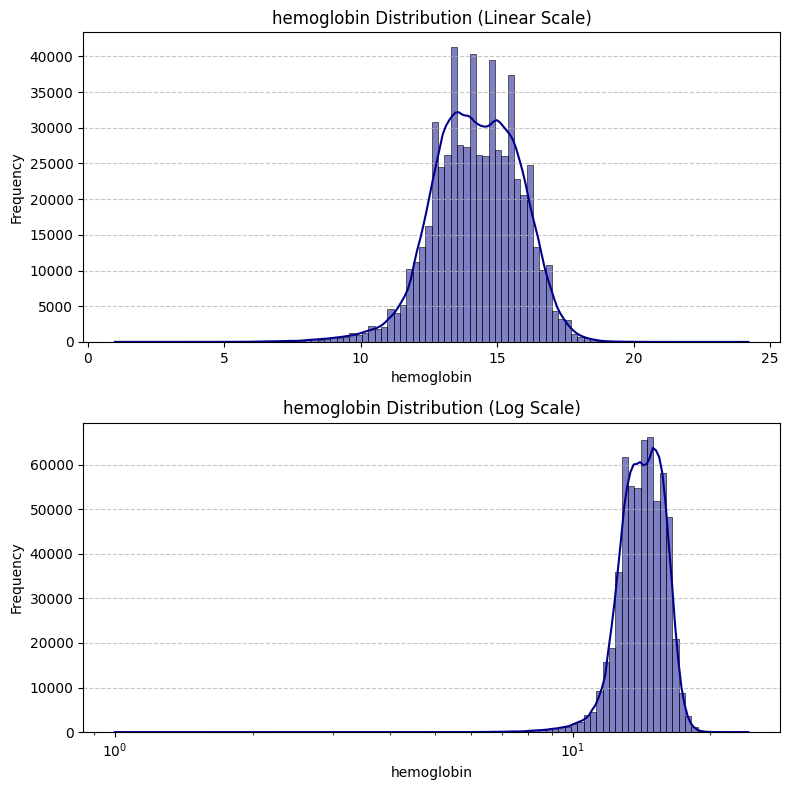

In [70]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'hemoglobin',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("hemoglobin Distribution (Linear Scale)")
axes[0].set_xlabel('hemoglobin')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'hemoglobin',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("hemoglobin Distribution (Log Scale)")
axes[1].set_xlabel('hemoglobin')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [71]:
drinking_validation['hemoglobin_log'] = np.log(drinking_validation['hemoglobin'])
drinking_test['hemoglobin_log'] = np.log(drinking_test['hemoglobin'])

### For sight_left and sight_right

In [72]:
drinking_train['sight_average'] = drinking_train[['sight_left', 'sight_right']].mean(axis = 1)
drinking_train[['sight_left', 'sight_right', 'sight_average']].head()

sight_left  sight_right  sight_average
741387         0.8          0.7           0.75
325647         0.7          0.6           0.65
837448         1.2          1.2           1.20
946952         1.5          1.5           1.50
961431         1.0          1.0           1.00

In [73]:
drinking_train['sight_average_log'] = np.log(drinking_train['sight_average'])
log_skew = skew(drinking_train['sight_average_log'])
print(f"Log Skewness: {log_skew:.4f}")

Log Skewness: -0.7847


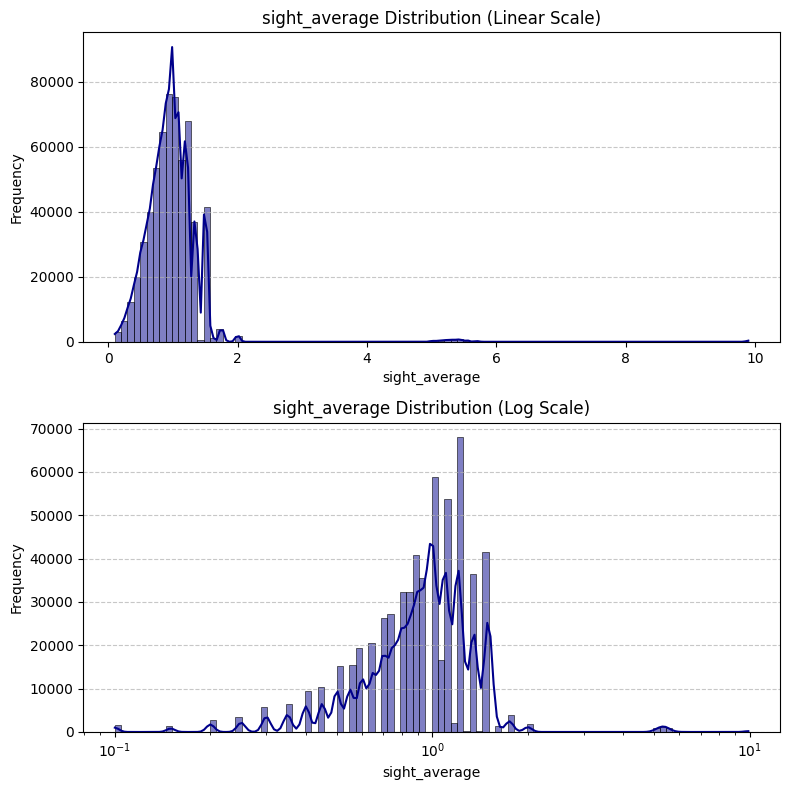

In [74]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

sns.histplot(
    data = drinking_train,
    x = 'sight_average',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("sight_average Distribution (Linear Scale)")
axes[0].set_xlabel('sight_average')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = drinking_train,
    x = 'sight_average',
    bins = 100, 
    kde = True, 
    color = 'darkblue',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("sight_average Distribution (Log Scale)")
axes[1].set_xlabel('sight_average')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [75]:
drinking_validation['sight_average'] = drinking_validation[['sight_left', 'sight_right']].mean(axis = 1)
drinking_test['sight_average'] = drinking_test[['sight_left', 'sight_right']].mean(axis = 1)

drinking_validation['sight_average_log'] = np.log(drinking_validation['sight_average'])
drinking_test['sight_average_log'] = np.log(drinking_test['sight_average'])

## Finalizing Data

In [76]:
columns_to_drop = [
    'serum_creatinine',
    'waistline',
    'SGOT_ALT',
    'sight_right',
    'sight_left',
    'gamma_GTP',
    'triglyceride',
    'BLDS',
    'LDL_chole',
    'HDL_chole',
    'SBP',
    'DBP',
    'sight_average',
    'hemoglobin']

for df in [drinking_train, drinking_validation, drinking_test]:
    df.drop(columns = [c for c in columns_to_drop if c in df.columns], inplace = True)

In [77]:
print(drinking_train.shape)
print(drinking_validation.shape)
print(drinking_test.shape)

(594806, 18)
(198270, 18)
(198269, 18)


In [78]:
drinking_train_finalized = drinking_train.copy()
drinking_validation_finalized = drinking_validation.copy()
drinking_test_finalized = drinking_test.copy()

In [79]:
drinking_train_finalized.head()

sex  age  height  weight  SMK_stat_type_cd  DRK_YN  \
741387    0   40     165      50               1.0       0   
325647    0   45     155      45               1.0       0   
837448    1   35     175      60               1.0       0   
946952    0   40     160      60               1.0       1   
961431    1   55     175      75               3.0       0   

        serum_creatinine_log  waistline_log  SGOT_ALT_log  gamma_GTP_log  \
741387             -0.510826       4.189655      2.772589       2.484907   
325647             -0.105361       4.276666      2.708050       2.079442   
837448              0.095310       4.174387      2.302585       2.639057   
946952             -0.356675       4.369448      2.708050       1.945910   
961431             -0.105361       4.477337      2.772589       3.044522   

        triglyceride_log  BLDS_log  LDL_chole_log  HDL_chole_log   SBP_log  \
741387          3.761200  4.406719       4.753590       4.127134  4.615121   
325647          3.951244  4.564348       4.770685       4.276666  4.382027   
837448          4.204693  4.672829       4.276666       4.025352  4.605170   
946952          4.595120  4.574711       4.653960       4.234107  4.700480   
961431          5.278115  4.454347       4.510860       4.043051  4.867534   

         DBP_log  hemoglobin_log  sight_average_log  
741387  4.110874        2.219203          -0.287682  
325647  3.912023        2.140066          -0.430783  
837448  4.094345        2.791165           0.182322  
946952  4.382027        2.351375           0.405465  
961431  4.382027        2.778819           0.000000

In [80]:
with open("drinking_finalized.pkl", "wb") as f:
    pickle.dump(drinking_train_finalized, f)
    pickle.dump(drinking_validation_finalized, f)
    pickle.dump(drinking_test_finalized, f)

# **Model Training**

In [81]:
with open("drinking_finalized.pkl", "rb") as f:
    drinking_train_finalized = pickle.load(f)
    drinking_validation_finalized = pickle.load(f)
    drinking_test_finalized = pickle.load(f)

In [82]:
drinking_train_X = drinking_train_finalized.drop('DRK_YN', axis = 1)
drinking_train_y = drinking_train_finalized['DRK_YN']

drinking_validation_X = drinking_validation_finalized.drop('DRK_YN', axis = 1)
drinking_validation_y = drinking_validation_finalized['DRK_YN']

drinking_test_X = drinking_test_finalized.drop('DRK_YN', axis = 1)
drinking_test_y = drinking_test_finalized['DRK_YN']

In [ ]:
# check if there is any missing values again
for name, df in {
    "Train X": drinking_train_X,
    "Train y": drinking_train_y,
    "Validation X": drinking_validation_X,
    "Validation y": drinking_validation_y,
    "Test X": drinking_test_X,
    "Test y": drinking_test_y
}.items():
    print(f"{name} - Missing values:\n{df.isnull().sum().sum()}")

Train X - Missing values:
0
Train y - Missing values:
0
Validation X - Missing values:
0
Validation y - Missing values:
0
Test X - Missing values:
0
Test y - Missing values:
0


In [84]:
# check the data structure again
print("Train:", drinking_train_X.shape, drinking_train_y.shape)
print("Validation:", drinking_validation_X.shape, drinking_validation_y.shape)
print("Test:", drinking_test_X.shape, drinking_test_y.shape)

Train: (594806, 17) (594806,)
Validation: (198270, 17) (198270,)
Test: (198269, 17) (198269,)


## Classification Tree (Decision Tree) - Baseline

In [85]:
dt_classifier = DecisionTreeClassifier(
    random_state = 42
)

In [86]:
dt_cv = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = 42
)

In [ ]:
dt_parameters = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(4, 21)) + [None], # pre-pruning
    "min_samples_split": [200, 500, 1000, 1200, 1500, 2000], # pre-pruning
    "min_samples_leaf": [100, 200, 500, 800, 1000, 1200] # pre-pruning
}
# to control overfitting, strong pre-pruning regularization was applied

In [88]:
start = time.time()

dt_search = RandomizedSearchCV(
    estimator = dt_classifier,
    param_distributions = dt_parameters,
    n_iter = 50,
    scoring = "roc_auc",
    cv = dt_cv,
    n_jobs = -1,
    verbose = 0, # silence all CV outputs
    random_state = 42,
    return_train_score = True
)

dt_search.fit(drinking_train_X, drinking_train_y)

end = time.time()
dt_time = end - start
print(f"Time in mins: {dt_time / 60:.2f}")

Time in mins: 1.38


In [89]:
print("Best parameters:")
print(dt_search.best_params_)
print("Best CV ROC-AUC: ", dt_search.best_score_)

Best parameters:
{'min_samples_split': 1000, 'min_samples_leaf': 500, 'max_depth': 13, 'criterion': 'entropy'}
Best CV ROC-AUC:  0.8065954088983179


In [90]:
best_dt = dt_search.best_estimator_

# probabilities
dt_train_probability = best_dt.predict_proba(drinking_train_X)[:, 1]
dt_validation_probability = best_dt.predict_proba(drinking_validation_X)[:, 1]

# predictions
dt_train_prediction = (dt_train_probability >= 0.5).astype(int)
dt_validation_prediction   = (dt_validation_probability >= 0.5).astype(int)

# rocauc
dt_train_auc = roc_auc_score(drinking_train_y, dt_train_probability)
dt_validation_auc   = roc_auc_score(drinking_validation_y, dt_validation_probability)

# balanced accuracy
dt_train_ba = balanced_accuracy_score(drinking_train_y, dt_train_prediction)
dt_validation_ba   = balanced_accuracy_score(drinking_validation_y, dt_validation_prediction)

# accuracy
dt_train_acc = accuracy_score(drinking_train_y, dt_train_prediction)
dt_validation_acc = accuracy_score(drinking_validation_y, dt_validation_prediction)

# precision
dt_train_prec = precision_score(drinking_train_y, dt_train_prediction)
dt_validation_prec = precision_score(drinking_validation_y, dt_validation_prediction)

# recall
dt_train_rec = recall_score(drinking_train_y, dt_train_prediction)
dt_validation_rec = recall_score(drinking_validation_y, dt_validation_prediction)

print(
    f"TRAIN - ROC-AUC: {dt_train_auc:.4f}, "
    f"Balanced Acc: {dt_train_ba:.4f}, "
    f"Acc: {dt_train_acc:.4f}, "
    f"Prec: {dt_train_prec:.4f}, "
    f"Recall: {dt_train_rec:.4f}"
)

print(
    f"VALID - ROC-AUC: {dt_validation_auc:.4f}, "
    f"Balanced Acc: {dt_validation_ba:.4f}, "
    f"Acc: {dt_validation_acc:.4f}, "
    f"Prec: {dt_validation_prec:.4f}, "
    f"Recall: {dt_validation_rec:.4f}"
)

TRAIN - ROC-AUC: 0.8140, Balanced Acc: 0.7325, Acc: 0.7325, Prec: 0.7326, Recall: 0.7318
VALID - ROC-AUC: 0.8083, Balanced Acc: 0.7275, Acc: 0.7275, Prec: 0.7283, Recall: 0.7256


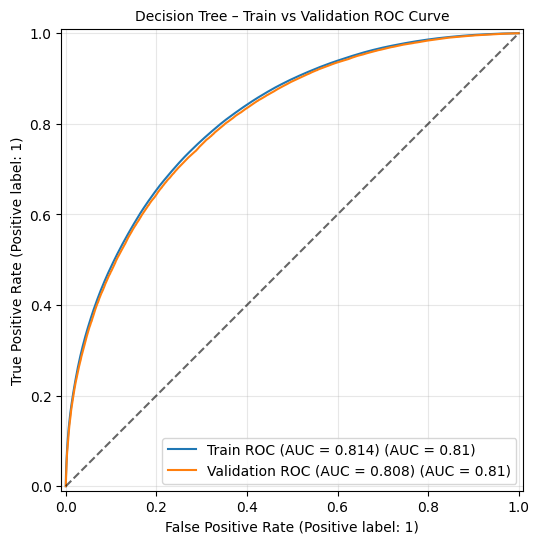

In [91]:
fig, ax = plt.subplots(figsize = (6, 6))

RocCurveDisplay.from_predictions(
    drinking_train_y,
    dt_train_probability,
    ax = ax,
    name = f"Train ROC (AUC = {dt_train_auc:.3f})"
)

RocCurveDisplay.from_predictions(
    drinking_validation_y,
    dt_validation_probability,
    ax = ax,
    name = f"Validation ROC (AUC = {dt_validation_auc:.3f})"
)

ax.plot([0, 1], [0, 1], "k--", alpha = 0.6)
ax.set_title("Decision Tree – Train vs Validation ROC Curve", fontsize = 10)
ax.grid(alpha = 0.3)

plt.show() # there is no overfitting

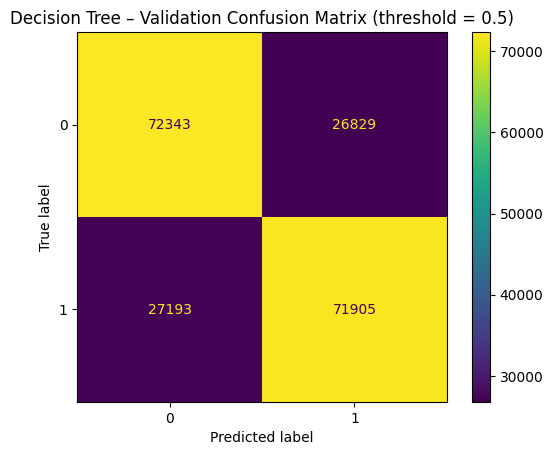

In [92]:
dt_cm = confusion_matrix(drinking_validation_y, dt_validation_prediction)
disp = ConfusionMatrixDisplay(dt_cm)
disp.plot(values_format = "d")
plt.title("Decision Tree – Validation Confusion Matrix (threshold = 0.5)")
plt.show()

In [93]:
print("VALIDATION CLASSIFICATION REPORT")
print(
    classification_report(
        drinking_validation_y,
        dt_validation_prediction,
        target_names = ["No", "Yes"]
    )
)

VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

          No       0.73      0.73      0.73     99172
         Yes       0.73      0.73      0.73     99098

    accuracy                           0.73    198270
   macro avg       0.73      0.73      0.73    198270
weighted avg       0.73      0.73      0.73    198270



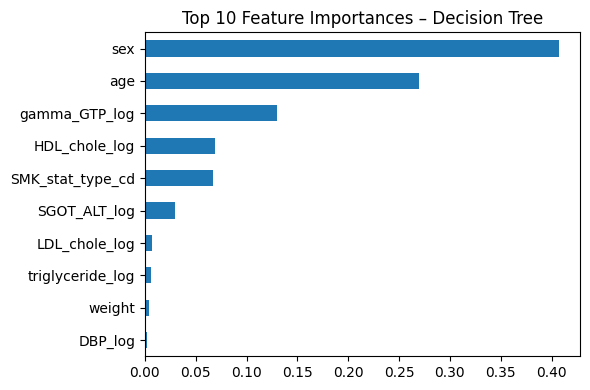

In [94]:
dt_importances = pd.Series(
    best_dt.feature_importances_,
    index = drinking_train_X.columns
).sort_values(ascending = False)

plt.figure(figsize = (6, 4))
dt_importances.head(10).iloc[::-1].plot(kind = "barh")
plt.title("Top 10 Feature Importances – Decision Tree")
plt.tight_layout()
plt.show()

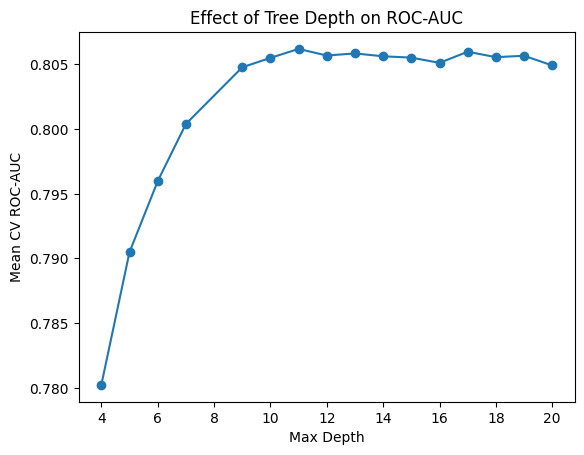

In [95]:
# hyperparameter sensitivity
cv_results = pd.DataFrame(dt_search.cv_results_)

cv_results.groupby("param_max_depth")["mean_test_score"].mean().plot(marker = "o")
plt.ylabel("Mean CV ROC-AUC")
plt.xlabel("Max Depth")
plt.title("Effect of Tree Depth on ROC-AUC")

plt.show() # the changes of the mean CV AUC become more or less stable after the tree depth 11

In [96]:
# check the performance with different tree depths
tree_depths = list(range(1, 21, 1))

train_auc = []
validation_auc = []

train_ba = []
validation_ba = []

train_acc = []
validation_acc = []

for depth in tree_depths:
    dt = DecisionTreeClassifier( # parameters from the best estimated one, but no predefined depths here
        criterion = "entropy",
        max_depth = depth,
        min_samples_split = 1000,
        min_samples_leaf = 500,
        random_state = 42
    )
    
    dt.fit(drinking_train_X, drinking_train_y)
    
    train_probability = dt.predict_proba(drinking_train_X)[:, 1]
    validation_probability = dt.predict_proba(drinking_validation_X)[:, 1]
    
    train_prediction = (train_probability >= 0.5).astype(int)
    validation_prediction = (validation_probability >= 0.5).astype(int)
    
    train_auc.append(roc_auc_score(drinking_train_y, train_probability))
    validation_auc.append(roc_auc_score(drinking_validation_y, validation_probability))
    
    train_ba.append(balanced_accuracy_score(drinking_train_y, train_prediction))
    validation_ba.append(balanced_accuracy_score(drinking_validation_y, validation_prediction))
    
    train_acc.append(accuracy_score(drinking_train_y, train_prediction))
    validation_acc.append(accuracy_score(drinking_validation_y, validation_prediction))

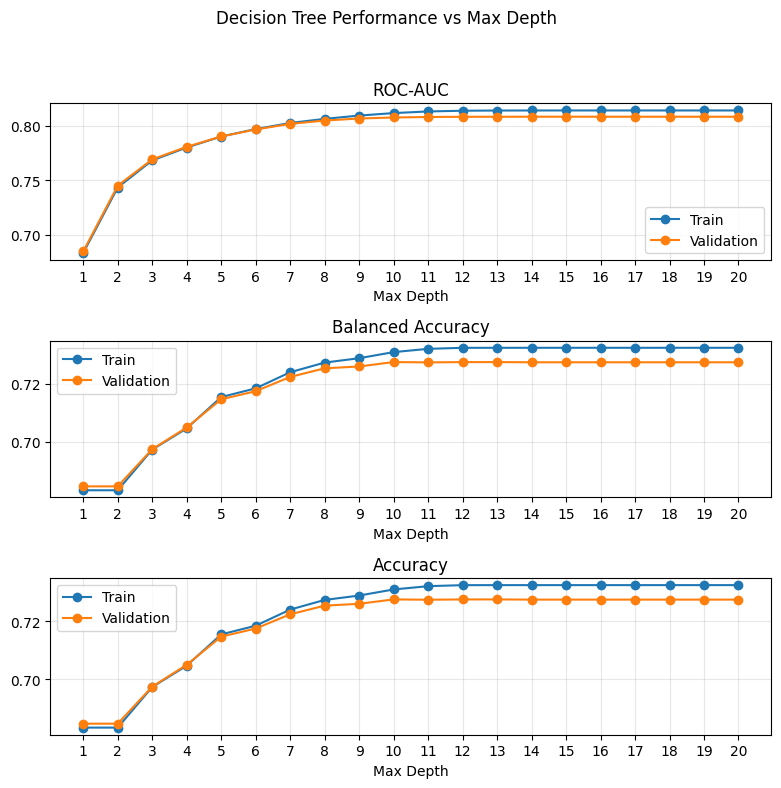

In [97]:
fig, axes = plt.subplots(3, 1, figsize = (8, 8))

axes[0].plot(tree_depths, train_auc, "-o", label = "Train")
axes[0].plot(tree_depths, validation_auc, "-o", label = "Validation")
axes[0].set_title("ROC-AUC")

axes[1].plot(tree_depths, train_ba, "-o", label = "Train")
axes[1].plot(tree_depths, validation_ba, "-o", label = "Validation")
axes[1].set_title("Balanced Accuracy")

axes[2].plot(tree_depths, train_acc, "-o", label = "Train")
axes[2].plot(tree_depths, validation_acc, "-o", label = "Validation")
axes[2].set_title("Accuracy")

for ax in axes:
    ax.set_xlabel("Max Depth")
    ax.set_xticks(tree_depths)
    ax.set_xticklabels(tree_depths)
    ax.legend()
    ax.grid(alpha = 0.3)

plt.suptitle("Decision Tree Performance vs Max Depth", fontsize = 12)
plt.tight_layout(rect = [0, 0, 1, 0.95])

plt.show()

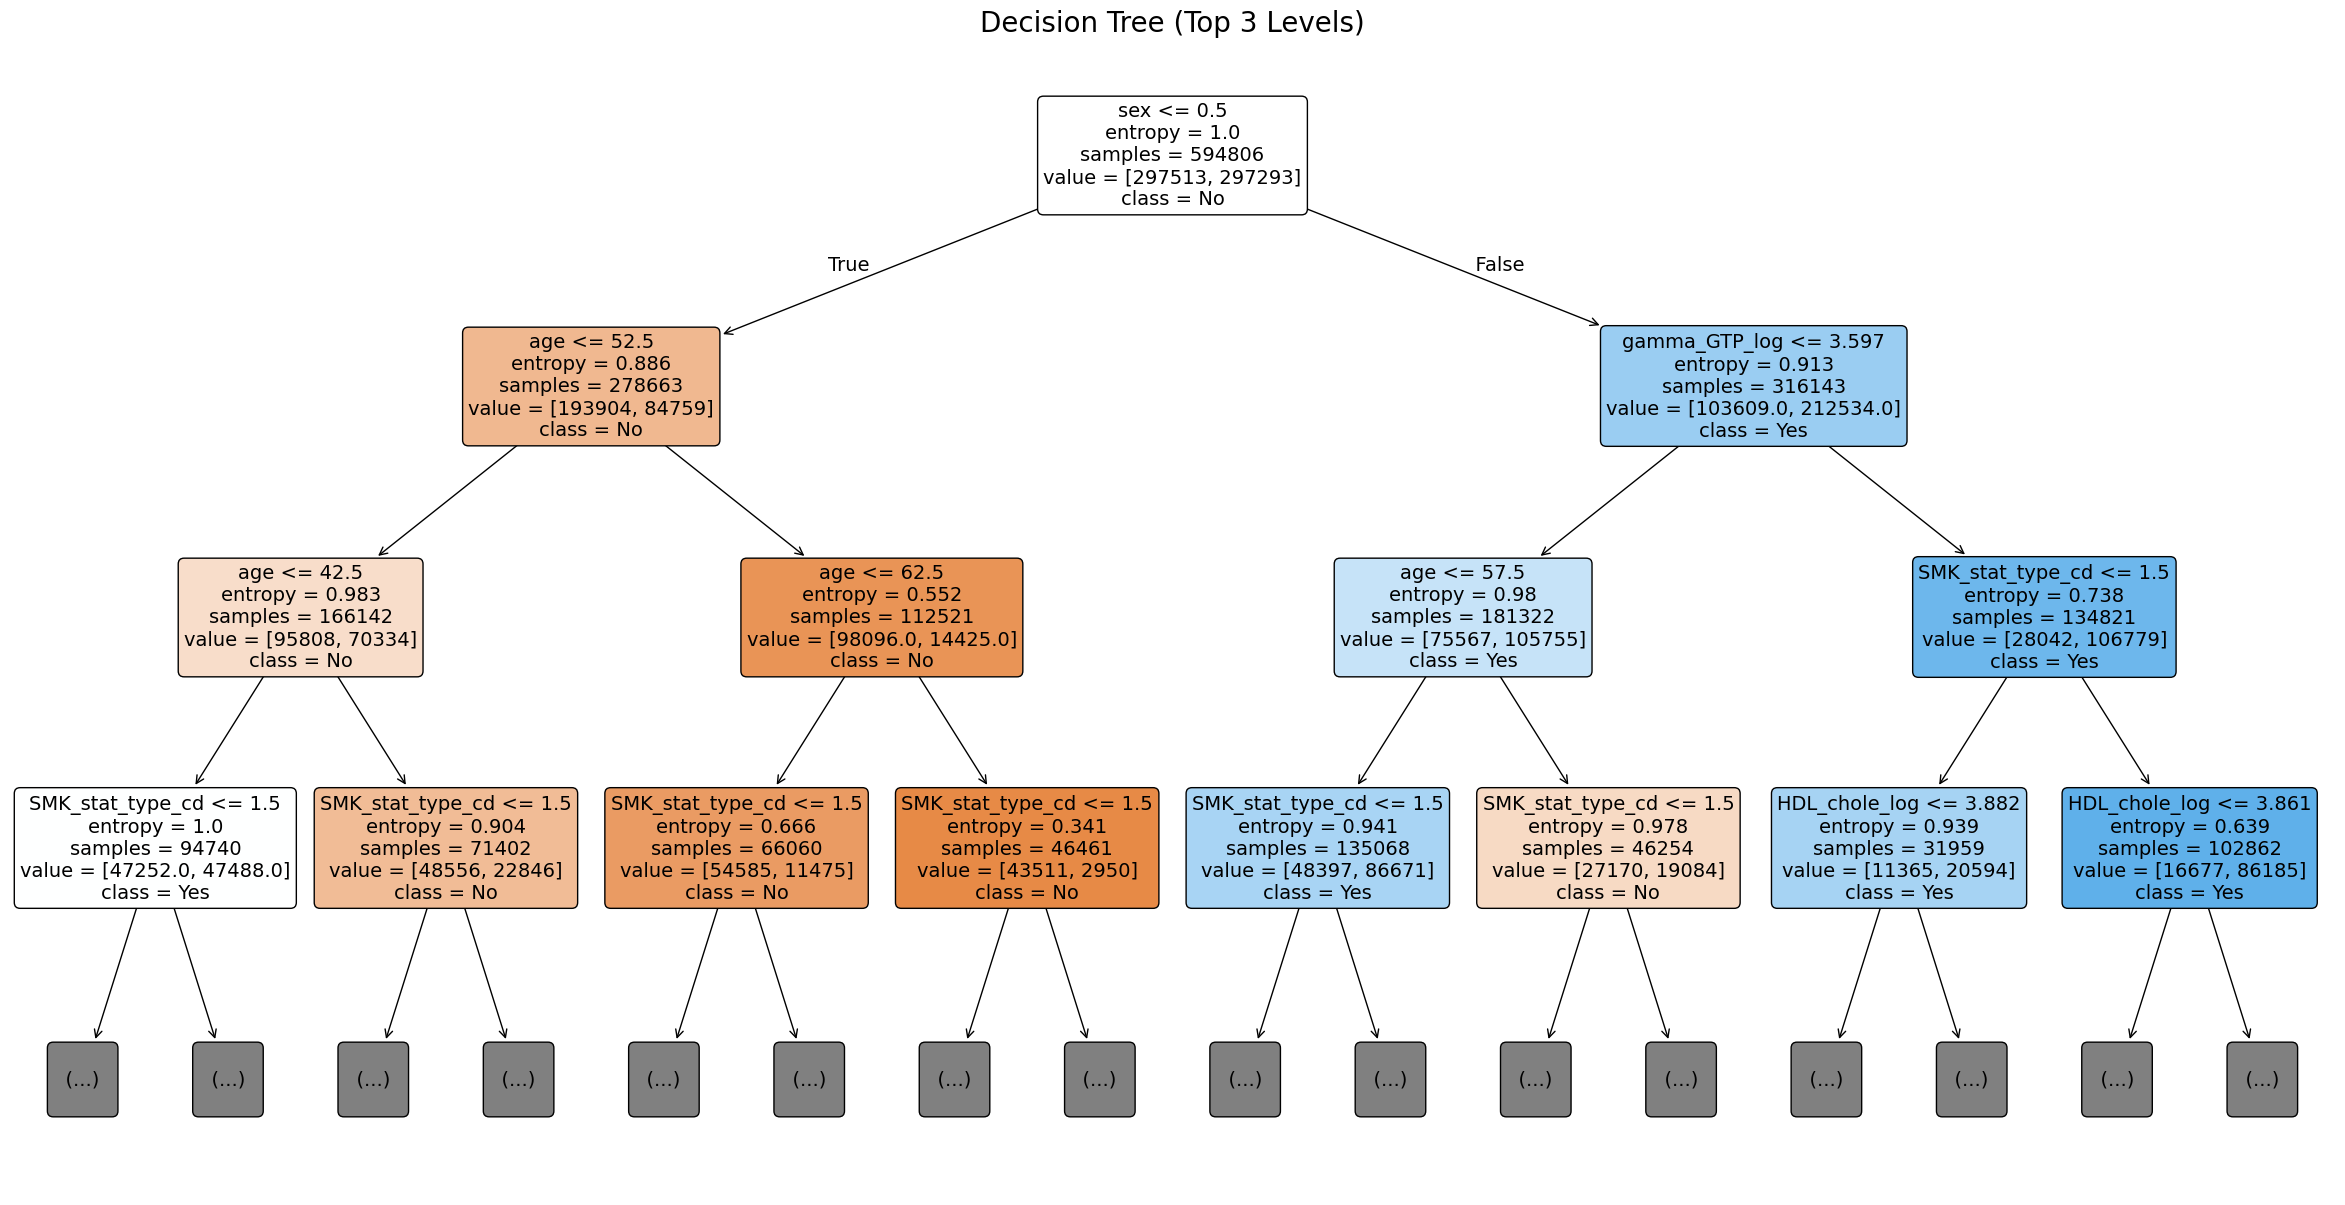

In [98]:
FeaturesName = drinking_train_X.columns.tolist()

plt.figure(figsize = (30, 15))
tree.plot_tree(
    best_dt,
    feature_names = FeaturesName,
    class_names = ["No", "Yes"],
    filled = True,
    rounded = True,
    max_depth = 3,
    fontsize = 14)
    
plt.title("Decision Tree (Top 3 Levels)", fontsize = 20)
plt.show()

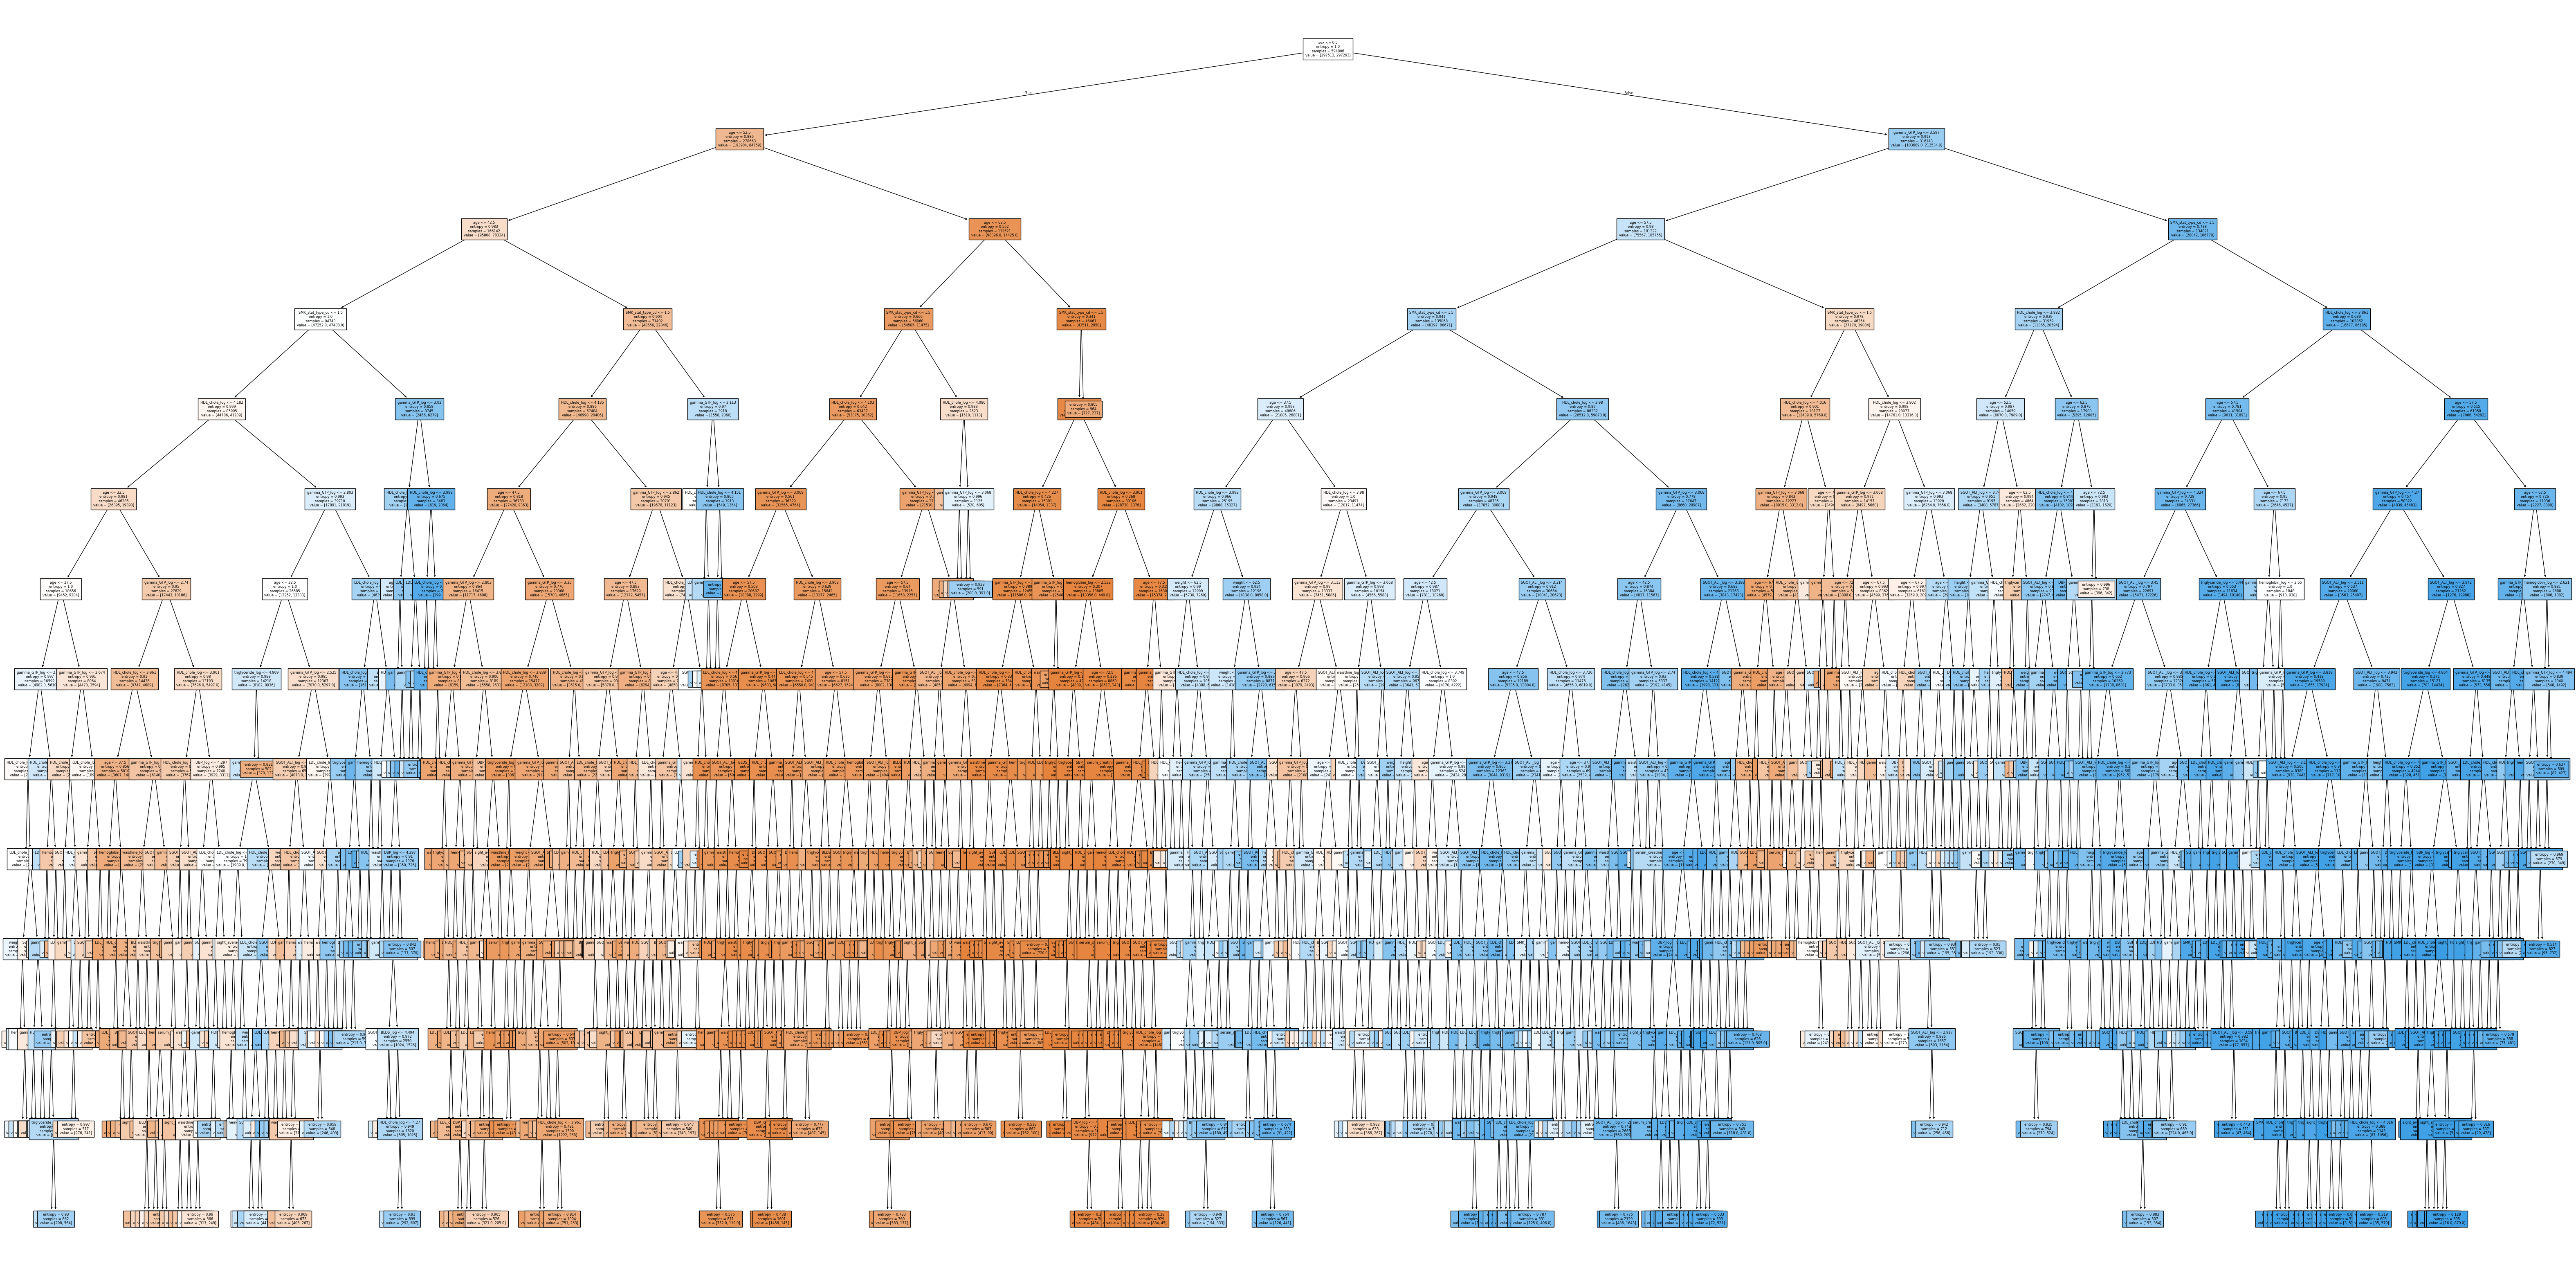

In [99]:
# full decision tree visualization, but take some times to generate
plt.figure(figsize = (80, 40))
tree.plot_tree(
    best_dt,
    feature_names = FeaturesName,
    filled = True,
    fontsize = 6)
plt.show()

## XGBoost

In [100]:
xgb_classifier = xgb.XGBClassifier(
    objective = "binary:logistic", # outputs probabilities
    eval_metric = "logloss",  
    tree_method = "hist",   
    n_jobs = -1,
    random_state = 42
)

In [101]:
xgb_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [102]:
xgb_parameters = {
 'n_estimators': [200, 300, 400],
 'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
 'max_depth': [3, 4, 5],
 'min_child_weight': [1, 3, 5, 8, 10],
 'subsample': [0.6, 0.7, 0.8, 0.9],
 'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'reg_lambda': [1, 5, 10],
 'reg_alpha': [0.0, 0.1, 0.3, 0.5],
 'gamma': [0, 0.5, 1]
}

When the parameters set as below:

- "n_estimators": [200, 300, 400]
- "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1]
- "max_depth": [3, 4, 5]
- "min_child_weight": [1, 3, 5, 8, 10],
- "subsample": [0.6, 0.7, 0.8, 0.9, 1]
- "colsample_bytree": [0.6, 0.7, 0.8, 0.9]
- "reg_lambda": [0.5, 1, 5, 8, 10]
- "reg_alpha": [0.0, 0.1, 0.3, 0.5, 0.8, 1]
- "gamma": [0, 0.25, 0.5, 0.75, 1]

It takes similar time for the cross validation search, and the results are slightly different:

- TRAIN - ROC-AUC: 0.8259, Balanced Acc: 0.7429, Acc: 0.7429, Prec: 0.7402, Recall: 0.7483
- VALID - ROC-AUC: 0.8206, Balanced Acc: 0.7383, Acc: 0.7383, Prec: 0.7361, Recall: 0.7425

In [103]:
start = time.time()

xgb_search = RandomizedSearchCV(
    estimator = xgb_classifier,
    param_distributions = xgb_parameters,
    n_iter = 50,
    scoring = "roc_auc",
    cv = xgb_cv,
    verbose = 0, # silence all CV outputs
    n_jobs = -1,
    random_state = 42,
    return_train_score = True
)

xgb_search.fit(drinking_train_X, drinking_train_y)

end = time.time()
xgb_time = end - start
print(f"Time in mins: {xgb_time / 60:.2f}")

Time in mins: 4.89


In [104]:
print("Best parameters:")
print(xgb_search.best_params_)
print("Best CV ROC-AUC:", xgb_search.best_score_)

Best parameters:
{'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}
Best CV ROC-AUC: 0.8200048266445034


In [105]:
best_xgb = xgb_search.best_estimator_

# probabilities
xgb_train_probability = best_xgb.predict_proba(drinking_train_X)[:, 1]
xgb_validation_probability = best_xgb.predict_proba(drinking_validation_X)[:, 1]

# predictions
xgb_train_prediction = (xgb_train_probability >= 0.5).astype(int)
xgb_validation_prediction = (xgb_validation_probability >= 0.5).astype(int)

# rocauc
xgb_train_auc = roc_auc_score(drinking_train_y, xgb_train_probability)
xgb_validation_auc = roc_auc_score(drinking_validation_y, xgb_validation_probability)

# balanced accuracy
xgb_train_ba = balanced_accuracy_score(drinking_train_y, xgb_train_prediction)
xgb_validation_ba   = balanced_accuracy_score(drinking_validation_y, xgb_validation_prediction)

# accuracy
xgb_train_acc = accuracy_score(drinking_train_y, xgb_train_prediction)
xgb_validation_acc = accuracy_score(drinking_validation_y, xgb_validation_prediction)

# precision
xgb_train_prec = precision_score(drinking_train_y, xgb_train_prediction)
xgb_validation_prec = precision_score(drinking_validation_y, xgb_validation_prediction)

# recall
xgb_train_rec = recall_score(drinking_train_y, xgb_train_prediction)
xgb_validation_rec = recall_score(drinking_validation_y, xgb_validation_prediction)

print(
    f"TRAIN - ROC-AUC: {xgb_train_auc:.4f}, "
    f"Balanced Acc: {xgb_train_ba:.4f}, "
    f"Acc: {xgb_train_acc:.4f}, "
    f"Prec: {xgb_train_prec:.4f}, "
    f"Recall: {xgb_train_rec:.4f}"
)

print(
    f"VALID - ROC-AUC: {xgb_validation_auc:.4f}, "
    f"Balanced Acc: {xgb_validation_ba:.4f}, "
    f"Acc: {xgb_validation_acc:.4f}, "
    f"Prec: {xgb_validation_prec:.4f}, "
    f"Recall: {xgb_validation_rec:.4f}"
)

TRAIN - ROC-AUC: 0.8272, Balanced Acc: 0.7441, Acc: 0.7441, Prec: 0.7411, Recall: 0.7502
VALID - ROC-AUC: 0.8205, Balanced Acc: 0.7385, Acc: 0.7385, Prec: 0.7360, Recall: 0.7436


In [106]:
xgb_cv_results = pd.DataFrame(xgb_search.cv_results_).sort_values("mean_test_score", ascending = False)
display(xgb_cv_results.head(10)[
    ["mean_test_score", "std_test_score", "mean_train_score", "std_train_score",
     "param_n_estimators", "param_learning_rate", "param_max_depth",
     "param_subsample", "param_colsample_bytree", "param_min_child_weight",
     "param_reg_lambda", "param_reg_alpha"]
])

mean_test_score  std_test_score  mean_train_score  std_train_score  \
32         0.820005        0.000788          0.828462         0.000171   
29         0.819831        0.000763          0.824980         0.000162   
38         0.819796        0.000819          0.824936         0.000165   
9          0.819659        0.000683          0.823695         0.000169   
42         0.819634        0.000792          0.823263         0.000150   
11         0.819625        0.000840          0.823637         0.000169   
33         0.819578        0.000811          0.823221         0.000164   
17         0.819568        0.000738          0.823531         0.000170   
41         0.819458        0.000744          0.823208         0.000201   
45         0.819306        0.000747          0.822197         0.000162   

    param_n_estimators  param_learning_rate  param_max_depth  param_subsample  \
32                 400                 0.10                5              0.9   
29                 400                 0.05                5              0.9   
38                 400                 0.10                4              0.8   
9                  300                 0.05                5              0.7   
42                 400                 0.08                4              0.9   
11                 300                 0.10                4              0.8   
33                 300                 0.10                4              0.7   
17                 300                 0.05                5              0.9   
41                 400                 0.03                5              0.7   
45                 400                 0.05                4              0.8   

    param_colsample_bytree  param_min_child_weight  param_reg_lambda  \
32                     0.7                       5                 5   
29                     0.9                       5                10   
38                     0.9                       5                 1   
9                      0.6                       8                 1   
42                     0.6                       5                10   
11                     0.9                       1                 5   
33                     0.8                       5                10   
17                     0.7                       8                10   
41                     0.9                       1                 5   
45                     0.7                       1                 1   

    param_reg_alpha  
32              0.5  
29              0.0  
38              0.3  
9               0.3  
42              0.5  
11              0.0  
33              0.0  
17              0.1  
41              0.5  
45              0.1

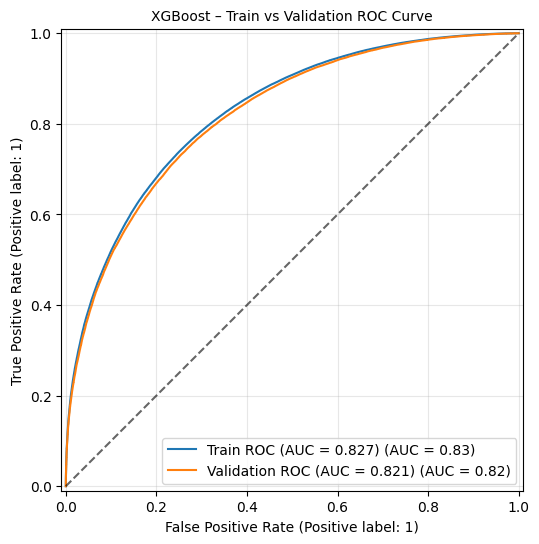

In [107]:
fig, ax = plt.subplots(figsize = (6, 6))

RocCurveDisplay.from_predictions(
    drinking_train_y,
    xgb_train_probability,
    ax = ax,
    name = f"Train ROC (AUC = {xgb_train_auc:.3f})"
)

RocCurveDisplay.from_predictions(
    drinking_validation_y,
    xgb_validation_probability,
    ax = ax,
    name = f"Validation ROC (AUC = {xgb_validation_auc:.3f})"
)

ax.plot([0, 1], [0, 1], "k--", alpha = 0.6)
ax.set_title("XGBoost – Train vs Validation ROC Curve", fontsize = 10)
ax.grid(alpha = 0.3)

plt.show() # there is no overfitting

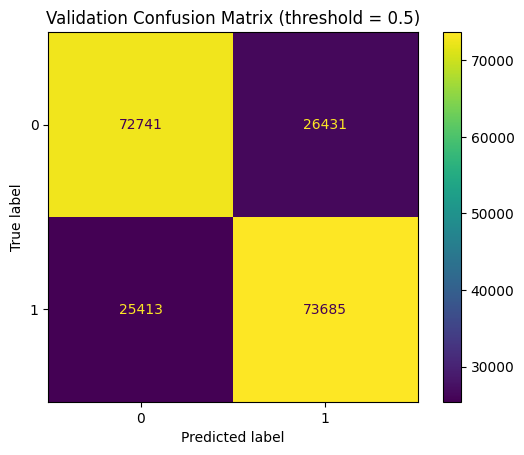

In [108]:
xgb_cm = confusion_matrix(drinking_validation_y, xgb_validation_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix = xgb_cm)
disp.plot(values_format = "d")
plt.title("Validation Confusion Matrix (threshold = 0.5)")
plt.show()

In [109]:
print("VALIDATION CLASSIFICATION REPORT")
print(
    classification_report(
        drinking_validation_y,
        xgb_validation_prediction,
        target_names = ["No", "Yes"]
    )
)

VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

          No       0.74      0.73      0.74     99172
         Yes       0.74      0.74      0.74     99098

    accuracy                           0.74    198270
   macro avg       0.74      0.74      0.74    198270
weighted avg       0.74      0.74      0.74    198270



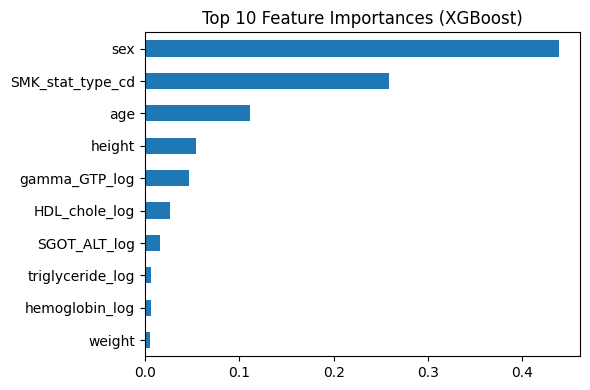

In [110]:
xgb_importances = best_xgb.feature_importances_
feat_imp = pd.Series(xgb_importances, index = drinking_train_X.columns).sort_values(ascending = False)

plt.figure(figsize = (6, 4))
feat_imp.head(10).iloc[::-1].plot(kind = "barh")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

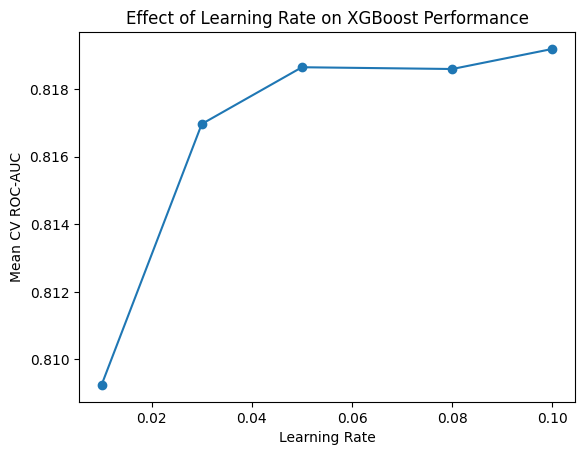

In [111]:
# hyperparameter trade-off analysis which shows how learning rates differ on number of trees affects performance
cv_results = pd.DataFrame(xgb_search.cv_results_)

cv_results.groupby("param_learning_rate")["mean_test_score"].mean().plot(marker = "o")
plt.ylabel("Mean CV ROC-AUC")
plt.xlabel("Learning Rate")
plt.title("Effect of Learning Rate on XGBoost Performance")
plt.show()

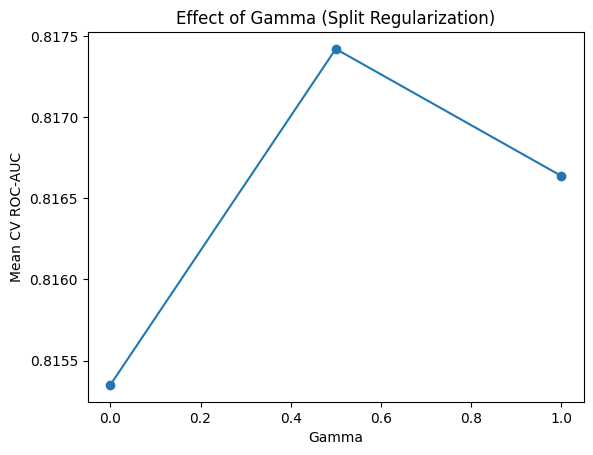

In [112]:
# regularization effect analysis - show the impact of gamma, reg_lambda, or min_child_weight
cv_results.groupby("param_gamma")["mean_test_score"].mean().plot(marker = "o")
plt.ylabel("Mean CV ROC-AUC")
plt.xlabel("Gamma")
plt.title("Effect of Gamma (Split Regularization)")
plt.show()

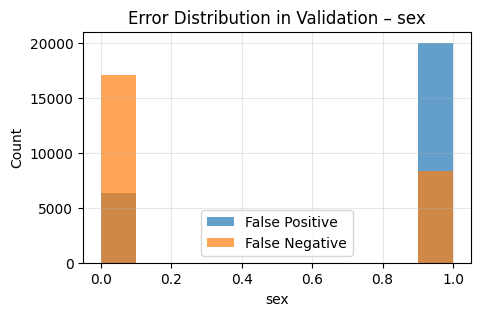

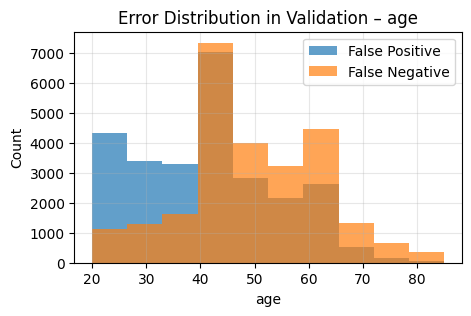

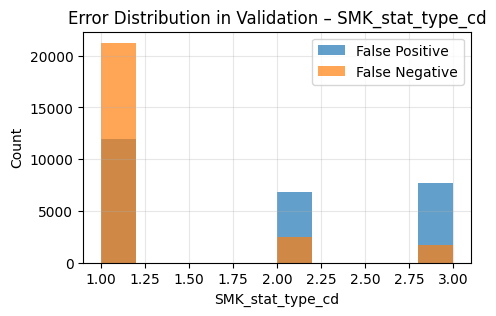

In [113]:
val_results = drinking_validation_X.copy()
val_results["true"] = drinking_validation_y.values
val_results["pred"] = xgb_validation_prediction
val_results["proba"] = xgb_validation_probability

errors_df = val_results[val_results["true"] != val_results["pred"]]

fp = errors_df[(errors_df["true"] == 0) & (errors_df["pred"] == 1)]
fn = errors_df[(errors_df["true"] == 1) & (errors_df["pred"] == 0)]

for feature in ["sex", "age", "SMK_stat_type_cd"]: # top 3 features
    plt.figure(figsize = (5, 3))

    fp[feature].hist(alpha = 0.7)
    fn[feature].hist(alpha = 0.7)

    plt.legend(["False Positive", "False Negative"])
    plt.title(f"Error Distribution in Validation – {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.grid(alpha = 0.3)
    plt.show()

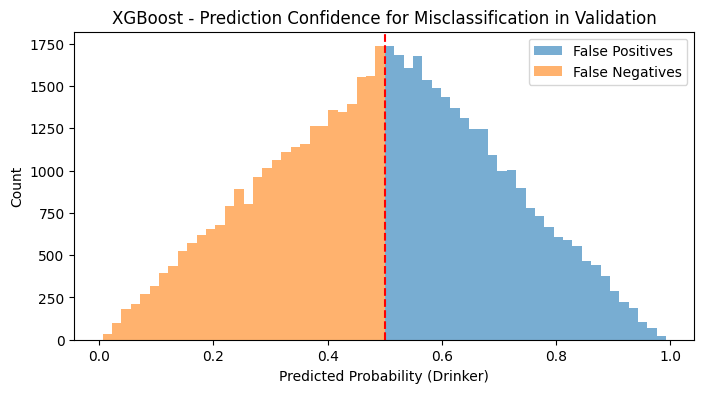

In [114]:
# probability confidence analysis - show that errors occur near the decision boundary
val_results = drinking_validation_X.reset_index(drop = True).copy()
val_results["true"] = drinking_validation_y.reset_index(drop = True)
val_results["pred"] = xgb_validation_prediction
val_results["proba"] = xgb_validation_probability

false_pos = val_results[(val_results.true == 0) & (val_results.pred == 1)]
false_neg = val_results[(val_results.true == 1) & (val_results.pred == 0)]

plt.figure(figsize = (8, 4))
plt.hist(false_pos["proba"], bins = 30, alpha = 0.6, label = "False Positives")
plt.hist(false_neg["proba"], bins = 30, alpha = 0.6, label = "False Negatives")
plt.axvline(0.5, color = "red", linestyle = "--")
plt.xlabel("Predicted Probability (Drinker)")
plt.ylabel("Count")
plt.title("XGBoost - Prediction Confidence for Misclassification in Validation")
plt.legend()
plt.show()

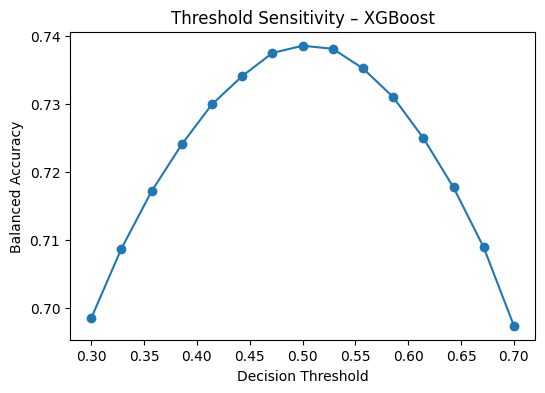

In [115]:
thresholds = np.linspace(0.3, 0.7, 15)

ba_scores = []
for t in thresholds:
    preds = (xgb_validation_probability >= t).astype(int)
    ba_scores.append(balanced_accuracy_score(drinking_validation_y, preds))

plt.figure(figsize = (6, 4))
plt.plot(thresholds, ba_scores, marker = "o")
plt.xlabel("Decision Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("Threshold Sensitivity – XGBoost")
plt.show()

## CatBoost

In [116]:
cat_classifier = CatBoostClassifier(
    loss_function = "Logloss",
    eval_metric = "AUC",
    random_seed = 42,
    verbose = False, # silence per-iteration output
    thread_count = -1
)

In [117]:
cat_cv = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = 42
)

When the parameters set as below:

- "iterations": [200, 300, 400, 500, 700]
- "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1]
- "depth": [3, 4, 5, 6, 7, 8]
- "l2_leaf_reg": [1, 3, 5, 10]
- "bagging_temperature": [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
- "border_count": [64, 128]

It takes longer time for the cross validation search, and the results are slightly lower:

- TRAIN - ROC-AUC: 0.8257, Balanced Acc: 0.7430, Acc: 0.7430, Prec: 0.7404, Recall: 0.7481
- VALID - ROC-AUC: 0.8210, Balanced Acc: 0.7388, Acc: 0.7388, Prec: 0.7369, Recall: 0.7425

In [118]:
cat_parameters = {
    "iterations": [300, 500, 700],
    "learning_rate": [0.03, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5, 10],
    "bagging_temperature": [0, 0.5, 1.0],
    "border_count": [64, 128]
}

When the parameters are the same, but the number of iterations (n_iter = 20) in the search is lower, the results are also a bit slightly different:

- TRAIN - ROC-AUC: 0.8257, Balanced Acc: 0.7431, Acc: 0.7431, Prec: 0.7401, Recall: 0.7490
- VALID - ROC-AUC: 0.8210, Balanced Acc: 0.7387, Acc: 0.7387, Prec: 0.7366, Recall: 0.7428

The time used for search is faster.

In [119]:
start= time.time()

cat_search = RandomizedSearchCV(
    estimator = cat_classifier,
    param_distributions = cat_parameters,
    n_iter = 50, 
    scoring = "roc_auc",
    cv = cat_cv,
    n_jobs = -1,
    verbose = 0, # silence all CV outputs
    random_state = 42,
    return_train_score = True
)

cat_search.fit(drinking_train_X, drinking_train_y)

end = time.time()
cat_time = end - start
print(f"Time in mins: {cat_time / 60:.2f}")

Time in mins: 37.76


In [120]:
print("Best parameters:")
print(cat_search.best_params_)
print("Best CV ROC-AUC:", cat_search.best_score_)

Best parameters:
{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 8, 'border_count': 64, 'bagging_temperature': 1.0}
Best CV ROC-AUC: 0.8206757849656376


In [121]:
best_cat = cat_search.best_estimator_

# probabilities
cat_train_probability = best_cat.predict_proba(drinking_train_X)[:, 1]
cat_validation_probability   = best_cat.predict_proba(drinking_validation_X)[:, 1]

# prediction
cat_train_prediction = (cat_train_probability >= 0.5).astype(int)
cat_validation_prediction   = (cat_validation_probability >= 0.5).astype(int)

# rocauc
cat_train_auc = roc_auc_score(drinking_train_y, cat_train_probability)
cat_validation_auc   = roc_auc_score(drinking_validation_y, cat_validation_probability)

# balanced accuracy
cat_train_ba = balanced_accuracy_score(drinking_train_y, cat_train_prediction)
cat_validation_ba   = balanced_accuracy_score(drinking_validation_y, cat_validation_prediction)

# accuracy
cat_train_acc = accuracy_score(drinking_train_y, cat_train_prediction)
cat_validation_acc = accuracy_score(drinking_validation_y, cat_validation_prediction)

# precision
cat_train_prec = precision_score(drinking_train_y, cat_train_prediction)
cat_validation_prec = precision_score(drinking_validation_y, cat_validation_prediction)

# recall
cat_train_rec = recall_score(drinking_train_y, cat_train_prediction)
cat_validation_rec = recall_score(drinking_validation_y, cat_validation_prediction)

print(
    f"TRAIN - ROC-AUC: {cat_train_auc:.4f}, "
    f"Balanced Acc: {cat_train_ba:.4f}, "
    f"Acc: {cat_train_acc:.4f}, "
    f"Prec: {cat_train_prec:.4f}, "
    f"Recall: {cat_train_rec:.4f}"
)

print(
    f"VALID - ROC-AUC: {cat_validation_auc:.4f}, "
    f"Balanced Acc: {cat_validation_ba:.4f}, "
    f"Acc: {cat_validation_acc:.4f}, "
    f"Prec: {cat_validation_prec:.4f}, "
    f"Recall: {cat_validation_rec:.4f}"
)
# CatBoost here actually performs competitively with XGBoost while requiring less feature preprocessing

TRAIN - ROC-AUC: 0.8313, Balanced Acc: 0.7485, Acc: 0.7485, Prec: 0.7463, Recall: 0.7527
VALID - ROC-AUC: 0.8210, Balanced Acc: 0.7390, Acc: 0.7390, Prec: 0.7376, Recall: 0.7417


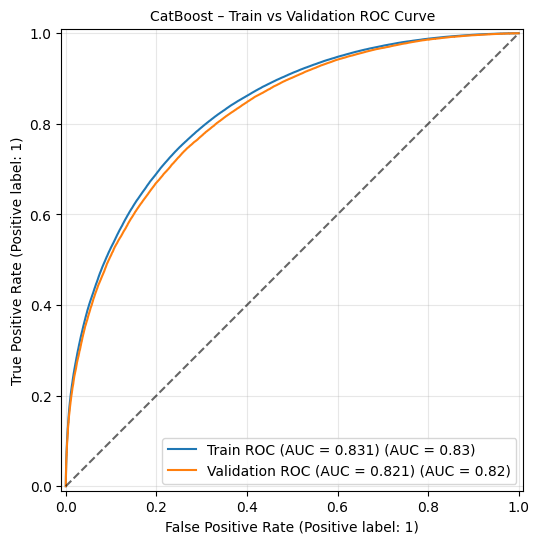

In [122]:
fig, ax = plt.subplots(figsize = (6, 6))

RocCurveDisplay.from_predictions(
    drinking_train_y,
    cat_train_probability,
    ax = ax,
    name=f"Train ROC (AUC = {cat_train_auc:.3f})"
)

RocCurveDisplay.from_predictions(
    drinking_validation_y,
    cat_validation_probability,
    ax = ax,
    name=f"Validation ROC (AUC = {cat_validation_auc:.3f})"
)

ax.plot([0, 1], [0, 1], "k--", alpha = 0.6)
ax.set_title("CatBoost – Train vs Validation ROC Curve", fontsize = 10)
ax.grid(alpha = 0.3)

plt.show() # there is no overfitting, but the gap is obvisouly a bit bigger than the one from XGBoost, Random Forest and Decision Tree

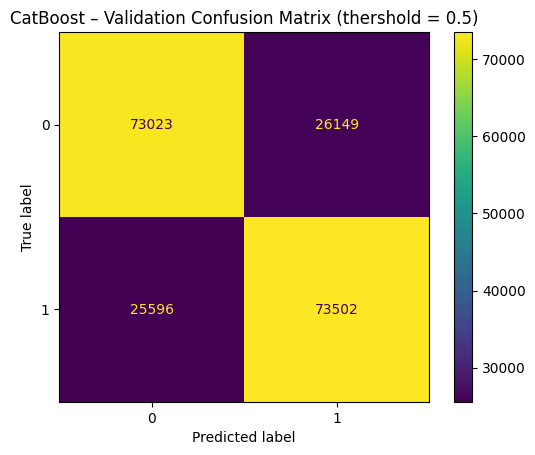

In [123]:
cat_cm = confusion_matrix(drinking_validation_y, cat_validation_prediction)
disp = ConfusionMatrixDisplay(cat_cm)
disp.plot(values_format = "d")
plt.title("CatBoost – Validation Confusion Matrix (thershold = 0.5)")
plt.show()

In [124]:
print("VALIDATION CLASSIFICATION REPORT")
print(
    classification_report(
        drinking_validation_y,
        cat_validation_prediction,
        target_names = ["No", "Yes"]
    )
)

VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

          No       0.74      0.74      0.74     99172
         Yes       0.74      0.74      0.74     99098

    accuracy                           0.74    198270
   macro avg       0.74      0.74      0.74    198270
weighted avg       0.74      0.74      0.74    198270



In [125]:
cat_cv_results = pd.DataFrame(cat_search.cv_results_) \
                .sort_values("mean_test_score", ascending = False)

display(
    cat_cv_results.head(10)[
        [
            "mean_test_score",
            "std_test_score",
            "mean_train_score",
            "std_train_score",
            "param_iterations",
            "param_learning_rate",
            "param_depth",
            "param_l2_leaf_reg",
            "param_bagging_temperature"
        ]
    ]
)

mean_test_score  std_test_score  mean_train_score  std_train_score  \
24         0.820676        0.000725          0.833420         0.000179   
38         0.820590        0.000734          0.827082         0.000187   
3          0.820557        0.000725          0.826674         0.000205   
39         0.820505        0.000788          0.827406         0.000146   
11         0.820459        0.000778          0.830337         0.000202   
9          0.820459        0.000774          0.825445         0.000178   
2          0.820403        0.000768          0.827185         0.000154   
10         0.820400        0.000792          0.829770         0.000123   
0          0.820334        0.000804          0.835265         0.000168   
16         0.820227        0.000777          0.824282         0.000191   

    param_iterations  param_learning_rate  param_depth  param_l2_leaf_reg  \
24               700                 0.05            8                  3   
38               700                 0.03            8                  5   
3                700                 0.03            8                 10   
39               500                 0.10            6                  1   
11               700                 0.10            6                  3   
9                700                 0.05            6                  1   
2                500                 0.10            6                  3   
10               700                 0.10            6                  3   
0                500                 0.10            8                 10   
16               300                 0.10            6                  1   

    param_bagging_temperature  
24                        1.0  
38                        0.0  
3                         0.5  
39                        0.0  
11                        0.5  
9                         0.5  
2                         1.0  
10                        1.0  
0                         1.0  
16                        0.5

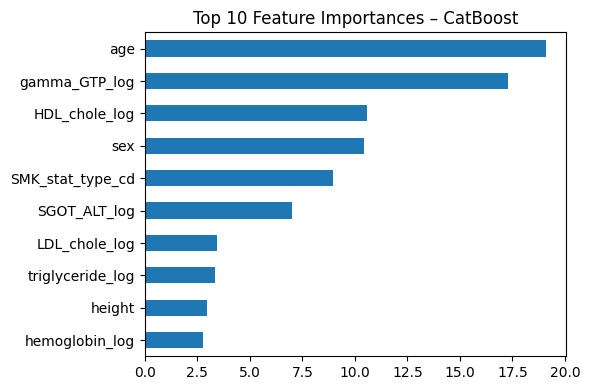

In [126]:
cat_importances = best_cat.get_feature_importance()
feat_imp = pd.Series(cat_importances, index=drinking_train_X.columns) \
            .sort_values(ascending = False)

plt.figure(figsize = (6, 4))
feat_imp.head(10).iloc[::-1].plot(kind = "barh")
plt.title("Top 10 Feature Importances – CatBoost")
plt.tight_layout()
plt.show()

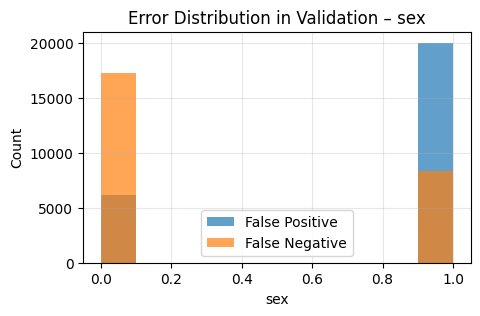

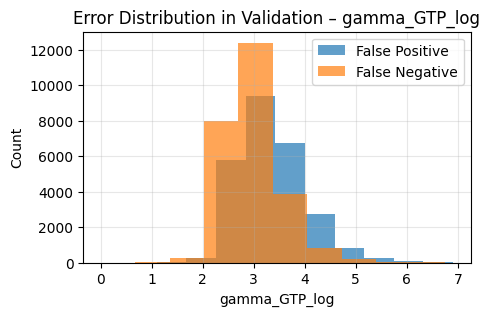

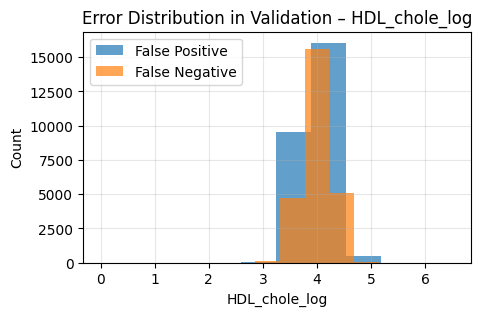

In [127]:
val_results = drinking_validation_X.copy()
val_results["true"] = drinking_validation_y.values
val_results["pred"] = cat_validation_prediction
val_results["proba"] = cat_validation_probability

errors_df = val_results[val_results["true"] != val_results["pred"]]

fp = errors_df[(errors_df["true"] == 0) & (errors_df["pred"] == 1)]
fn = errors_df[(errors_df["true"] == 1) & (errors_df["pred"] == 0)]

for feature in ["sex", "gamma_GTP_log", "HDL_chole_log"]: # top 3 features
    plt.figure(figsize = (5, 3))

    fp[feature].hist(alpha = 0.7)
    fn[feature].hist(alpha = 0.7)

    plt.legend(["False Positive", "False Negative"])
    plt.title(f"Error Distribution in Validation – {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.grid(alpha = 0.3)
    plt.show()

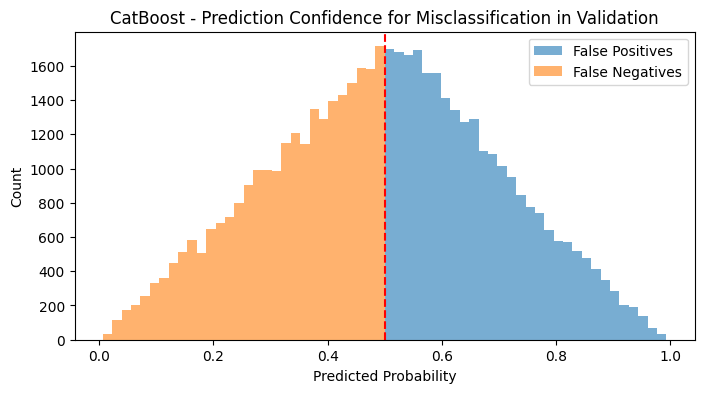

In [128]:
val_cat = drinking_validation_X.reset_index(drop=True).copy()
val_cat["true"] = drinking_validation_y.reset_index(drop=True)
val_cat["pred"] = cat_validation_prediction
val_cat["proba"] = cat_validation_probability

false_pos_cat = val_cat[(val_cat.true == 0) & (val_cat.pred == 1)]
false_neg_cat = val_cat[(val_cat.true == 1) & (val_cat.pred == 0)]

plt.figure(figsize = (8, 4))
plt.hist(false_pos_cat["proba"], bins = 30, alpha = 0.6, label = "False Positives")
plt.hist(false_neg_cat["proba"], bins = 30, alpha = 0.6, label = "False Negatives")
plt.axvline(0.5, color = "red", linestyle = "--")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("CatBoost - Prediction Confidence for Misclassification in Validation")
plt.legend()
plt.show()

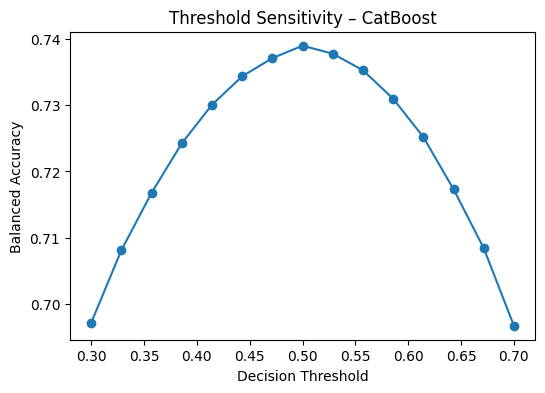

In [129]:
thresholds = np.linspace(0.3, 0.7, 15)
ba_scores = []

for t in thresholds:
    preds = (cat_validation_probability >= t).astype(int)
    ba_scores.append(balanced_accuracy_score(drinking_validation_y, preds))

plt.figure(figsize = (6,4))
plt.plot(thresholds, ba_scores, marker = "o")
plt.xlabel("Decision Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("Threshold Sensitivity – CatBoost")
plt.show()

## Random Forest

In [130]:
sss = StratifiedShuffleSplit( # make subsample to shorten the running time
    n_splits = 1,
    train_size = 200_000,
    random_state = 42
)

for subset_idx, _ in sss.split(drinking_train_X, drinking_train_y):
    X_rf_sub = drinking_train_X.iloc[subset_idx]
    y_rf_sub = drinking_train_y.iloc[subset_idx]

In [131]:
start = time.time()

rf_classifier = RandomForestClassifier(
    bootstrap = True,
    oob_score = True, # out of bag
    n_jobs = -1,
    random_state = 42
)

rf_parameters = {
    "n_estimators": [300, 500],
    "max_depth": [None, 10, 15, 20, 25],
    "min_samples_split": [300, 500],
    "min_samples_leaf": [100, 200, 300],
    "max_features": ["sqrt", 0.2, 0.3]
}

rf_search = RandomizedSearchCV(
    estimator = rf_classifier,
    param_distributions = rf_parameters,
    n_iter = 50,          
    scoring = "roc_auc",
    cv = 5,             
    n_jobs = -1,
    verbose = 0,
    random_state = 42,
    return_train_score = True
)

rf_search.fit(X_rf_sub, y_rf_sub)

end = time.time()
rf_time = end - start
print(f"Time in mins: {rf_time / 60:.2f}")

Time in mins: 45.25


When the parameters set as below:

- "max_depth": [None, 15, 25]
- "min_samples_split": [300, 500]
- "min_samples_leaf": [100, 200]
- "max_features": ["sqrt", 0.3]

And includes the number of estimators (n_estimators = 300) in the classifier, it takes longer time for the cross validation search, and the results are slightly lower:

- TRAIN - ROC-AUC: 0.8161, Balanced Acc: 0.7341
- VALID - ROC-AUC: 0.8134, Balanced Acc: 0.7314

In [132]:
print("Best parameters:")
print(rf_search.best_params_)
print("Best CV ROC-AUC:", rf_search.best_score_)

Best parameters:
{'n_estimators': 500, 'min_samples_split': 300, 'min_samples_leaf': 100, 'max_features': 0.3, 'max_depth': 25}
Best CV ROC-AUC: 0.8132601728058886


In [133]:
best_rf = rf_search.best_estimator_

# probabilities
rf_train_probability = best_rf.predict_proba(drinking_train_X)[:, 1]
rf_validation_probability   = best_rf.predict_proba(drinking_validation_X)[:, 1]

# predictions
rf_train_prediction = (rf_train_probability >= 0.5).astype(int)
rf_validation_prediction   = (rf_validation_probability >= 0.5).astype(int)

# rocauc
rf_train_auc = roc_auc_score(drinking_train_y, rf_train_probability)
rf_validation_auc   = roc_auc_score(drinking_validation_y, rf_validation_probability)

# balanced accuracy
rf_train_ba = balanced_accuracy_score(drinking_train_y, rf_train_prediction)
rf_validation_ba   = balanced_accuracy_score(drinking_validation_y, rf_validation_prediction)

# accuracy
rf_train_acc = accuracy_score(drinking_train_y, rf_train_prediction)
rf_validation_acc = accuracy_score(drinking_validation_y, rf_validation_prediction)

# precision
rf_train_prec = precision_score(drinking_train_y, rf_train_prediction)
rf_validation_prec = precision_score(drinking_validation_y, rf_validation_prediction)

# recall
rf_train_rec = recall_score(drinking_train_y, rf_train_prediction)
rf_validation_rec = recall_score(drinking_validation_y, rf_validation_prediction)

print(
    f"TRAIN - ROC-AUC: {rf_train_auc:.4f}, "
    f"Balanced Acc: {rf_train_ba:.4f}, "
    f"Acc: {rf_train_acc:.4f}, "
    f"Prec: {rf_train_prec:.4f}, "
    f"Recall: {rf_train_rec:.4f}"
)

print(
    f"VALID - ROC-AUC: {rf_validation_auc:.4f}, "
    f"Balanced Acc: {rf_validation_ba:.4f}, "
    f"Acc: {rf_validation_acc:.4f}, "
    f"Prec: {rf_validation_prec:.4f}, "
    f"Recall: {rf_validation_rec:.4f}"
)

TRAIN - ROC-AUC: 0.8181, Balanced Acc: 0.7359, Acc: 0.7358, Prec: 0.7269, Recall: 0.7552
VALID - ROC-AUC: 0.8141, Balanced Acc: 0.7318, Acc: 0.7318, Prec: 0.7235, Recall: 0.7501


In [134]:
print(f"OOB ROC-AUC (approximate): {best_rf.oob_score_:.4f}")

OOB ROC-AUC (approximate): 0.7325


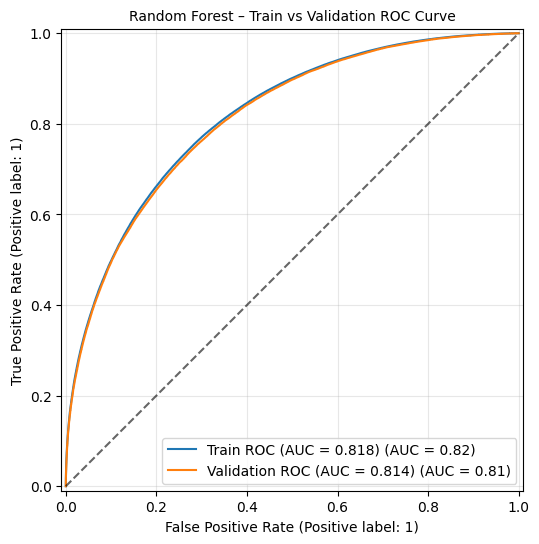

In [135]:
fig, ax = plt.subplots(figsize = (6, 6))

RocCurveDisplay.from_predictions(
    drinking_train_y,
    rf_train_probability,
    ax = ax,
    name = f"Train ROC (AUC = {rf_train_auc:.3f})"
)

RocCurveDisplay.from_predictions(
    drinking_validation_y,
    rf_validation_probability,
    ax = ax,
    name = f"Validation ROC (AUC = {rf_validation_auc:.3f})"
)

ax.plot([0, 1], [0, 1], "k--", alpha = 0.6)
ax.set_title("Random Forest – Train vs Validation ROC Curve", fontsize = 10)
ax.grid(alpha = 0.3)

plt.show() # there is no overfitting

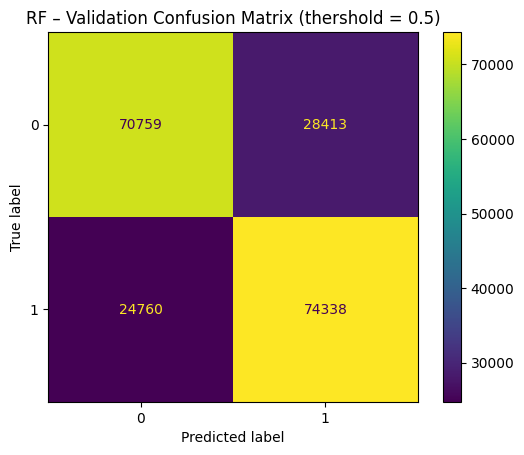

In [136]:
rf_cm = confusion_matrix(drinking_validation_y, rf_validation_prediction)
disp = ConfusionMatrixDisplay(rf_cm)
disp.plot(values_format = "d")
plt.title("RF – Validation Confusion Matrix (thershold = 0.5)")
plt.show()

In [137]:
print("VALIDATION CLASSIFICATION REPORT")
print(
    classification_report(
        drinking_validation_y,
        rf_validation_prediction,
        target_names = ["No", "Yes"]
    )
)

VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

          No       0.74      0.71      0.73     99172
         Yes       0.72      0.75      0.74     99098

    accuracy                           0.73    198270
   macro avg       0.73      0.73      0.73    198270
weighted avg       0.73      0.73      0.73    198270



In [138]:
rf_cv_results = pd.DataFrame(rf_search.cv_results_) \
                .sort_values("mean_test_score", ascending = False)

display(
    rf_cv_results.head(10)[
        [
            "mean_test_score",
            "std_test_score",
            "mean_train_score",
            "std_train_score",
            "param_max_depth",
            "param_min_samples_leaf",
            "param_min_samples_split",
            "param_max_features"
        ]
    ]
)

mean_test_score  std_test_score  mean_train_score  std_train_score  \
48         0.813260        0.001347          0.826205         0.000241   
20         0.813219        0.001382          0.826113         0.000226   
6          0.813184        0.001343          0.826163         0.000256   
45         0.813183        0.001341          0.826162         0.000256   
18         0.813162        0.001422          0.826059         0.000238   
4          0.812095        0.001408          0.824649         0.000245   
30         0.812090        0.001410          0.824650         0.000245   
26         0.811841        0.001371          0.821286         0.000285   
35         0.811578        0.001448          0.819881         0.000264   
29         0.811578        0.001448          0.819881         0.000264   

   param_max_depth  param_min_samples_leaf  param_min_samples_split  \
48              25                     100                      300   
20              15                     100                      300   
6             None                     100                      300   
45              20                     100                      300   
18              15                     100                      300   
4               25                     100                      300   
30              20                     100                      300   
26              10                     100                      300   
35            None                     200                      300   
29              25                     200                      300   

   param_max_features  
48                0.3  
20                0.3  
6                 0.3  
45                0.3  
18                0.3  
4                sqrt  
30               sqrt  
26                0.3  
35                0.3  
29                0.3

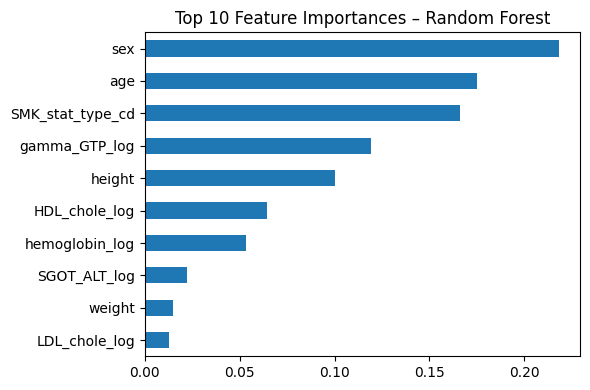

In [139]:
rf_importances = pd.Series(
    best_rf.feature_importances_,
    index = drinking_train_X.columns
).sort_values(ascending = False)

plt.figure(figsize = (6, 4))
rf_importances.head(10).iloc[::-1].plot(kind = "barh")
plt.title("Top 10 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

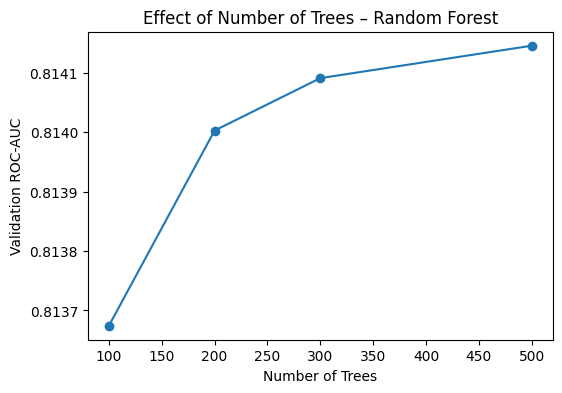

In [140]:
trees = [100, 200, 300, 500]
val_auc_scores = []

for n in trees:
    rf_tmp = RandomForestClassifier(
        n_estimators = n,
        **{k: v for k, v in rf_search.best_params_.items() if k != "n_estimators"},
        bootstrap = True,
        oob_score = True,
        n_jobs = -1,
        random_state = 42
    )
    rf_tmp.fit(X_rf_sub, y_rf_sub)
    val_auc_scores.append(
        roc_auc_score(
            drinking_validation_y,
            rf_tmp.predict_proba(drinking_validation_X)[:, 1]
        )
    )

plt.figure(figsize = (6,4))
plt.plot(trees, val_auc_scores, marker = "o")
plt.xlabel("Number of Trees")
plt.ylabel("Validation ROC-AUC")
plt.title("Effect of Number of Trees – Random Forest")
plt.show()
# performance improves marginally with more trees and stabilizes beyond 300 estimators, suggesting diminishing returns

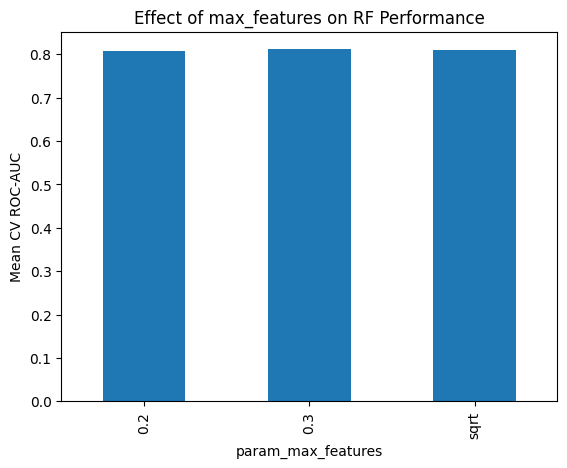

In [141]:
cv_results = pd.DataFrame(rf_search.cv_results_)

cv_results.groupby("param_max_features")["mean_test_score"].mean().plot(kind = "bar")
plt.ylabel("Mean CV ROC-AUC")
plt.title("Effect of max_features on RF Performance")
plt.show()

## Save the Models

In [142]:
with open("decision_tree.pkl", "wb") as f:
    pickle.dump(best_dt, f)
    pickle.dump(dt_time, f)
    pickle.dump(dt_search, f)

with open("xgboost.pkl", "wb") as f:
    pickle.dump(best_xgb, f)
    pickle.dump(xgb_time, f)
    pickle.dump(xgb_search, f)

with open("catboost.pkl", "wb") as f:
    pickle.dump(best_cat, f)
    pickle.dump(cat_time, f)
    pickle.dump(cat_search, f)

with open("random_forest.pkl", "wb") as f:
    pickle.dump(best_rf, f)
    pickle.dump(rf_time, f)
    pickle.dump(rf_search, f)

# **Model Comparison**

In [143]:
with open("decision_tree.pkl", "rb") as f:
    best_dt = pickle.load(f)
    dt_time = pickle.load(f)
    dt_search = pickle.load(f)

with open("xgboost.pkl", "rb") as f:
    best_xgb = pickle.load(f)
    xgb_time = pickle.load(f)
    xgb_search = pickle.load(f)

with open("catboost.pkl", "rb") as f:
    best_cat = pickle.load(f)
    cat_time = pickle.load(f)
    cat_search = pickle.load(f)

with open("random_forest.pkl", "rb") as f:
    best_rf = pickle.load(f)
    rf_time = pickle.load(f)
    rf_search = pickle.load(f)

In [144]:
models_order = ["Decision Tree", "Random Forest", "XGBoost", "CatBoost"]

metrics_df = pd.DataFrame({
    "Model": models_order,

    # ROC-AUC
    "Train AUC": [dt_train_auc, rf_train_auc, xgb_train_auc, cat_train_auc],
    "Val AUC":   [dt_validation_auc, rf_validation_auc, xgb_validation_auc, cat_validation_auc],

    # Balanced Accuracy
    "Train BA": [dt_train_ba, rf_train_ba, xgb_train_ba, cat_train_ba],
    "Val BA":   [dt_validation_ba, rf_validation_ba, xgb_validation_ba, cat_validation_ba],

    # Accuracy
    "Train Acc": [dt_train_acc, rf_train_acc, xgb_train_acc, cat_train_acc],
    "Val Acc":   [dt_validation_acc, rf_validation_acc, xgb_validation_acc, cat_validation_acc],

    # Precision
    "Train Prec": [dt_train_prec, rf_train_prec, xgb_train_prec, cat_train_prec],
    "Val Prec":   [dt_validation_prec, rf_validation_prec, xgb_validation_prec, cat_validation_prec],

    # Recall
    "Train Rec": [dt_train_rec, rf_train_rec, xgb_train_rec, cat_train_rec],
    "Val Rec":   [dt_validation_rec, rf_validation_rec, xgb_validation_rec, cat_validation_rec],
})

metrics_df


Model  Train AUC   Val AUC  Train BA    Val BA  Train Acc  \
0  Decision Tree   0.814032  0.808315  0.732460  0.727532   0.732461   
1  Random Forest   0.818083  0.814145  0.735854  0.731822   0.735847   
2        XGBoost   0.827221  0.820522  0.744115  0.738520   0.744113   
3       CatBoost   0.831330  0.821038  0.748525  0.739019   0.748523   

    Val Acc  Train Prec  Val Prec  Train Rec   Val Rec  
0  0.727533    0.732604  0.728270   0.731840  0.725595  
1  0.731815    0.726931  0.723477   0.755178  0.750146  
2  0.738518    0.741057  0.735996   0.750162  0.743557  
3  0.739018    0.746334  0.737594   0.752685  0.741710

In [145]:
error_overlap = pd.DataFrame({
    "Decision Tree": (dt_validation_prediction != drinking_validation_y).astype(int),
    "Random Forest": (rf_validation_prediction != drinking_validation_y).astype(int),
    "XGBoost": (xgb_validation_prediction != drinking_validation_y).astype(int),
    "CatBoost": (cat_validation_prediction != drinking_validation_y).astype(int),
})

error_overlap.mean().sort_values()
# boosting models exhibit fewer errors and fail on fewer shared samples
# suggest complementary error patterns and justify ensembling conceptually

CatBoost         0.260982
XGBoost          0.261482
Random Forest    0.268185
Decision Tree    0.272467
dtype: float64

In [146]:
metrics_df["ROC-AUC Gap"] = (
    metrics_df["Train AUC"] - metrics_df["Val AUC"])

metrics_df["BA Gap"] = (
    metrics_df["Train BA"] - metrics_df["Val BA"])

metrics_df["Acc Gap"] = (
    metrics_df["Train Acc"] - metrics_df["Val Acc"])

metrics_df["Prec Gap"] = (
    metrics_df["Train Prec"] - metrics_df["Val Prec"])

metrics_df["Rec Gap"] = (
    metrics_df["Train Rec"] - metrics_df["Val Rec"])

metrics_df[["Model", "ROC-AUC Gap", "BA Gap", "Acc Gap", "Prec Gap", "Rec Gap"]]

Model  ROC-AUC Gap    BA Gap   Acc Gap  Prec Gap   Rec Gap
0  Decision Tree     0.005717  0.004928  0.004928  0.004334  0.006245
1  Random Forest     0.003938  0.004032  0.004031  0.003454  0.005031
2        XGBoost     0.006699  0.005595  0.005595  0.005060  0.006605
3       CatBoost     0.010292  0.009506  0.009506  0.008739  0.010975

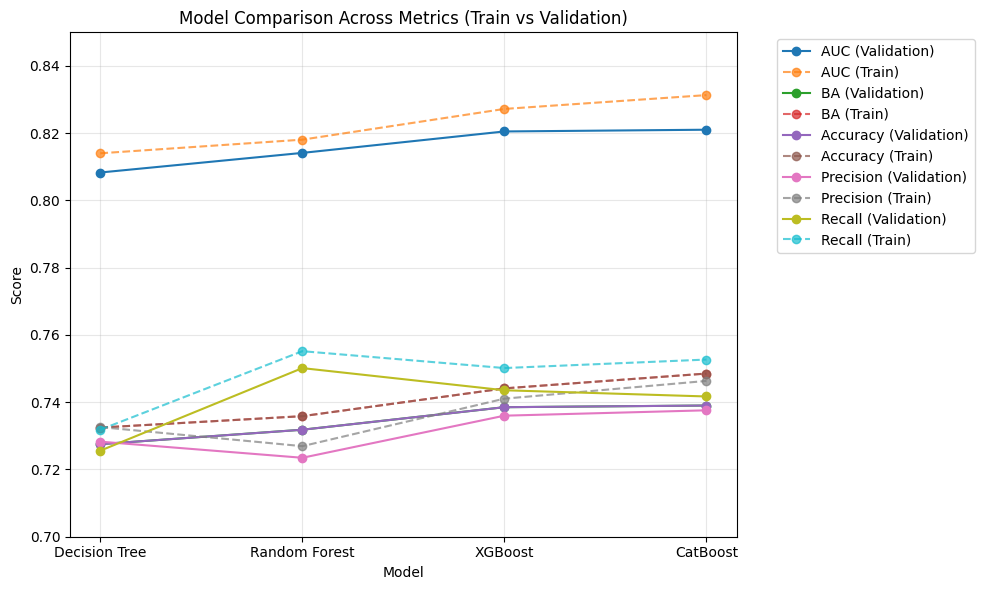

In [147]:
x = range(len(models_order))

metrics = {
    "AUC": ("Train AUC", "Val AUC"),
    "BA": ("Train BA", "Val BA"),
    "Accuracy": ("Train Acc", "Val Acc"),
    "Precision": ("Train Prec", "Val Prec"),
    "Recall": ("Train Rec", "Val Rec")
}

plt.figure(figsize = (10,6))

for metric_name, (train_col, val_col) in metrics.items():
    plt.plot(
        x,
        metrics_df[val_col],
        marker = "o",
        linestyle = "-",
        label = f"{metric_name} (Validation)"
    )
    plt.plot(
        x,
        metrics_df[train_col],
        marker = "o",
        linestyle = "--",
        alpha = 0.7,
        label = f"{metric_name} (Train)"
    )

plt.xticks(x, models_order)
plt.ylim(0.70, 0.85)
plt.ylabel("Score")
plt.xlabel("Model")
plt.title("Model Comparison Across Metrics (Train vs Validation)")
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

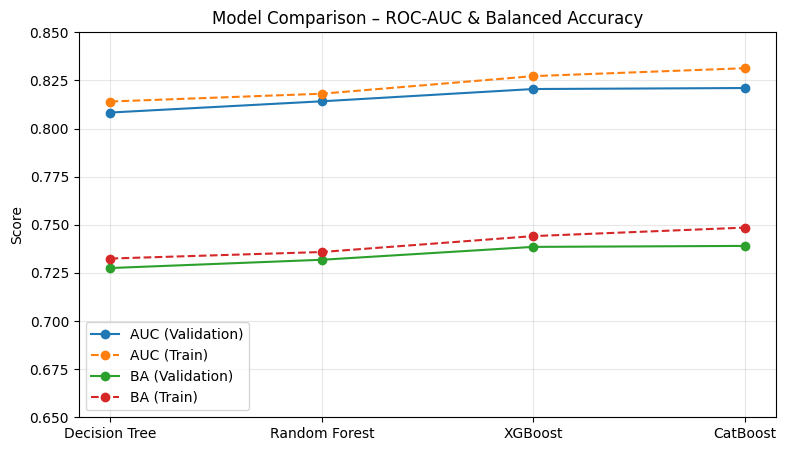

In [148]:
plt.figure(figsize = (9,5))

for metric_name, (train_col, val_col) in {
    "AUC": ("Train AUC", "Val AUC"),
    "BA": ("Train BA", "Val BA")
}.items():
    plt.plot(x, metrics_df[val_col], marker = "o", linestyle = "-", label = f"{metric_name} (Validation)")
    plt.plot(x, metrics_df[train_col], marker = "o", linestyle = "--", label = f"{metric_name} (Train)")

plt.xticks(x, models_order)
plt.ylim(0.65, 0.85)
plt.ylabel("Score")
plt.title("Model Comparison – ROC-AUC & Balanced Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [149]:
importances = {
    "Decision Tree": dt_importances,
    "Random Forest": rf_importances,
    "XGBoost": xgb_importances,
    "CatBoost": cat_importances
}

In [150]:
feat_imp_df = pd.DataFrame(importances).fillna(0)
feat_imp_norm = feat_imp_df.div(feat_imp_df.sum(axis = 0), axis = 1)

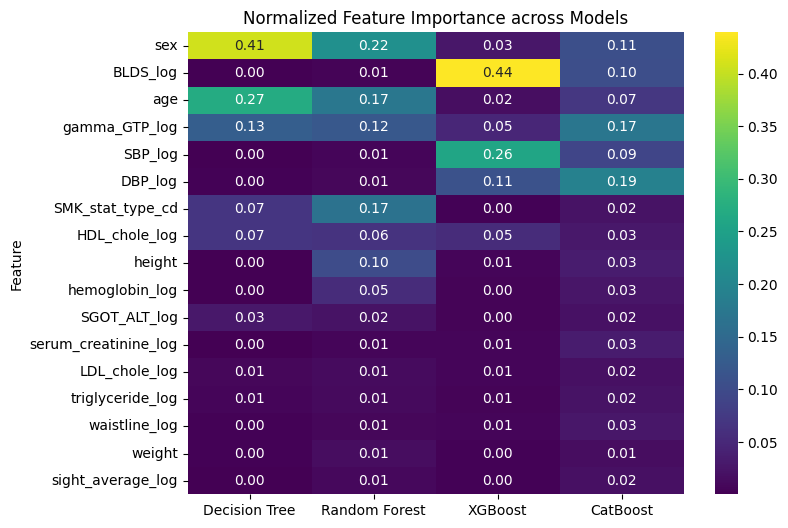

In [151]:
top_features = (
    feat_imp_norm.mean(axis = 1)
    .sort_values(ascending = False)
    .index
)

plt.figure(figsize = (8,6))
sns.heatmap(
    feat_imp_norm.loc[top_features],
    annot = True,
    fmt = ".2f",
    cmap = "viridis"
)
plt.title("Normalized Feature Importance across Models")
plt.ylabel("Feature")
plt.show()

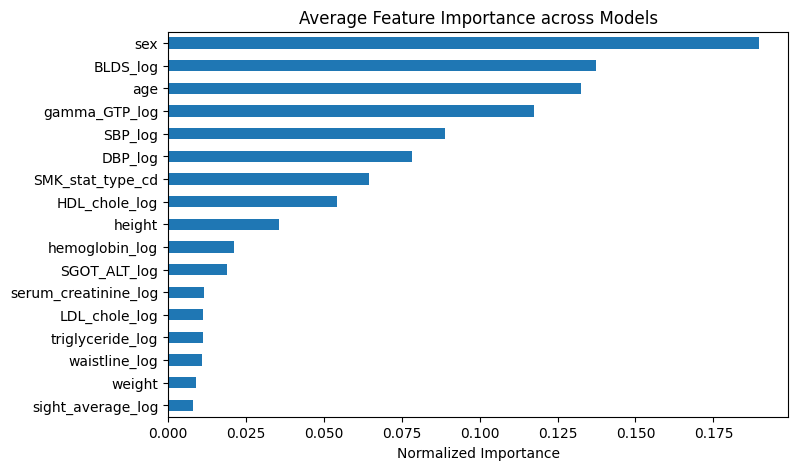

In [152]:
feat_imp_norm["Mean Importance"] = feat_imp_norm.mean(axis = 1)

feat_imp_norm["Mean Importance"] \
    .sort_values(ascending = False) \
    .iloc[::-1] \
    .plot(kind = "barh", figsize = (8, 5))

plt.title("Average Feature Importance across Models")
plt.xlabel("Normalized Importance")
plt.show()

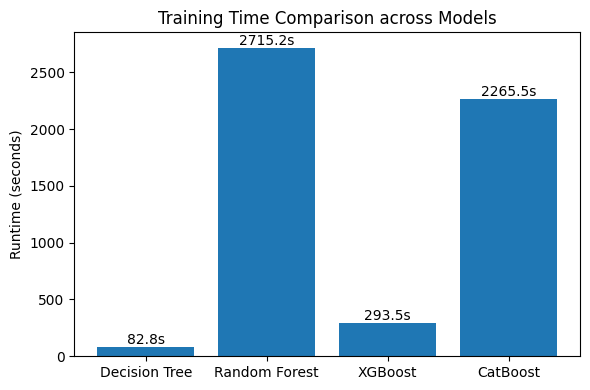

In [153]:
time_df = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "XGBoost", "CatBoost"],
    "Runtime (seconds)": [dt_time, rf_time, xgb_time, cat_time]
})

plt.figure(figsize = (6, 4))
bars = plt.bar(
    time_df["Model"],
    time_df["Runtime (seconds)"]
)

plt.ylabel("Runtime (seconds)")
plt.title("Training Time Comparison across Models")

# Optional: label bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}s",
        ha = "center",
        va = "bottom"
    )

plt.tight_layout()
plt.show()

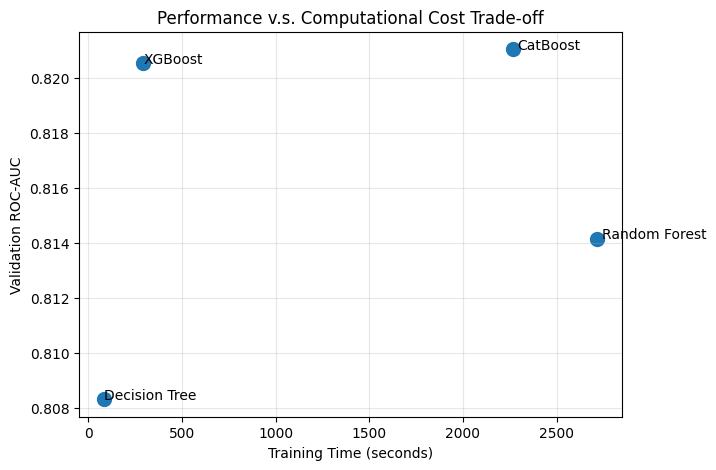

In [ ]:
plt.figure(figsize = (7, 5))

plt.scatter(
    time_df["Runtime (seconds)"],
    metrics_df["Val AUC"],
    s = 100
)

for i, model in enumerate(time_df["Model"]):
    plt.text(
        time_df["Runtime (seconds)"][i] * 1.01,
        metrics_df["Val AUC"][i],
        model
    )

plt.xlabel("Training Time (seconds)")
plt.ylabel("Validation ROC-AUC")
plt.title("Performance v.s. Computational Cost Trade-off")
plt.grid(alpha = 0.3)
plt.show() # choose XGBoost

# **Final Test**

In [155]:
# predict probabilities
xgb_test_probability = best_xgb.predict_proba(drinking_test_X)[:, 1]

# predict labels with fixed variable name
xgb_test_prediction = (xgb_test_probability >= 0.5).astype(int)

# metrics
xgb_test_auc = roc_auc_score(drinking_test_y, xgb_test_probability)
xgb_test_ba = balanced_accuracy_score(drinking_test_y, xgb_test_prediction)
xgb_test_acc = accuracy_score(drinking_test_y, xgb_test_prediction)
xgb_test_prec = precision_score(drinking_test_y, xgb_test_prediction)
xgb_test_rec = recall_score(drinking_test_y, xgb_test_prediction)

print(
    f"TRAIN - ROC-AUC: {xgb_train_auc:.4f}, "
    f"Balanced Acc: {xgb_train_ba:.4f}, "
    f"Acc: {xgb_train_acc:.4f}, "
    f"Prec: {xgb_train_prec:.4f}, "
    f"Recall: {xgb_train_rec:.4f}"
)

print(
    f"TEST - ROC-AUC: {xgb_test_auc:.4f}, "
    f"Balanced Acc: {xgb_test_ba:.4f}, "
    f"Acc: {xgb_test_acc:.4f}, "
    f"Prec: {xgb_test_prec:.4f}, "
    f"Recall: {xgb_test_rec:.4f}"
)
# TEST - ROC-AUC: 0.8197, Balanced Acc: 0.7366, Acc: 0.7366, Prec: 0.7335, Recall: 0.7431

TRAIN - ROC-AUC: 0.8272, Balanced Acc: 0.7441, Acc: 0.7441, Prec: 0.7411, Recall: 0.7502
TEST - ROC-AUC: 0.8199, Balanced Acc: 0.7378, Acc: 0.7378, Prec: 0.7351, Recall: 0.7432


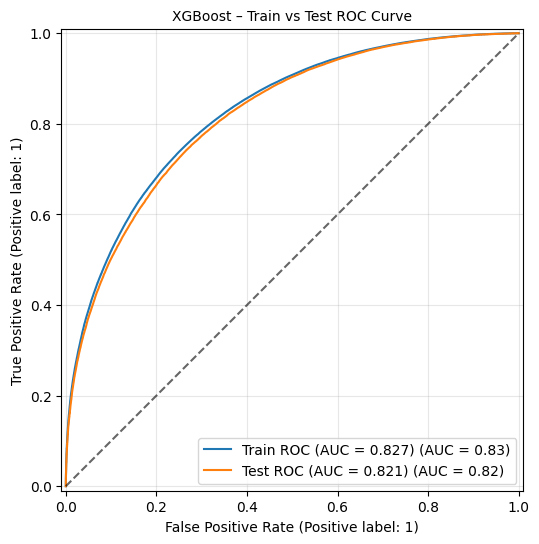

In [156]:
fig, ax = plt.subplots(figsize = (6, 6))

RocCurveDisplay.from_predictions(
    drinking_train_y,
    xgb_train_probability,
    ax = ax,
    name = f"Train ROC (AUC = {xgb_train_auc:.3f})"
)

RocCurveDisplay.from_predictions(
    drinking_test_y,
    xgb_test_probability,
    ax = ax,
    name = f"Test ROC (AUC = {xgb_validation_auc:.3f})"
)

ax.plot([0, 1], [0, 1], "k--", alpha = 0.6)
ax.set_title("XGBoost – Train vs Test ROC Curve", fontsize = 10)
ax.grid(alpha = 0.3)

plt.show() # there is no overfitting

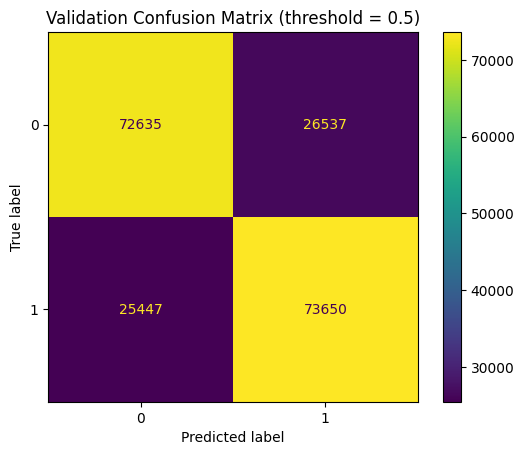

In [157]:
xgb_cm = confusion_matrix(drinking_test_y, xgb_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix = xgb_cm)
disp.plot(values_format = "d")
plt.title("Validation Confusion Matrix (threshold = 0.5)")
plt.show()

In [158]:
print("TEST CLASSIFICATION REPORT")
print(
    classification_report(
        drinking_test_y,
        xgb_test_prediction,
        target_names = ["No", "Yes"]
    )
)

TEST CLASSIFICATION REPORT
              precision    recall  f1-score   support

          No       0.74      0.73      0.74     99172
         Yes       0.74      0.74      0.74     99097

    accuracy                           0.74    198269
   macro avg       0.74      0.74      0.74    198269
weighted avg       0.74      0.74      0.74    198269



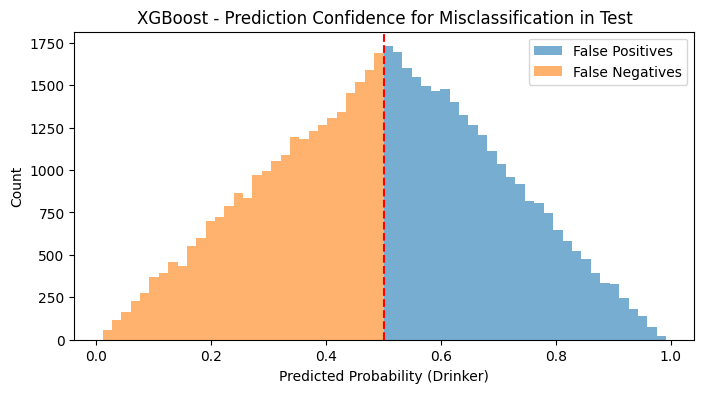

In [159]:
# probability confidence analysis - show that errors occur near the decision boundary
val_results = drinking_test_X.reset_index(drop = True).copy()
val_results["true"] = drinking_test_y.reset_index(drop = True)
val_results["pred"] = xgb_test_prediction
val_results["proba"] = xgb_test_probability

false_pos = val_results[(val_results.true == 0) & (val_results.pred == 1)]
false_neg = val_results[(val_results.true == 1) & (val_results.pred == 0)]

plt.figure(figsize = (8, 4))
plt.hist(false_pos["proba"], bins = 30, alpha = 0.6, label = "False Positives")
plt.hist(false_neg["proba"], bins = 30, alpha = 0.6, label = "False Negatives")
plt.axvline(0.5, color = "red", linestyle = "--")
plt.xlabel("Predicted Probability (Drinker)")
plt.ylabel("Count")
plt.title("XGBoost - Prediction Confidence for Misclassification in Test")
plt.legend()
plt.show()